# Prognosis analysis

#### Philippe Pinel
July 2019

## Summary
In this notebook we carry out a prognosis analysis to determine which models and which algorithms to work with for different endpoints, with a greater predictive power than the current IPSSR score. We focus here on the overall survival, except for the feature importance which is done for all endpoints: overall survival (`OS`), AML transformation (`AMLt`) and AML free survival (`EVENT_FREE`).

The cohort is constituted of 3324 patients with their clinical data (`ANC`, `BM_BLAST`, `HB`, `PLT`, `WBC`), their demographical data (age and sex), their MDS type, as well their mutations in a panel of 144 targeted genes, their cytogenetic aberrations, if they have a complex karyotype, and their uniparental disomy (UPD). We use a cut-off of 5 for selecting only the most important features. For some patients data is missing, so we will focus our study on the complete case here.

## Outline
##### 1. Preprocessing
##### 2. Continuous feature transformation
##### 3. Proportional hazards assumption
##### 4. Comparison of models and algorithms 
##### 5. Feature importance

***

In [2]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library('grid')
library('gridExtra')
library('ggthemes')
library('stringr')
library('mfp')


source("../../src/tools.R")
source("../../src/merge_df.R")
source("../../src/my_survival.R")
source("../../src/tools_feature_importance.R")
source("../../src/tools_survival_plot.R")

theme_set(theme_bw())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [3]:
# -------------- DATA -------------- #
# CLINICAL DF
ddc = read.table("../../data/final_dataset/df_clinical_cyto_selected_process_ippsr.tsv",stringsAsFactors=F,header=T,sep="\t")
# ADD METRIC
ddc$AGE = round(ddc$AGE_AT_SAMPLE_TIME)
# MUTATIONS MAF
ddmaf = read.table("../../data/final_dataset/df_maf_driver_selected.tsv",stringsAsFactors=F,header=T,sep="\t")
# MUTATION WITH HOTSPOTS AND CYTO DF
ddhot = read.table("../../data/final_dataset/df_mut_hotspot_cut5.tsv", stringsAsFactors=F,header=T,sep="\t")
ddcyto = read.table("../../data/final_dataset/df_cyto_binary_impute_cut5.tsv",stringsAsFactors=F,header=T,sep="\t")
ddcyto_full = read.table("../../data/final_dataset/df_cyto_binary_impute.tsv",stringsAsFactors=F,header=T,sep="\t") # add upd7
# ---------------------------------- #
ddmut = res = merge_clinical_mutation(dd_clinical=ddc, dd_maf=ddmaf, binary=F, col_field="EVENT")
ddmut = res$ddmut #  mutation matrix
# ---------------------------------- #
if(identical(ddc$LEUKID,ddcyto$LEUKID)) print("all good")
if(identical(ddcyto_full$LEUKID,rownames(ddhot))) print("all good^2")
ddcyto = ddcyto[,-1]
# TP53 STATUS
ddtp53 = read.table("../../data/final_dataset/TP53_allelic_status.tsv",header=T,stringsAsFactors=F)
rownames(ddtp53) = ddtp53$LEUKID
ddtp53$LEUKID = NULL
ddtp53 = ddtp53[ddc$LEUKID,]
ddhot$TP53 <- NULL
ddhot$TP53_monoallelic <- with(ddtp53,ifelse(TP53_state=='1mut',1,0))
ddhot$TP53_biallelic <- with(ddtp53,ifelse(TP53_state=='multi',1,0))
# CK
ddcyto$CK=ddtp53$CK


[1] "all good"
[1] "all good^2"


# 1. Preprocessing
In this section we perform some univariate analysis to see for `U2AF1` and `IDH2` if we need to create new features for each hotspot by looking at the survival curves and cumulative event curves.
We also compare the survival curves and cumulative event curves of `EZH2` and `EZH2_LOH` to see if there is a significant difference. 

Finally, we describe the difference between monoallelic TP53 and biallelic TP53.

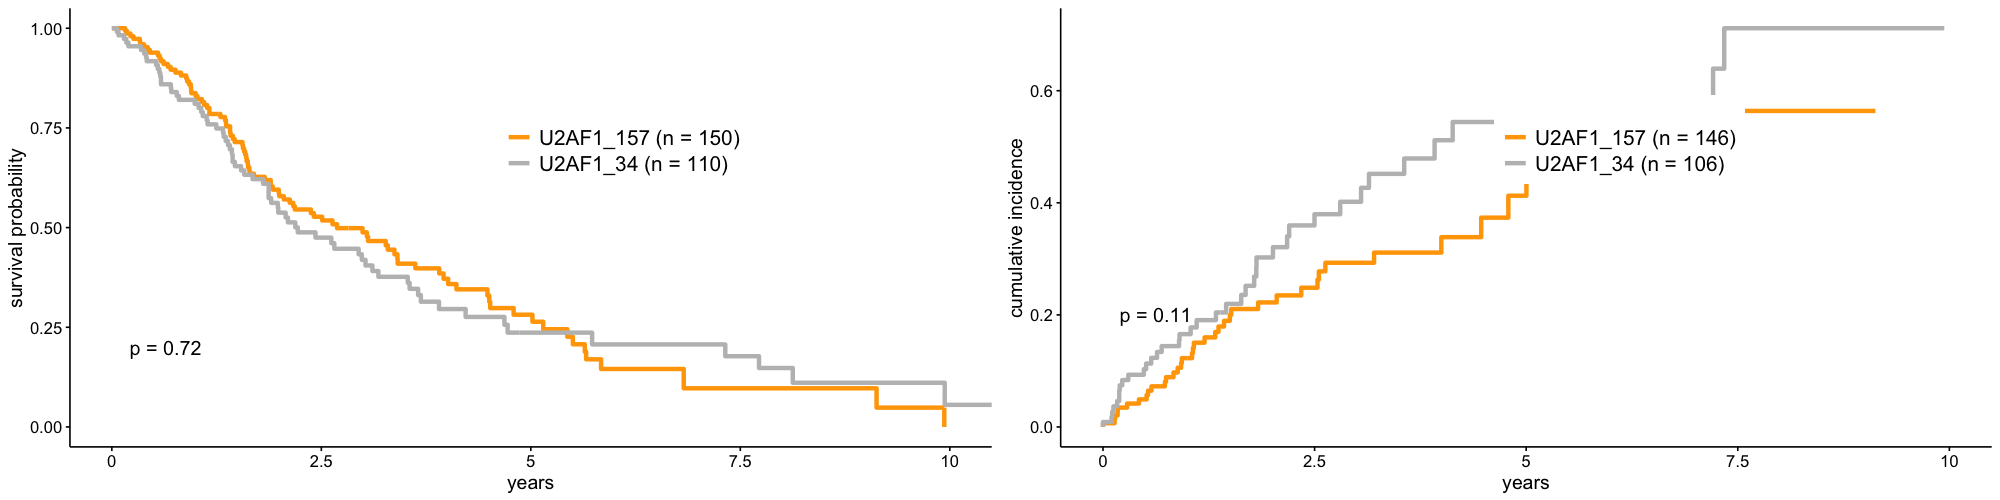

In [70]:
set_notebook_plot_size(20,5)
g_U2AF1_os<-plot_survival_curve_stratified_by_categorical_feature(data.frame(ddhot,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (ddhot[,'U2AF1_34'] == 1),
                                                                wildtype_mask = (ddhot[,'U2AF1_157'] == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='U2AF1_34',
                                                                wildtype_name='U2AF1_157',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = F,
                                                                pval = T)
g_U2AF1_aml<-plot_survival_curve_stratified_by_categorical_feature(data.frame(ddhot,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (ddhot[,'U2AF1_34'] == 1),
                                                                wildtype_mask = (ddhot[,'U2AF1_157'] == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='U2AF1_34',
                                                                wildtype_name='U2AF1_157',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = T,
                                                                pval = T)
grid.arrange(g_U2AF1_os,g_U2AF1_aml,ncol=2)

The 2 hotspots for `U2AF1` behave the same in terms of both overall survival and AML transformation, therefore there is no need to create features for them.

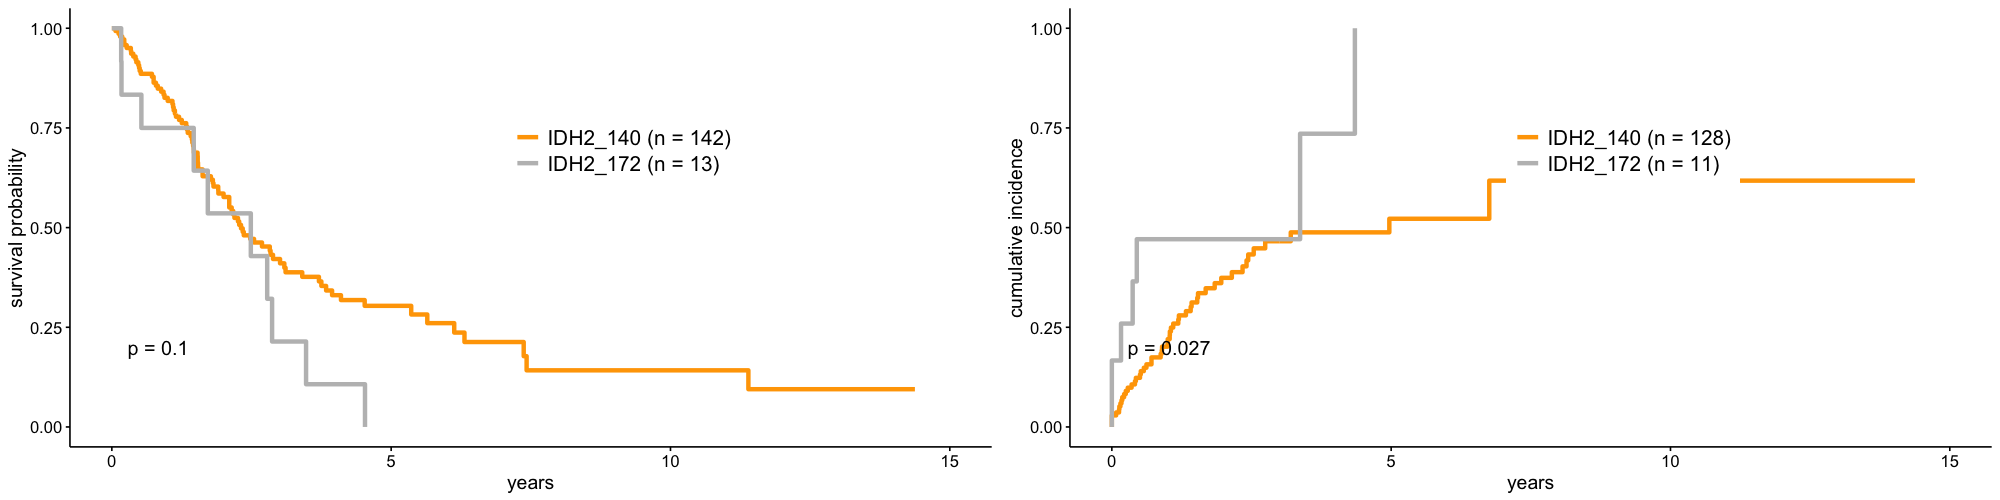

In [71]:
set_notebook_plot_size(20,5)
g_IDH2_os<-plot_survival_curve_stratified_by_categorical_feature(data.frame(ddhot,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (ddhot[,'IDH2_172'] == 1),
                                                                wildtype_mask = (ddhot[,'IDH2_140'] == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='IDH2_172',
                                                                wildtype_name='IDH2_140',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = F,
                                                                pval = T)
g_IDH2_aml<-plot_survival_curve_stratified_by_categorical_feature(data.frame(ddhot,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (ddhot[,'IDH2_172'] == 1),
                                                                wildtype_mask = (ddhot[,'IDH2_140'] == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='IDH2_172',
                                                                wildtype_name='IDH2_140',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = T,
                                                                pval = T)
grid.arrange(g_IDH2_os,g_IDH2_aml,ncol=2)

`IDH2_172` has a significant greater impact on AML transformation than the other hotspot `IDH2_140`,  we will then consider each hotspot as a different feature for the rest of this analysis. 

Let's study the differences in outcome for `EZH2_only` and `EZH2_LOH`. We define:
- *EZH2_LOH* as the association of a mutation in *EZH2* and one of the four events: *del7*, *del7q*, *upd7*, *upd7q*.
- *EZH2_only* as a mutation in *EZH2* and none of the 4 previous events.

In [55]:
EZH2_LOH <- with(cbind(ddhot,ddcyto_full),ifelse(EZH2==1&(del7+del7q+upd7+upd7q>=1),1,0))
EZH2_only <- with(cbind(ddhot,ddcyto_full),ifelse(EZH2==1&(del7+del7q+upd7+upd7q==0),1,0))

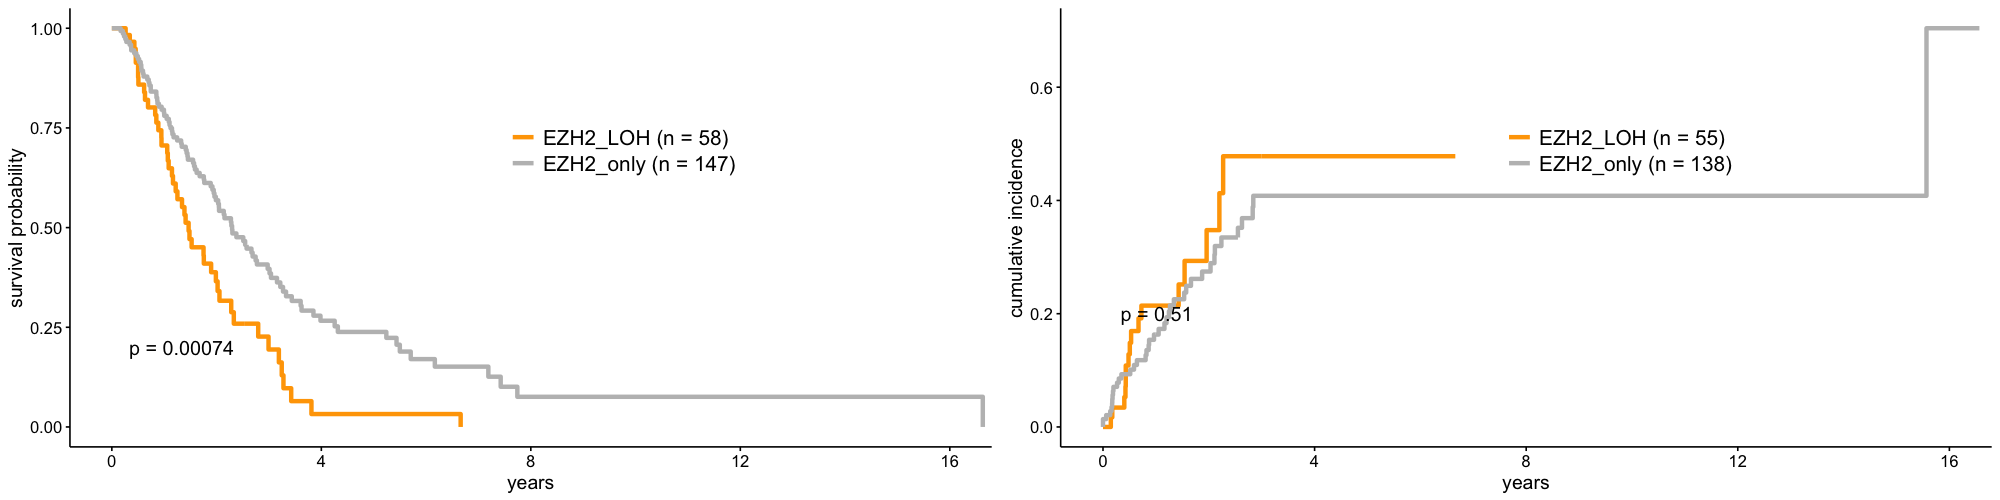

In [72]:
set_notebook_plot_size(20,5)
g_EZH2_os<-plot_survival_curve_stratified_by_categorical_feature(data.frame(EZH2_LOH=EZH2_LOH,EZH2_only=EZH2_only,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (EZH2_LOH == 1),
                                                                wildtype_mask = (EZH2_only == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='EZH2_LOH',
                                                                wildtype_name='EZH2_only',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = F,
                                                                pval = T)
g_EZH2_aml<-plot_survival_curve_stratified_by_categorical_feature(data.frame(EZH2_LOH=EZH2_LOH,EZH2_only=EZH2_only,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (EZH2_LOH == 1),
                                                                wildtype_mask = (EZH2_only == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='EZH2_LOH',
                                                                wildtype_name='EZH2_only',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = T,
                                                                pval = T)
grid.arrange(g_EZH2_os,g_EZH2_aml,ncol=2)

There is a significant difference between those 2 features in overall survival, so EZH2_LOH is well captured by the features used to define it, we will keep them in the rest of the analysis (adding upd7).

For `TP53`, we differentiate according to its allelic status, where:
- *TP53_monoallelic* corresponds to an isolated mutation in TP53
- *TP53_biallelic* corresponds to at least one mutation in TP53 with loss of heterozygosity (LOH) or to several mutations in TP53

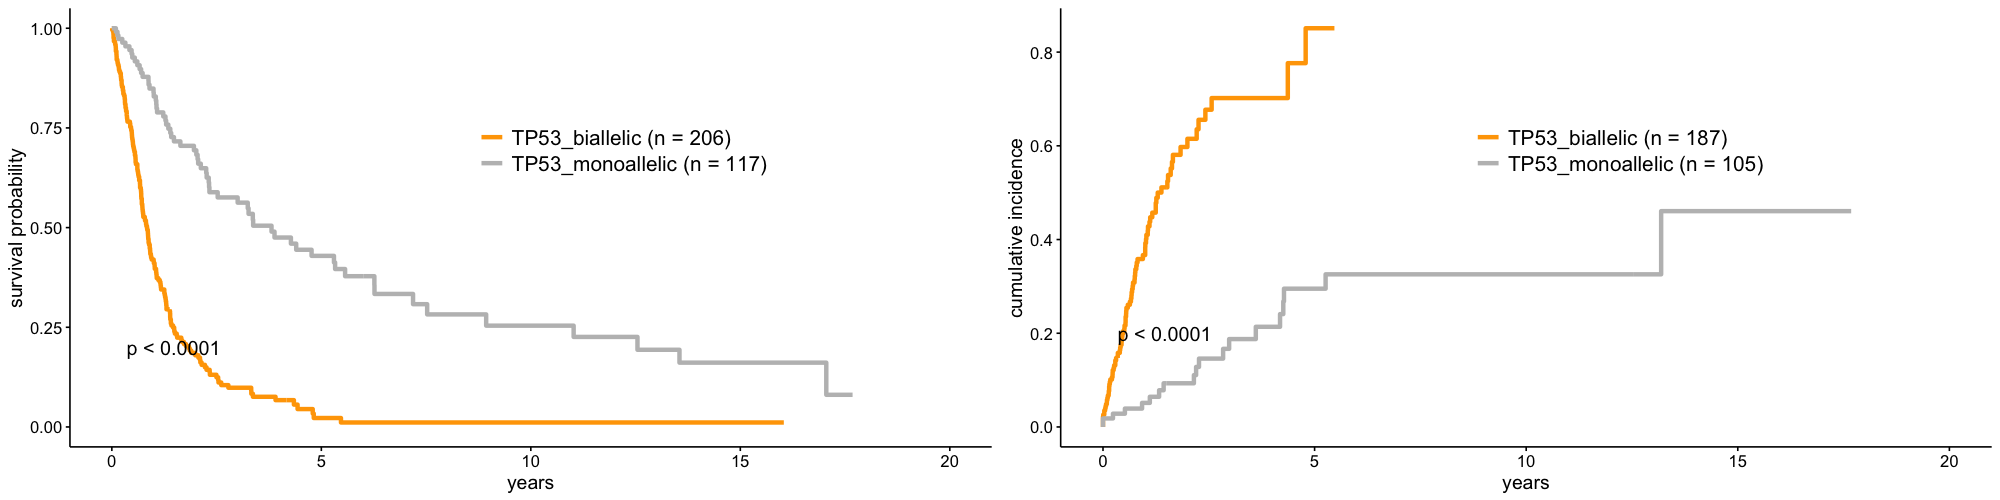

In [532]:
set_notebook_plot_size(20,5)
g_tp53_os<-plot_survival_curve_stratified_by_categorical_feature(data.frame(ddhot,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (ddhot[,'TP53_monoallelic'] == 1),
                                                                wildtype_mask = (ddhot[,'TP53_biallelic'] == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='TP53_monoallelic',
                                                                wildtype_name='TP53_biallelic',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = F,
                                                                pval = T)
g_tp53_aml<-plot_survival_curve_stratified_by_categorical_feature(data.frame(ddhot,os_diag_years=ddc$os_diag_years,os_status=ddc$os_status,aml_diag_years=ddc$aml_diag_years,aml_status=ddc$aml_status),
                                                                mask = (ddhot[,'TP53_monoallelic'] == 1),
                                                                wildtype_mask = (ddhot[,'TP53_biallelic'] == 1),
                                                                stratifier_column_name = '',
                                                                legend_prefix ='TP53_monoallelic',
                                                                wildtype_name='TP53_biallelic',
                                                                colors = c('orange', 'grey'),
                                                                remove_na = FALSE,
                                                                AML = T,
                                                                pval = T)
grid.arrange(g_tp53_os,g_tp53_aml,ncol=2)

There is a strong difference between these two features in both overall survival and AML transformation.


Let's build the complete case by removing all patients with `NA` and add the new features we just defined:

In [4]:
# ---------------------------------- #
# CHANGE FEATURES
# ---------------------------------- #
# U2AF1
ddhot$U2AF1=ddhot$U2AF1_157+ddhot$U2AF1_34
ddhot$U2AF1_157=NULL
ddhot$U2AF1_34=NULL
# upd7
ddcyto$upd7=ddcyto_full$upd7
# Number of mutations in genes that are significant for at least one of the 3 categories of IPSSR
ddmut$nmut = ddmut$ASXL1+ddmut$SF3B1+ddmut$SRSF2+ddmut$RUNX1+ddmut$TP53+ddmut$STAG2+ddmut$U2AF1+ddmut$EZH2+ddmut$BCOR+ddmut$CBL+ddmut$NRAS+ddmut$SETBP1+
            ddmut$NF1+ddmut$KRAS+ddmut$DDX41+ddmut$MLL_PTD+ddmut$PTPN11+ddmut$ETV6+ddmut$ETNK1+ddmut$CEBPA+ddmut$NPM1+ddmut$WT1+ddmut$GNAS
# ---------------------------------- #
# COMPLETE CASE FOR ALL ENDPOINTS
# ---------------------------------- #
ddgo = data.frame(ddc,ddhot,ddcyto,num_mutations=ddmut$nmut)
i.complete = which(ddc$ipssr_complete_case=="complete")
# remove missing data for OS
response.name1 = c("os_sample_years","os_status")
tmp = ddc[i.complete,response.name1]
i.survival = i.complete[-which(tmp[,1]<=0 | is.na(tmp[,1]) | is.na(tmp[,2]))]
ddgo = ddgo[i.survival,]
# remove missing data for AML transformation
response.name2 = c("aml_sample_years","aml_status")
i.not.aml = which(ddgo$WHO_2016_SIMPLIFY_2!="AML")
tmp2 = ddgo[i.not.aml,response.name2]
i.not.aml = i.not.aml[-which(tmp2[,1]<=0 | is.na(tmp2[,1]) | is.na(tmp2[,2]))]
ddgo = ddgo[i.not.aml,]
response.name3 = c("free_os_sample_years","free_os_status")
# remove missing data for WBC
i.wbc = which(!is.na(ddgo$WBC))
ddgo = ddgo[i.wbc,]
# remove missing data for MDS_TYPE 
i.final = which(!is.na(ddgo$MDS_TYPE))
ddgo = ddgo[i.final,]
ddgo$MDS_TYPE[ddgo$MDS_TYPE!='primary']='other' # merge secondary and therapy-related together
# mean imputation for nuisance missing
ddgo[is.na(ddgo[, "YEAR_OF_SAMPLE_CORRECT"]), "YEAR_OF_SAMPLE_CORRECT"] <- mean(ddgo[, "YEAR_OF_SAMPLE_CORRECT"], na.rm = TRUE) 
# remove 1 patient with ANC = 0
ddgo = ddgo[ddgo$ANC!=0,]
# ---------------------------------- #
# DEFINE FEATURE GROUPS
# ---------------------------------- #
nuisance = c("CENTER","YEAR_OF_SAMPLE_CORRECT")
ipssr = c("AGE","HB","PLT","ANC","BM_BLAST","CYTO_IPSSR","IPSSR_CALCULATED")
clinicalother = c("SEX")
mutnumber = c("num_mutations")
mutations = colnames(ddhot)
upd=colnames(ddcyto)[grep('upd',colnames(ddcyto))]
cytoaberrations = colnames(ddcyto)[-grep('upd',colnames(ddcyto))]
age=c("AGE")
ipssr.score=c("IPSSR_CALCULATED")
ipssr.wt.score = c("AGE","HB","PLT","ANC","BM_BLAST","CYTO_IPSSR")
clin=c("HB","PLT","ANC","BM_BLAST","WBC")
mds_type=c("MDS_TYPE")


list.features = list(nuisance=nuisance,
                  ipssr=ipssr,
                  clinicalother=clinicalother,
                  mutnumber=mutnumber,
                  mutations=mutations,
                  upd=upd,
                  cytoaberrations=cytoaberrations,
                  age=age,
                  ipssr.score=ipssr.score,
                  ipssr.wt.score=ipssr.wt.score,
                  clin=clin,
                  mds_type=mds_type)

ddgo = ddgo[,c(unique(unlist(list.features)),response.name1,response.name2,response.name3)] 

In [433]:
cbind(dim(ddc),dim(ddgo))[1,]

[1] 3324 2348

We have a total of 3324 patients in our cohort, but our complete case is composed of 2348 patients. We will perform all our analysis on those selected patients.

We define the number of mutations `NMUT` as the number of mutations for one patient in the genes having a significant impact on survival in at least one IPSSR category. Those genes are: ASXL1, SF3B1, SRSF2, RUNX1, TP53, STAG2, U2AF1, EZH2, BCOR, CBL, NRAS, SETBP1, NF1, KRAS, DDX41, MLL_PTD, PTPN11, ETV6, ETNK1, CEBPA, NPM1, WT1, and GNAS.

All this analysis will be performed using `CENTER` and `YEAR_OF_SAMPLE_CORRECT` as nuisance features to adjust the models.


# 2. Continuous feature transformation 
Describing continuous features by categories when doing prediction is convenient but is clinically implausible. We need to use more complicated functions to describe the relations of those features with overall survival: penalised splines, fractional polynomials, ridge-regression can be used to find such functions.

The continuous features considered here are:
- PLT
- ANC
- WBC
- BM_BLAST
- HB


We will use multivariable fractional polynomials to transform those features.

We use `mfp` R package (https://cran.r-project.org/web/packages/mfp/vignettes/mfp_vignette.pdf) to determine which functions should be used to transform continuous features in the Cox model to better predict overall survival. The models are of the form *a + b$x^p$ + c$x^q$* or *a + b$x^p$ + c$x^p$*log *x* with p and q chosen from candidates -2, -1, -0.5, 0, 0.5, 1, 2, 3, where 0 denotes the function log. The best fit among the combinations of such powers is defined as that which maximizes the likelihood. 

See *'The use of fractional polynomials to model continuous risk variables in epidemiology'* in `doc/` folder.

We want to quantify the effect of transforming the features on both the concordance index and the Martingale residuals of the Cox-model, which compare observed events (0 or 1) versus expected events obtained from the trained model. The local averages of residuals (loess-curve) should ideally be horizontal for each continuous feature, lying at zero.

In [435]:
# Multivariate model
suppressWarnings(
f<-mfp(Surv(os_sample_years,os_status)~fp(BM_BLAST)+fp(ANC)+fp(HB)+fp(PLT)+fp(ANC)+fp(WBC),
       family=cox,
       data=ddgo,
       select=0.05,
       verbose=F))
summary(f)

Call:
coxph(formula = Surv(os_sample_years, os_status) ~ I((HB/10)^-0.5) + 
    log((HB/10)) + I(((BM_BLAST + 0.1)/10)^1) + I((PLT/100)^1) + 
    I((PLT/100)^2) + I((WBC/10)^0.5) + I((ANC/10)^-2), data = ddgo)

  n= 2348, number of events= 1110 

                                 coef  exp(coef)   se(coef)      z Pr(>|z|)    
I((HB/10)^-0.5)            -1.869e+01  7.619e-09  2.901e+00 -6.444 1.16e-10 ***
log((HB/10))               -1.170e+01  8.307e-06  1.568e+00 -7.462 8.53e-14 ***
I(((BM_BLAST + 0.1)/10)^1)  6.233e-01  1.865e+00  5.883e-02 10.595  < 2e-16 ***
I((PLT/100)^1)             -3.690e-01  6.914e-01  4.289e-02 -8.603  < 2e-16 ***
I((PLT/100)^2)              2.874e-02  1.029e+00  5.091e-03  5.645 1.65e-08 ***
I((WBC/10)^0.5)             4.430e-01  1.557e+00  6.450e-02  6.868 6.51e-12 ***
I((ANC/10)^-2)              7.512e-05  1.000e+00  1.723e-05  4.359 1.31e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                           exp(coef) exp(-coe

We see that `BM_BLAST` is not transformed. Let's compare the functions in the exponential in the Cox model of these features with and without transforming them (i.e. linear function for the latter):

In [436]:
untransformed_cox <- coxph(formula = Surv(os_sample_years,os_status)~BM_BLAST+ANC+HB+PLT+ANC+WBC,data = ddgo)
untransformed_cox

Call:
coxph(formula = Surv(os_sample_years, os_status) ~ BM_BLAST + 
    ANC + HB + PLT + ANC + WBC, data = ddgo)

              coef exp(coef)  se(coef)       z        p
BM_BLAST  0.067310  1.069627  0.005816  11.573  < 2e-16
ANC       0.007355  1.007382  0.006927   1.062    0.288
HB       -0.182751  0.832976  0.014445 -12.652  < 2e-16
PLT      -0.001750  0.998252  0.000249  -7.028 2.09e-12
WBC       0.003278  1.003283  0.002775   1.181    0.237

Likelihood ratio test=393.5  on 5 df, p=< 2.2e-16
n= 2348, number of events= 1110 

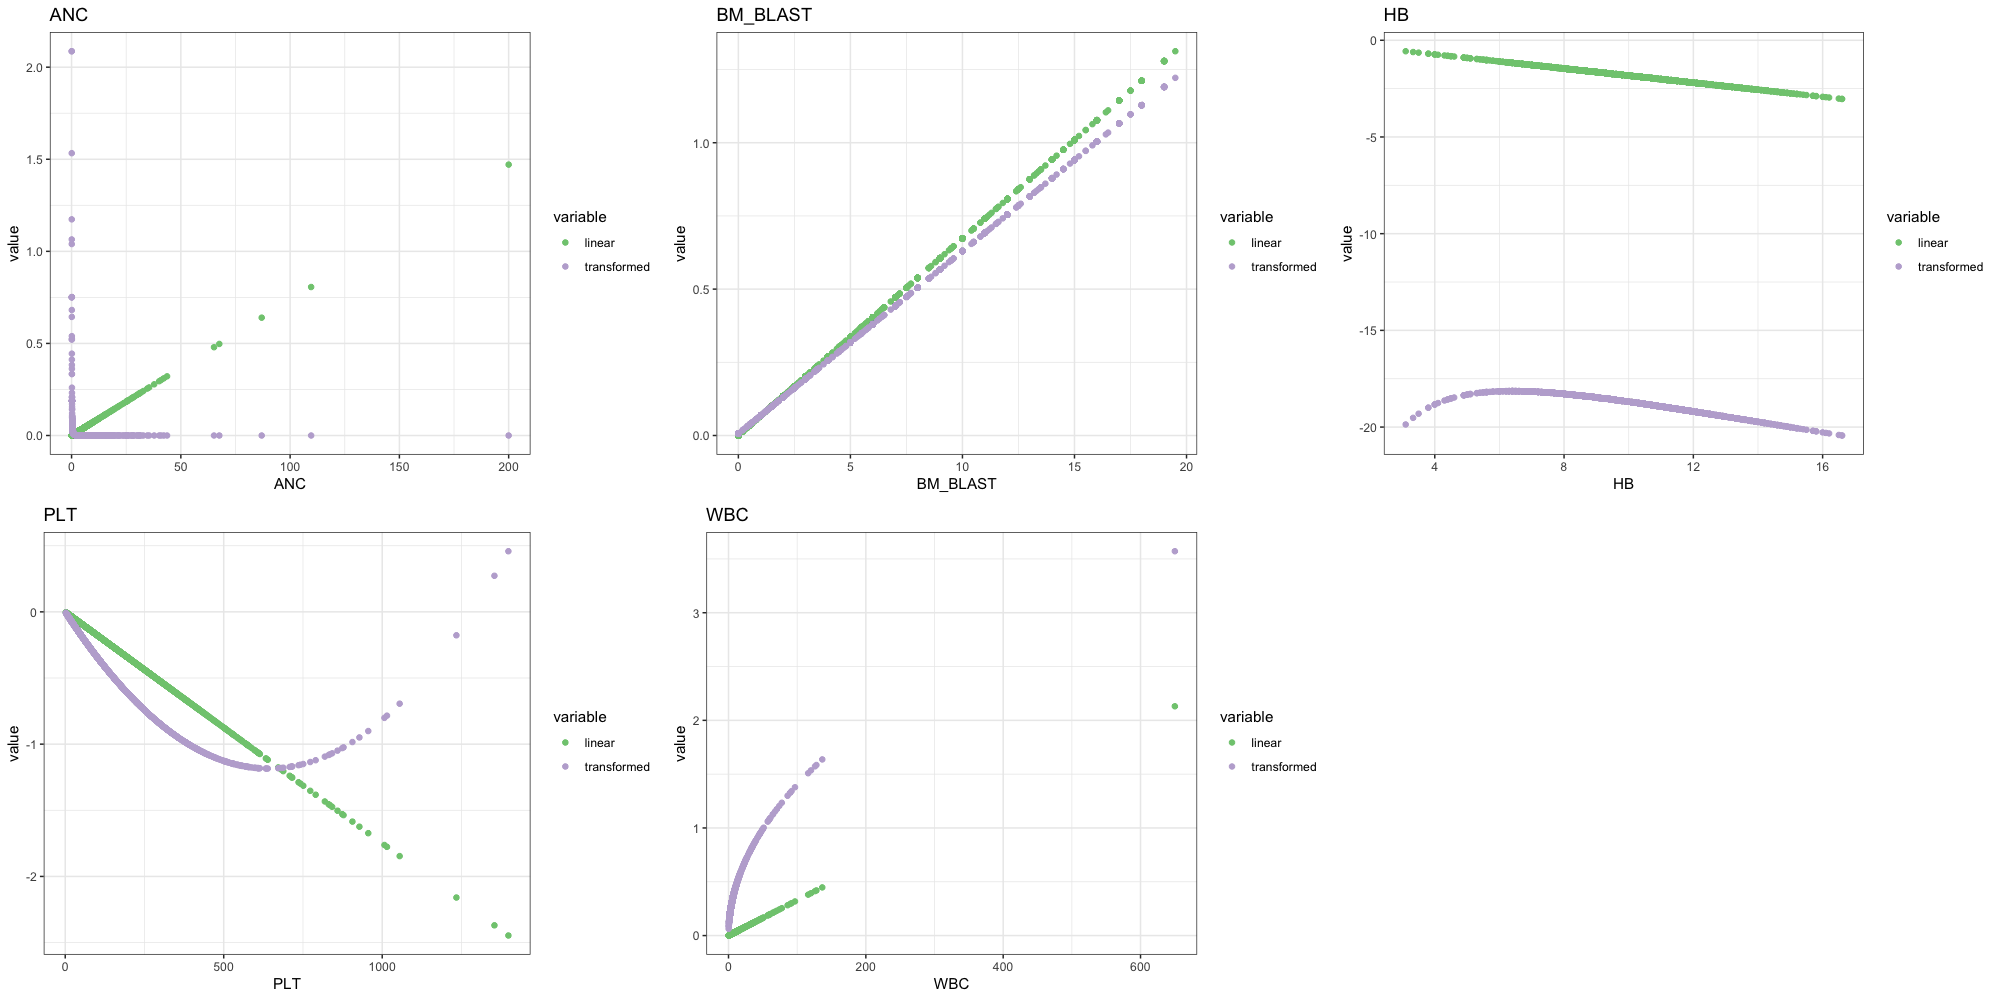

In [437]:
df_anc <- data.frame(ANC=ddgo$ANC,
                     linear=0.007355*ddgo$ANC,
                     transformed=7.512e-05*(ddgo$ANC/10)^-2)
df_anc <- melt(df_anc,id='ANC')

df_bm <- data.frame(BM_BLAST=ddgo$BM_BLAST,
                     linear=0.067310*ddgo$BM_BLAST,
                     transformed=6.233e-01*(ddgo$BM_BLAST + 0.1)/10)
df_bm <- melt(df_bm,id='BM_BLAST')

df_hb <- data.frame(HB=ddgo$HB,
                     linear=-0.182751*ddgo$HB,
                     transformed= -1.869e+01*((ddgo$HB/10)^-0.5)-1.170e+01*log((ddgo$HB/10)))
df_hb <- melt(df_hb,id='HB')

df_plt <- data.frame(PLT=ddgo$PLT,
                     linear=-0.001750*ddgo$PLT,
                     transformed=2.874e-02*((ddgo$PLT/100)^2)-3.690e-01*(ddgo$PLT/100))
df_plt <- melt(df_plt,id='PLT')

df_wbc <- data.frame(WBC=ddgo$WBC,
                     linear=0.003278*ddgo$WBC,
                     transformed=4.430e-01*((ddgo$WBC/10)^0.5))
df_wbc <- melt(df_wbc,id='WBC')

ganc <- ggplot(df_anc,aes(ANC,value)) + 
            geom_point(aes(col=variable)) +
            ggtitle('ANC') +
            #xlim(0,50)+
            scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))
gbm <- ggplot(df_bm,aes(BM_BLAST,value)) + 
            geom_point(aes(col=variable)) +
            ggtitle('BM_BLAST') +
            #xlim(0,50)+
            scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))
ghb <- ggplot(df_hb,aes(HB,value)) + 
            geom_point(aes(col=variable)) +
            ggtitle('HB') +
            #xlim(0,20)+
            scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))
gplt <- ggplot(df_plt,aes(PLT,value)) + 
            geom_point(aes(col=variable)) +
            ggtitle('PLT') +
            #xlim(0,1000)+
            scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))
gwbc <- ggplot(df_wbc,aes(WBC,value)) + 
            geom_point(aes(col=variable)) +
            ggtitle('WBC') +
            #xlim(0,1000)+
            scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))
g <- arrangeGrob(ganc,gbm,ghb,gplt,gwbc,nrow = 2)

set_notebook_plot_size(20,10)
grid.draw(g)

Let's compare the loess-curve of the Martingale residuals for linear and transformed variables:

Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

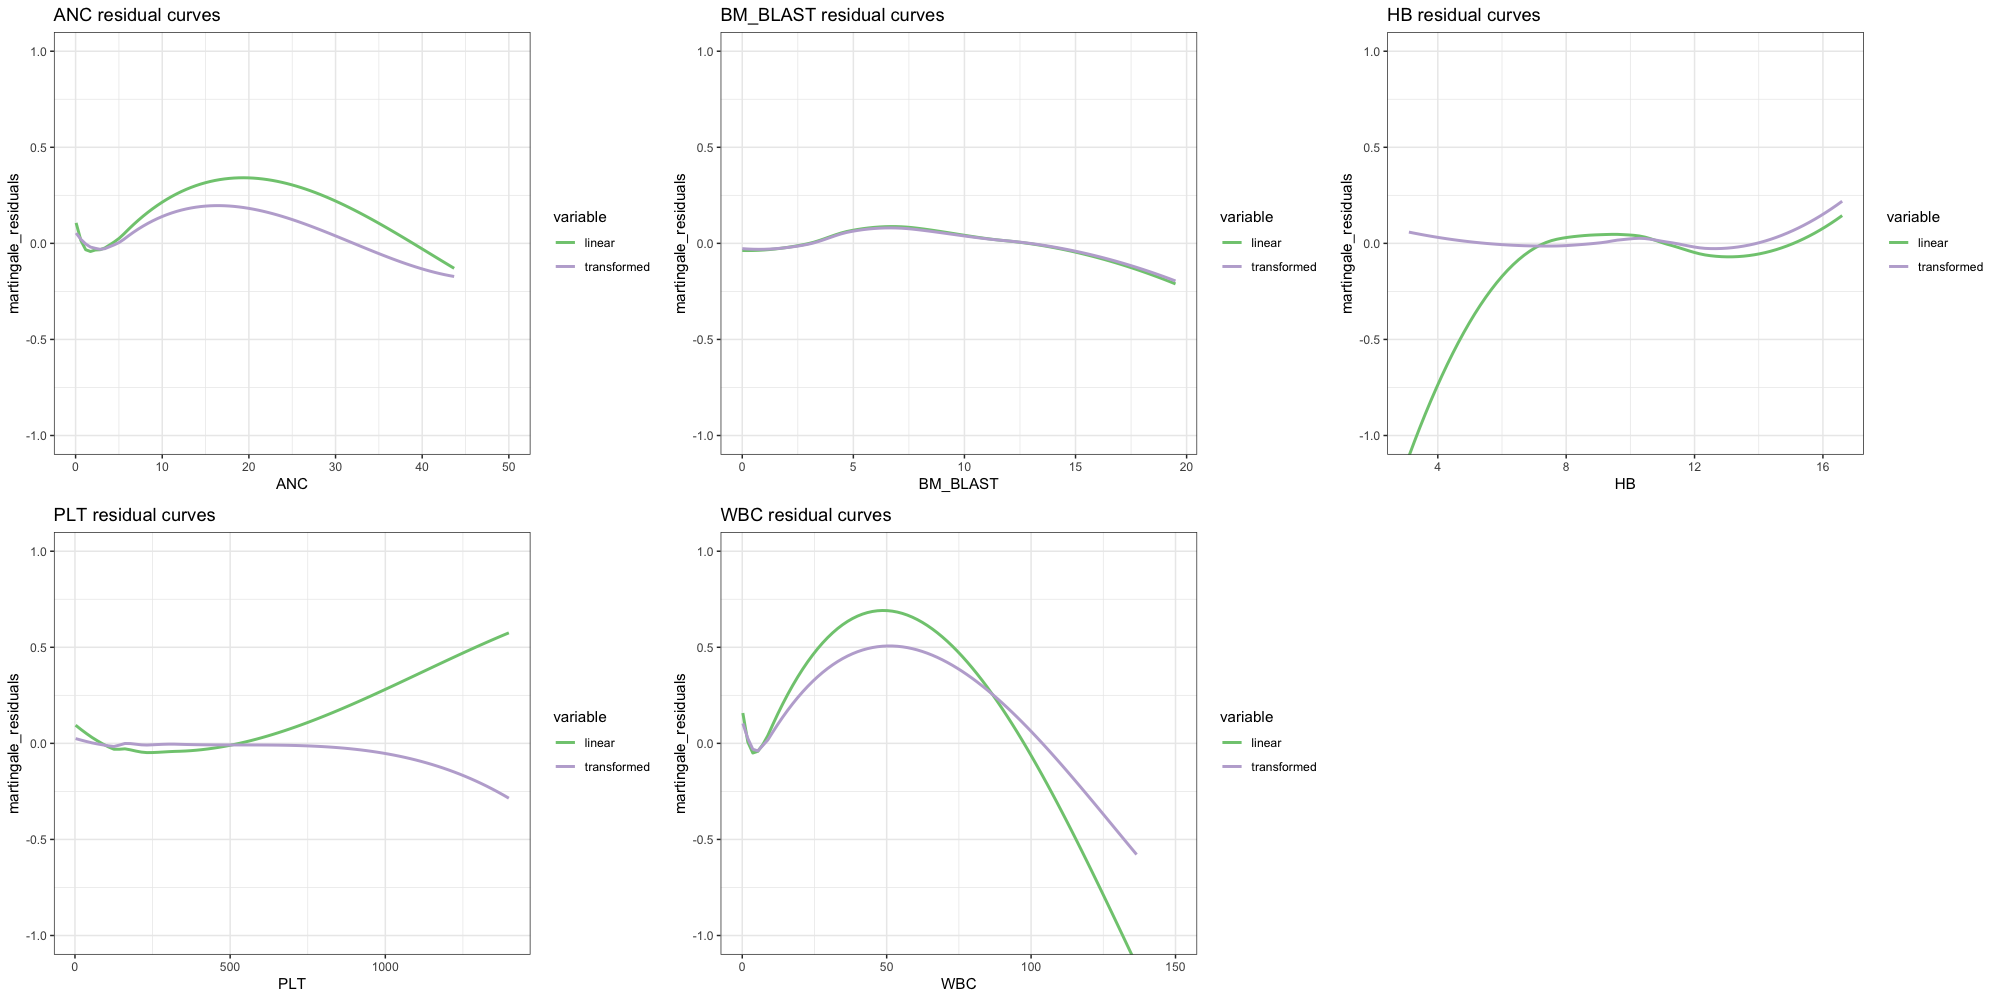

In [438]:
r_anc <- data.frame(linear=untransformed_cox$residuals,
                   transformed=f$residuals,
                   ANC=ddgo$ANC)
r_anc<-melt(r_anc,'ANC')
g1<-ggplot(r_anc,aes(ANC,value,color=variable)) +
    geom_smooth(method='loess',se=F) +
    ggtitle('ANC residual curves') +
    ylab('martingale_residuals')+
    xlim(0,50)+
    coord_cartesian(ylim=c(-1, 1)) +
    scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))

r_bm <- data.frame(linear=untransformed_cox$residuals,
                   transformed=f$residuals,
                   BM_BLAST=ddgo$BM_BLAST)
r_bm<-melt(r_bm,'BM_BLAST')
g2<-ggplot(r_bm,aes(BM_BLAST,value,color=variable)) +
    geom_smooth(method='loess',se=F) +
    ggtitle('BM_BLAST residual curves') +
    ylab('martingale_residuals')+
    coord_cartesian(ylim=c(-1, 1)) +
    scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))

r_hb <- data.frame(linear=untransformed_cox$residuals,
                   transformed=f$residuals,
                   HB=ddgo$HB)
r_hb<-melt(r_hb,'HB')
g3<-ggplot(r_hb,aes(HB,value,color=variable)) +
    geom_smooth(method='loess',se=F) +
    ggtitle('HB residual curves') +
    ylab('martingale_residuals')+
    coord_cartesian(ylim=c(-1, 1)) +
    scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))

r_plt <- data.frame(linear=untransformed_cox$residuals,
                   transformed=f$residuals,
                   PLT=ddgo$PLT)
r_plt<-melt(r_plt,'PLT')
g4<-ggplot(r_plt,aes(PLT,value,color=variable)) +
    geom_smooth(method='loess',se=F) +
    ggtitle('PLT residual curves') +
    ylab('martingale_residuals')+
    coord_cartesian(ylim=c(-1, 1)) +
    scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))

r_wbc <- data.frame(linear=untransformed_cox$residuals,
                   transformed=f$residuals,
                   WBC=ddgo$WBC)
r_wbc<-melt(r_wbc,'WBC')
g5<-ggplot(r_wbc,aes(WBC,value,color=variable)) +
    geom_smooth(method='loess',se=F) +
    ggtitle('WBC residual curves') +
    ylab('martingale_residuals')+
    xlim(0,150)+
    coord_cartesian(ylim=c(-1, 1)) +
    scale_color_manual(values = c('#7fc97f','#beaed4','#fdc086'))

g <- arrangeGrob(g1,g2,g3,g4,g5,nrow = 2)

set_notebook_plot_size(20,10)
grid.draw(g)

We can see that for almost each feature, the smoothed curve of the Martingale residuals is closer to the horizontal line around 0 if the variable was transformed, even though improvements could still be made for `WBC`.

Let's look at the predictive power given by those transformations. To do that, we will fit different MFP transformations of continuous features for each cross validation and compute the concordance index. If a significant improvement is made when comparing different models, that will mean that MFP transformation is adding predictive power, and the transformation to be used for future prediction will then be the one obtained when fitting on the whole dataset.

We compare here 3 models for 2 algorithms (Lasso and Random Effects). For each couple model+algo, one run is performed without modifying the continuous features, and one is performed transforming those features: for each CV, the transformation is found on the training set and used on the testing set to avoid overfitting.

We perform 10 5-fold CV (with a ratio of 4/5 for each training set and 1/5 for each testing set), so we will have 50 concordance index values for each couple (model, algorithm) for transformed and untransformed features.

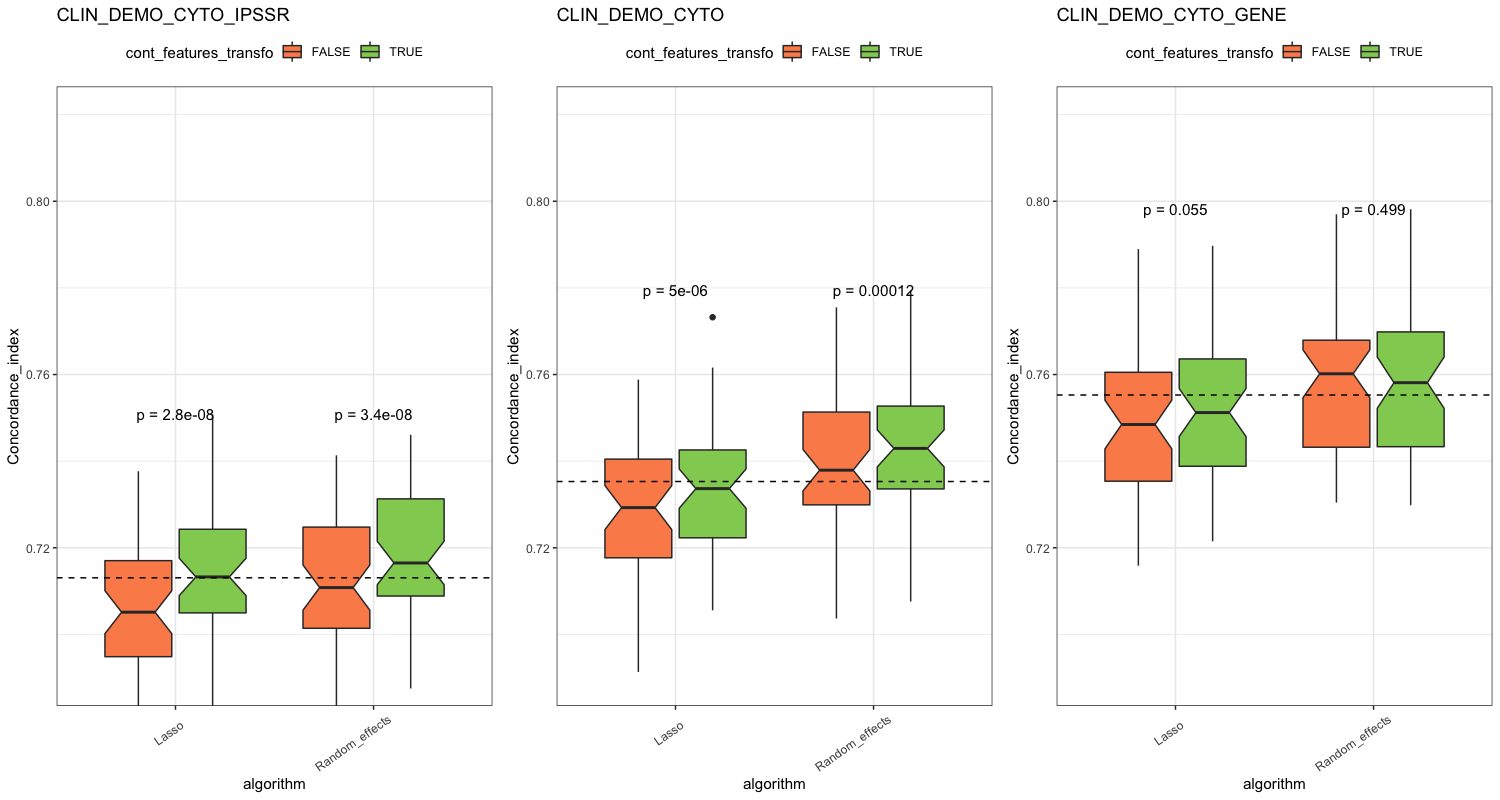

In [449]:
CLIN_DEMO_CYTO_IPSSR<-read.table("../../data/final_dataset/prediction/predictive_algo_transformed_cont_feat_CLIN_DEMO_CYTO_IPSSR.tsv",sep='\t')
CLIN_DEMO_CYTO<-read.table("../../data/final_dataset/prediction/predictive_algo_transformed_cont_feat_CLIN_DEMO_CYTO.tsv",sep='\t')
CLIN_DEMO_CYTO_GENE<-read.table("../../data/final_dataset/prediction/predictive_algo_transformed_cont_feat_CLIN_DEMO_CYTO_GENE.tsv",sep='\t')

CLIN_DEMO_CYTO_IPSSR<-melt(CLIN_DEMO_CYTO_IPSSR,c('model','cont_features_transfo'))
colnames(CLIN_DEMO_CYTO_IPSSR)<-c('model','cont_features_transfo','algorithm','Concordance_index')
CLIN_DEMO_CYTO<-melt(CLIN_DEMO_CYTO,c('model','cont_features_transfo'))
colnames(CLIN_DEMO_CYTO)<-c('model','cont_features_transfo','algorithm','Concordance_index')
CLIN_DEMO_CYTO_GENE<-melt(CLIN_DEMO_CYTO_GENE,c('model','cont_features_transfo'))
colnames(CLIN_DEMO_CYTO_GENE)<-c('model','cont_features_transfo','algorithm','Concordance_index')

set_notebook_plot_size(15,8)
g1 <- ggplot(CLIN_DEMO_CYTO_IPSSR,aes(x=algorithm,y=Concordance_index)) +
    geom_boxplot(aes(fill = cont_features_transfo), notch=T)+
    scale_fill_manual(values = c('#fc8d59','#91cf60'))+
    stat_compare_means(paired = T, aes(group=cont_features_transfo), label = "p.format") +
    geom_hline(yintercept = median(CLIN_DEMO_CYTO_IPSSR$Concordance_index), linetype = 2) +
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    coord_cartesian(ylim=c(0.69, 0.82)) +
    ggtitle('CLIN_DEMO_CYTO_IPSSR')
g2 <- ggplot(CLIN_DEMO_CYTO,aes(x=algorithm,y=Concordance_index)) +
    geom_boxplot(aes(fill = cont_features_transfo), notch=T)+
    scale_fill_manual(values = c('#fc8d59','#91cf60'))+
    stat_compare_means(paired = T, aes(group=cont_features_transfo), label = "p.format") +
    geom_hline(yintercept = median(CLIN_DEMO_CYTO$Concordance_index), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    coord_cartesian(ylim=c(0.69, 0.82)) +
    ggtitle('CLIN_DEMO_CYTO')
g3 <- ggplot(CLIN_DEMO_CYTO_GENE,aes(x=algorithm,y=Concordance_index)) +
    geom_boxplot(aes(fill = cont_features_transfo), notch=T)+
    scale_fill_manual(values = c('#fc8d59','#91cf60'))+
    stat_compare_means(paired = T, aes(group=cont_features_transfo), label = "p.format") +
    geom_hline(yintercept = median(CLIN_DEMO_CYTO_GENE$Concordance_index), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    coord_cartesian(ylim=c(0.69, 0.82)) +
    ggtitle('CLIN_DEMO_CYTO_GENE')

grid.draw(grid.arrange(g1,g2,g3,nrow=1))

    

Transforming continuous features significantly improves the concordance index, except for the model *CLIN DEMO CYTO GENE*  and Random effects which seems to be insensible to this modification. It is also borderline not significant with Lasso.

Let's look at the transformations across cross validations of the continuous features to see if the transformations are consistent:

In [439]:
transformations <- read.table("../../data/final_dataset/prediction/predictive_algo_transformed_cont_feat_funct.tsv",sep='\t',stringsAsFactors = FALSE)
head(transformations,2)

ANC                                                           
2 0+0.0147006005313773*((x/10)^-1)+0.200600945241491*log((x/10))
3 0+0.0919759074685484*((x/10)^1)                               
  BM_BLAST                              
2 0+0.614505108368442*(((x + 0.1)/10)^1)
3 0+0.642130574677662*(((x + 0.1)/10)^1)
  HB                                                            
2 0+-0.637937774595834*((x/10)^3)                               
3 0+-19.4094059935547*((x/10)^-0.5)+-12.114161907927*log((x/10))
  PLT                                                                          
2 0+-0.394208937922752*((x/100)^1)+0.0306442160085674*((x/100)^2)              
3 0+-0.584255400403152*((x/100)^1)+0.212439310612892*((x/100)^1 * log((x/100)))
  WBC                                                            
2 0+0.0395202044049554*((x/10)^1)                                
3 0+0.00259405090530587*((x/10)^-2)+0.188066861371858*log((x/10))

In [450]:
transformations_null<-data.frame(ANC=nrow(transformations[transformations$ANC=='0',]),
                                 BM_BLAST=nrow(transformations[transformations$BM_BLAST=='0',]),
                                 HB=nrow(transformations[transformations$HB=='0',]),
                                 PLT=nrow(transformations[transformations$PLT=='0',]),
                                 WBC=nrow(transformations[transformations$WBC=='0',]))
rownames(transformations_null)<-"Proportion of null transformations"
transformations_null/nrow(transformations)

ANC  BM_BLAST HB PLT WBC 
Proportion of null transformations 0.24 0        0  0   0.44

In [442]:
# Global transformation functions

transf_anc<-function(ANC){return(7.512e-05*(ANC/10)^-2)}

transf_hb<-function(HB){return(-1.869e+01*((HB/10)^-0.5)-1.170e+01*log((HB/10)))}

transf_plt<-function(PLT){return(2.874e-02*((PLT/100)^2)-3.690e-01*(PLT/100))}

transf_bm<-function(BM_BLAST){return(6.233e-01*(BM_BLAST + 0.1)/10)}

transf_wbc<-function(WBC){return(4.430e-01*((WBC/10)^0.5))}

transf<-c(transf_anc,transf_bm,transf_hb,transf_plt,transf_wbc)
names(transf)<-c('ANC','BM_BLAST','HB','PLT','WBC')

In [443]:
g<-gList()
limits<-data.frame(features=c('ANC','WBC'),x=c(50,150))


for(feat in c('ANC','BM_BLAST','HB','PLT','WBC')){
    funct <- data.frame(x=ddgo[,feat])
    exp <- paste0('exp_',1:nrow(transformations))
    rm_exp<-c()
    for(i in 1:nrow(transformations)){
        if(transformations[i,feat]=='0'){
            rm_exp<-c(rm_exp,i+1)
        }
        tmp_func <- function(x){return(eval(parse(text=transformations[i,feat])))}
        funct[,exp[i]] <- tmp_func(funct$x)
    }
    
    if (!all(is.na(rm_exp))){funct<-funct[,-rm_exp]}
    
    
    funct<-melt(funct,'x')
    funct$exp <- sapply(funct$variable,function(x){return(as.numeric(strsplit(as.character(x),'_')[[1]][2]))})
    
    
    g_funct<- ggplot(funct,aes(x,value,color=exp))+
                        geom_point()+
                        theme(legend.position = 'none',)+
                        scale_color_gradient2(low="#d7191c", high="#1a9641",mid = "#ffffbf",midpoint = 25)+
                        ggtitle(paste('Transformation functions for',feat))+
                        xlab(feat)
    
    if (feat %in% limits$features){
        xlim<-limits$x[limits$features==feat]
        g[[feat]]<-g_funct + coord_cartesian(xlim=c(0, xlim)) 
        
    } else {
        g[[feat]]<-g_funct
    }
    
    
    
}

g[['ANC']]<-g[['ANC']]+geom_point(aes(x,transf['ANC'][[1]](x)),colour='blue')
g[['BM_BLAST']]<-g[['BM_BLAST']]+geom_point(aes(x,transf['BM_BLAST'][[1]](x)),colour='blue')
g[['HB']]<-g[['HB']]+geom_point(aes(x,transf['HB'][[1]](x)),colour='blue')
g[['PLT']]<-g[['PLT']]+geom_point(aes(x,transf['PLT'][[1]](x)),colour='blue')
g[['WBC']]<-g[['WBC']]+geom_point(aes(x,transf['WBC'][[1]](x)),colour='blue')



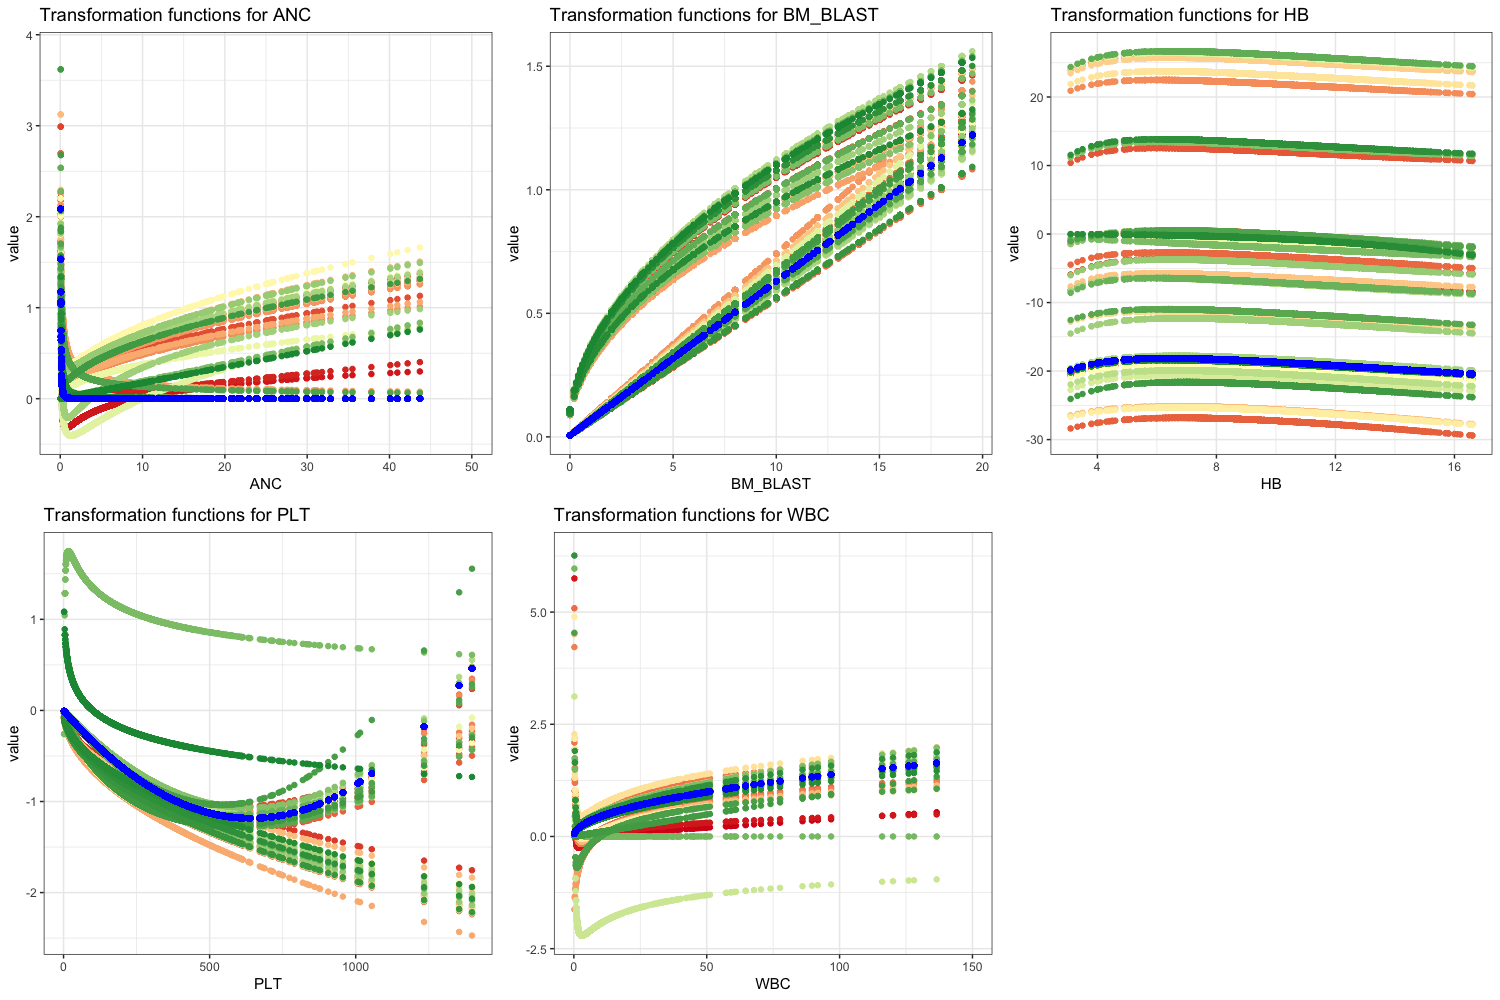

In [444]:
set_notebook_plot_size(15,10)
grid.draw(grid.arrange(grobs=g,ncol=3))

Each point color (from red to green) represents one cross validation, and the blue one represent the transformation found on the whole dataset. We see that the transformations are pretty consistent across cross validations, and the global transformations seem to be the *range* of all transformations, even tough `ANC` and `HB` are a bit different.


We illustrated the need to transform continuous features in this section because it helps to get a better predictive power, but also it is important to check for transformation if we want to respect the proportional hazards assumption from the Cox model.


# 3. Proportional Hazards assumption

The proportional hazards assumption can be checked using statistical tests and graphical diagnostics based on the scaled Schoenfeld residuals, which represent the difference between the observed covariate and the expected given risk set at that time. In principle, the Schoenfeld residuals are independent of time. A plot that shows a non-random pattern against time is evidence of violation of the proportional hazards assumption.

If there are few outliers, the test of Grambsch and Therneau (1994) should be done using the untransformed time (`transform='identity'`). Otherwise, the rank
transformation is a better choice. Here we consider there are few outliers to perform the test.

However, Park and Hendry (2015) showed that the decision of time transformations can have profound implications for the conclusions reached, so the result is to be nuanced.

We will verify this hypothesis on the model *CLIN DEMO CYTO UPD GENE NMUT MDS_TYPE*.

In [458]:
prep.CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE = PrepareDesignMatrix(data=ddgo,
                    use.nuisance=TRUE,
                    response.name=c("os_sample_years","os_status"),
                    feature.category.name = c("clin","age","clinicalother","cytoaberrations","upd","mutations","mds_type"),
                    list.features=list.features)

data<-data.frame(cbind(prep.CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$design,prep.CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$response))
data$ANC<-transf_anc(data$ANC)
data$HB<- transf_hb(data$HB)
data$BM_BLAST<-transf_bm(data$BM_BLAST)
data$PLT<-transf_plt(data$PLT)
data$WBC<-transf_wbc(data$WBC)

suppressWarnings(
res.cox <- coxph(Surv(time, status) ~ ., data =  data))

In [466]:
suppressWarnings(test.ph <- cox.zph(res.cox,transform='identity'))

In [467]:
test.ph$table['GLOBAL','p']

[1] 0.9826533

The global test is not statistically significant (`p=0.98`), meaning we could confirm the null hypothesis, which is that the hazard rate of an individual is relatively constant in time. 

Besides, very few features fail the PH assumption. Let's look at the graphs of the scaled Schoenfeld residuals against the transformed time for the features that failed the test (`p<0.05`):

 [1] "PLT"    "AGE"    "del5q"  "del1p"  "del5"   "r_9_9"  "CTCF"   "GATA1" 
 [9] "JARID2" "KDM6A"  "RAD21"  "SF3B1" 


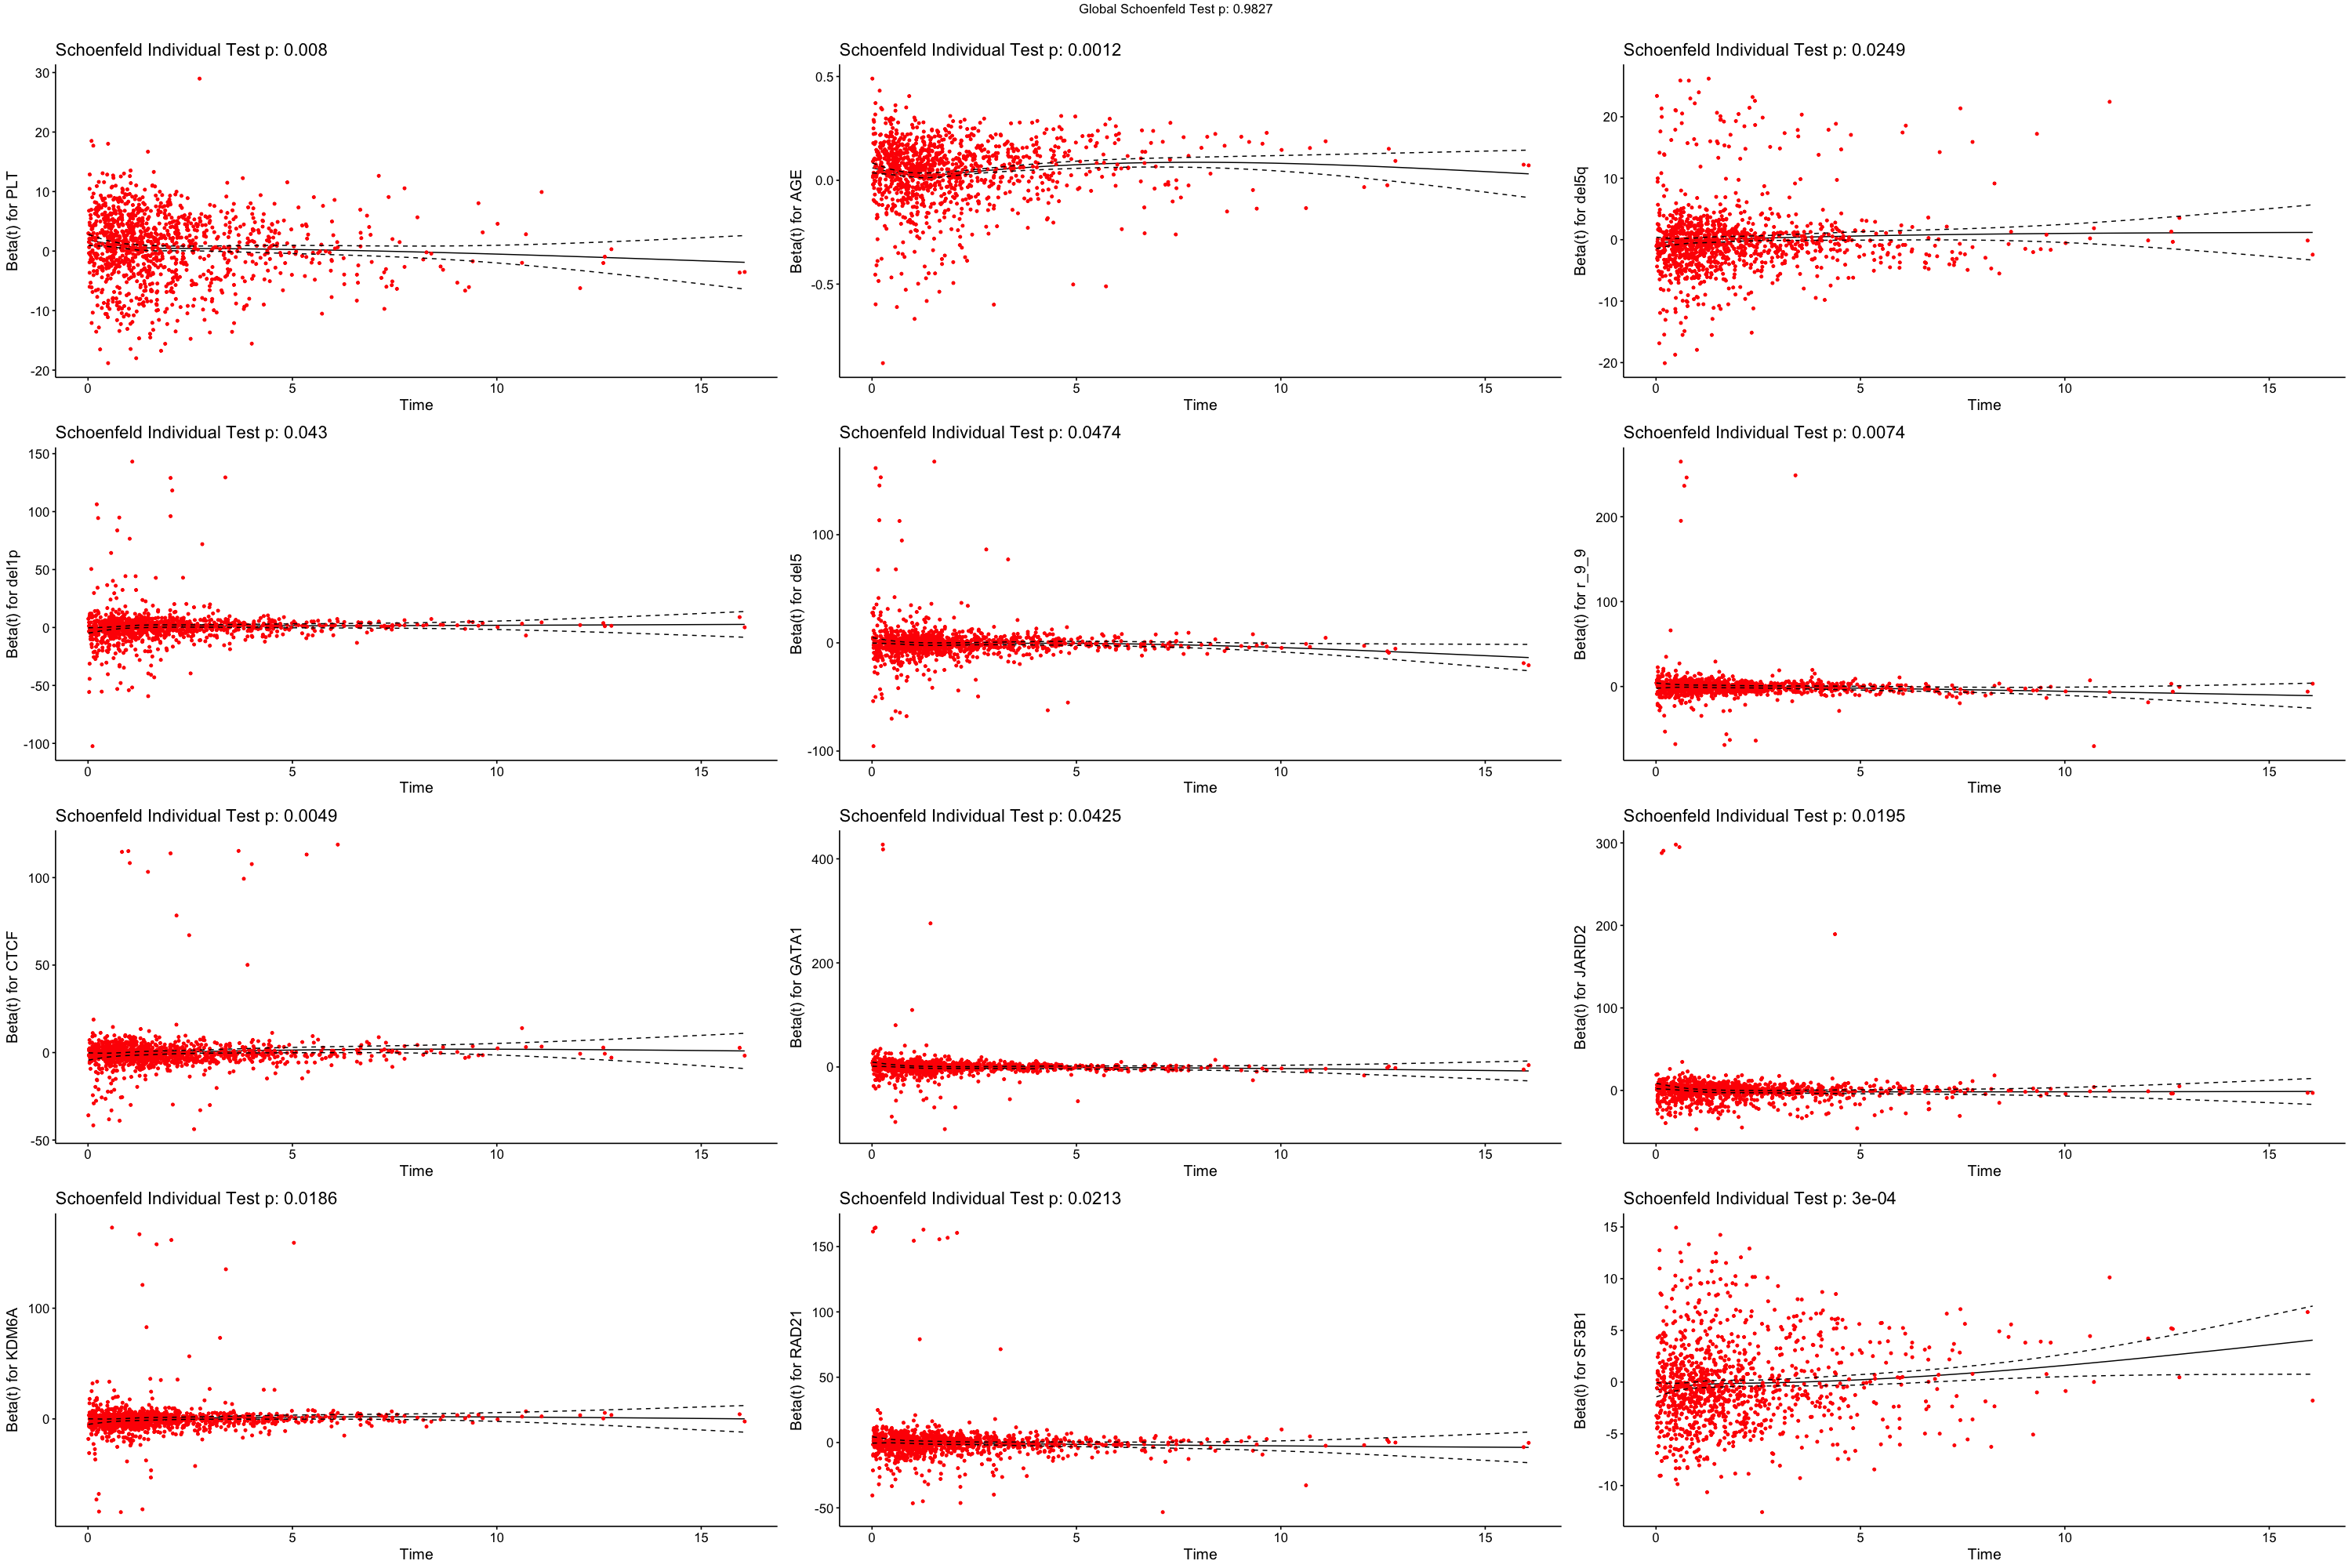

In [461]:
set_notebook_plot_size(30,20)
var<-rownames(test.ph$table[test.ph$table[,'p']<0.05,])
var<-var[!is.na(var)]
print(var[1:(length(var)-1)])
ggcoxzph(test.ph,var=var[1:(length(var)-1)]) 

For large datasets we can sometimes have a "significant" p-value but good agreement with proportional hazards. The Cox model gives an average hazard ratio, averaged over time. When proportional hazards does not hold, the average may still be useful, or not, depending on the degree of change over time.

We do have a large dataset here, and the previous plots show that the degree of change over time is small for the significant p-values, so as the global test isn't we can agree with proportional hazards with an approximation.

# 4. Comparison of models and algorithms

Our goal is to find the best couple (model, algorithm), so we  compare here different predictive algorithms on a few models to see if one arises from the others. The predictive algorithms used here are: **Lasso**, **Random effects modelling** and **Random survival forests** (500 trees).

The different models used to compare algorithms are:
- IPSSR SCORE
- IPSSR SCORE + GENE
- IPSSR SCORE + UPD
- IPSSR SCORE + UPD + GENE
- IPSSR SCORE + UPD + GENE + NMUT
- IPSSR SCORE + UPD + GENE + MDS_TYPE
- IPSSR SCORE + UPD + GENE + NMUT + MDS_TYPE
- CLIN + DEMO + CYTO
- CLIN + DEMO + CYTO + GENE
- CLIN + DEMO + CYTO + UPD
- CLIN + DEMO + CYTO + UPD + GENE
- CLIN + DEMO + CYTO + UPD + GENE + NMUT
- CLIN + DEMO + CYTO + UPD + GENE + MDS_TYPE
- CLIN + DEMO + CYTO + UPD + GENE + NMUT + MDS_TYPE

We perform 10 5-fold cross validations (with a ratio of 4/5 for each training set and 1/5 for each testing set), so we will have 50 training sets and 50 testing sets, so 50 concordance index values for each couple (model, algorithm). Continuous features are also transformed the same way as described before: for each training set, the transformation is found, and then applied to the corresponding testing set, in order to avoid overfitting.

In [507]:
algo_CLIN_DEMO_CYTO <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_GENE <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_GENE.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE.tsv',sep='\t')
algo_IPSSR_SCORE <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE.tsv',sep='\t')
algo_IPSSR_SCORE_GENE <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_GENE.tsv',sep='\t')
algo_IPSSR_SCORE_UPD <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_MDS_TYPE <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_MDS_TYPE.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_NMUT <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_NMUT.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE.tsv',sep='\t')

df_models <- rbind(
    algo_CLIN_DEMO_CYTO,
    algo_CLIN_DEMO_CYTO_GENE,
    algo_CLIN_DEMO_CYTO_UPD,
    algo_CLIN_DEMO_CYTO_UPD_GENE,
    algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE,
    algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT,
    algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE,
    algo_IPSSR_SCORE,
    algo_IPSSR_SCORE_GENE,
    algo_IPSSR_SCORE_UPD,
    algo_IPSSR_SCORE_UPD_GENE,
    algo_IPSSR_SCORE_UPD_GENE_MDS_TYPE,
    algo_IPSSR_SCORE_UPD_GENE_NMUT,
    algo_IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE
)

df_models <- melt(df_models,'model')
colnames(df_models) <- c('model','algorithm','C_index')

## 4.1 IPSSR models
First let's compare all models built on the base of the IPSSR score, algorithm by algorithm:

In [480]:
df_ipssr <- df_models[grep('IPSSR',df_models$model),]
df_ipssr$model<-factor(df_ipssr$model,levels= c('IPSSR_SCORE',
                                                'IPSSR_SCORE_UPD',
                                                'IPSSR_SCORE_GENE',
                                                'IPSSR_SCORE_UPD_GENE',
                                                'IPSSR_SCORE_UPD_GENE_MDS_TYPE',
                                                'IPSSR_SCORE_UPD_GENE_NMUT',
                                                'IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE'))

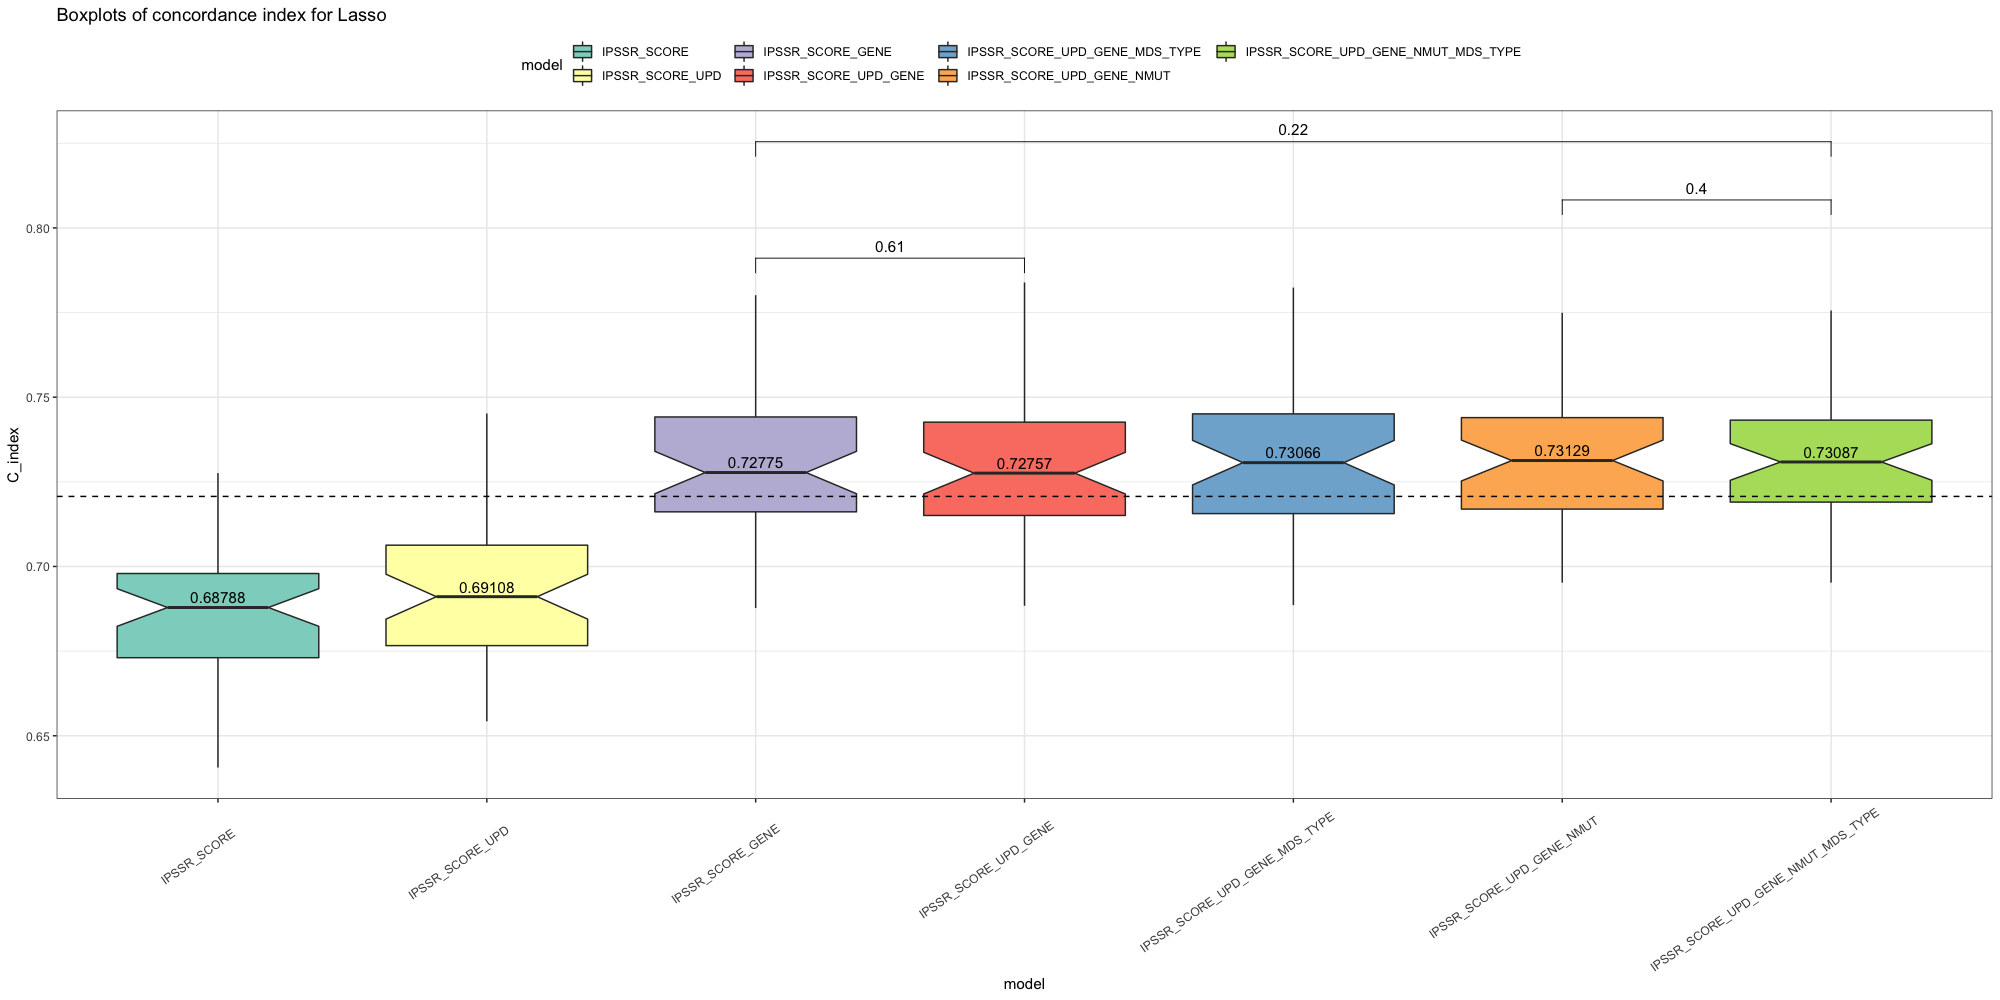

In [481]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_ipssr[df_ipssr$algorithm=='Lasso',]$model))
medians$med <- signif(sapply(levels(df_ipssr[df_ipssr$algorithm=='Lasso',]$model),function(x){return(median(df_ipssr[df_ipssr$algorithm=='Lasso',]$C_index[df_ipssr[df_ipssr$algorithm=='Lasso',]$model==as.character(x)]))}),5)
ggplot(df_ipssr[df_ipssr$algorithm=='Lasso',],aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(3,4),c(6,7),c(3,7))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for Lasso') +
            geom_hline(yintercept = median(df_ipssr[df_ipssr$algorithm=='Lasso',]$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.003, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Adding the genes gives a significant improvement in the median concordance index, and the other features are not adding anything on top of that for the algorithm **Lasso**.

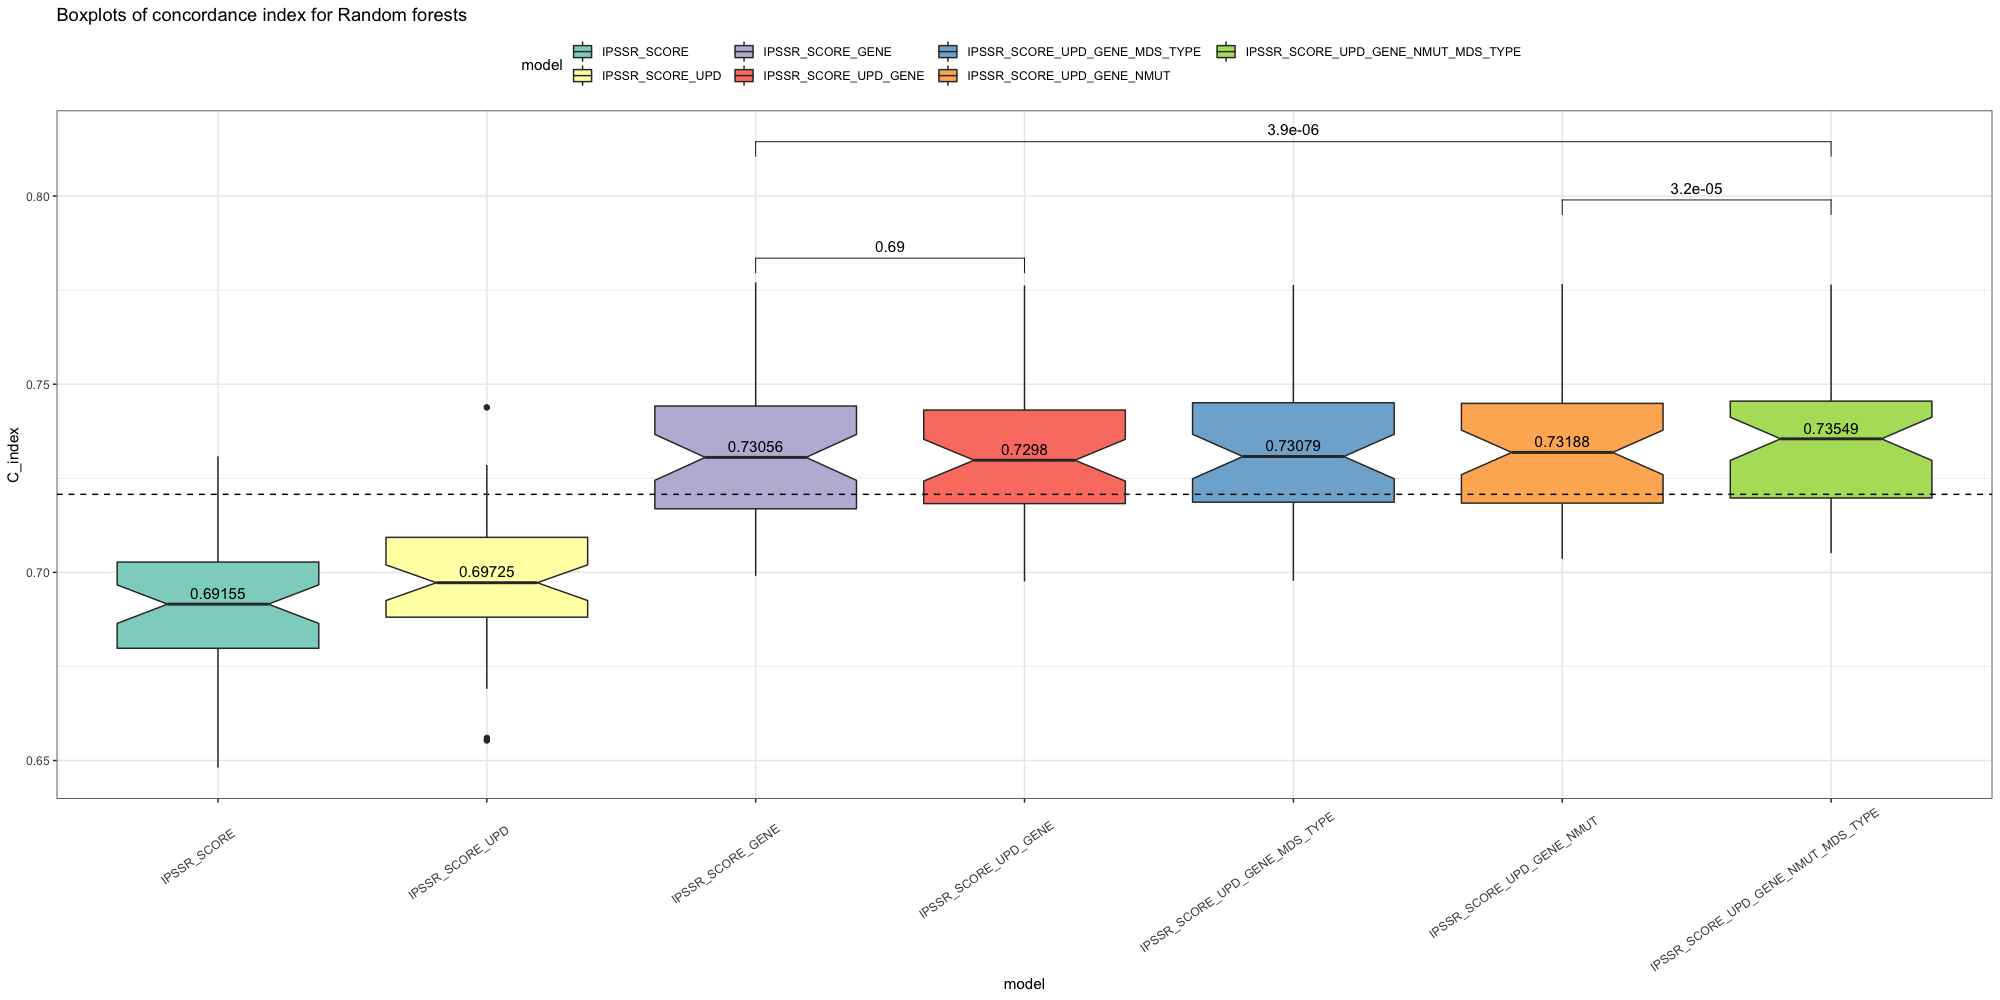

In [482]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_ipssr[df_ipssr$algorithm=='RFS',]$model))
medians$med <- signif(sapply(levels(df_ipssr[df_ipssr$algorithm=='RFS',]$model),function(x){return(median(df_ipssr[df_ipssr$algorithm=='RFS',]$C_index[df_ipssr[df_ipssr$algorithm=='RFS',]$model==as.character(x)]))}),5)
ggplot(df_ipssr[df_ipssr$algorithm=='RFS',],aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(3,4),c(6,7),c(3,7))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for Random forests') +
            geom_hline(yintercept = median(df_ipssr[df_ipssr$algorithm=='RFS',]$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.003, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Same for **Random forests**, we get a significant improvement by adding genes, but the other features such as `MDS_TYPE` or `NMUT` give another improvement.

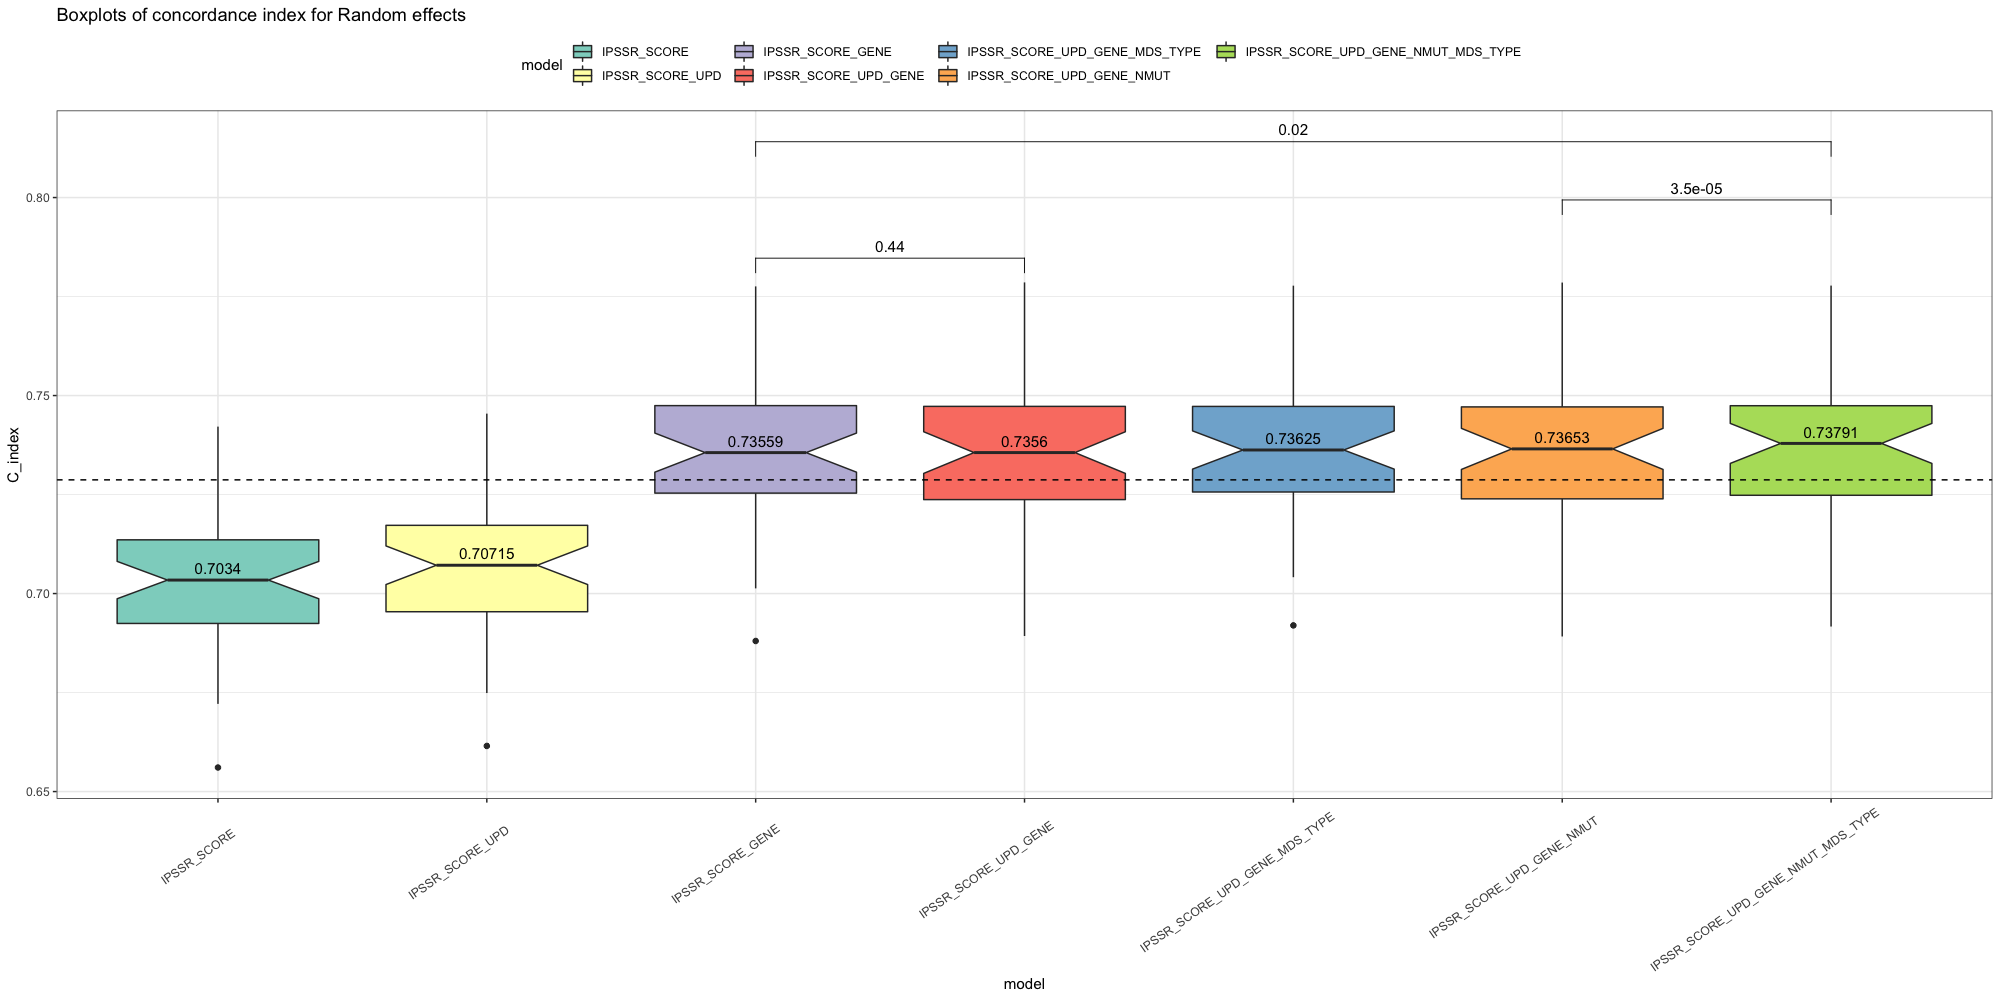

In [483]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_ipssr[df_ipssr$algorithm=='RFX',]$model))
medians$med <- signif(sapply(levels(df_ipssr[df_ipssr$algorithm=='RFX',]$model),function(x){return(median(df_ipssr[df_ipssr$algorithm=='RFX',]$C_index[df_ipssr[df_ipssr$algorithm=='RFX',]$model==as.character(x)]))}),5)
ggplot(df_ipssr[df_ipssr$algorithm=='RFX',],aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(3,4),c(6,7),c(3,7))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for Random effects') +
            geom_hline(yintercept = median(df_ipssr[df_ipssr$algorithm=='RFX',]$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.003, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Similarly to Random forests, adding those new features seems to increase the concordance index for **Random effects**, in a smaller scale however.

Let's put all those plots together to see the difference between each algorithm.

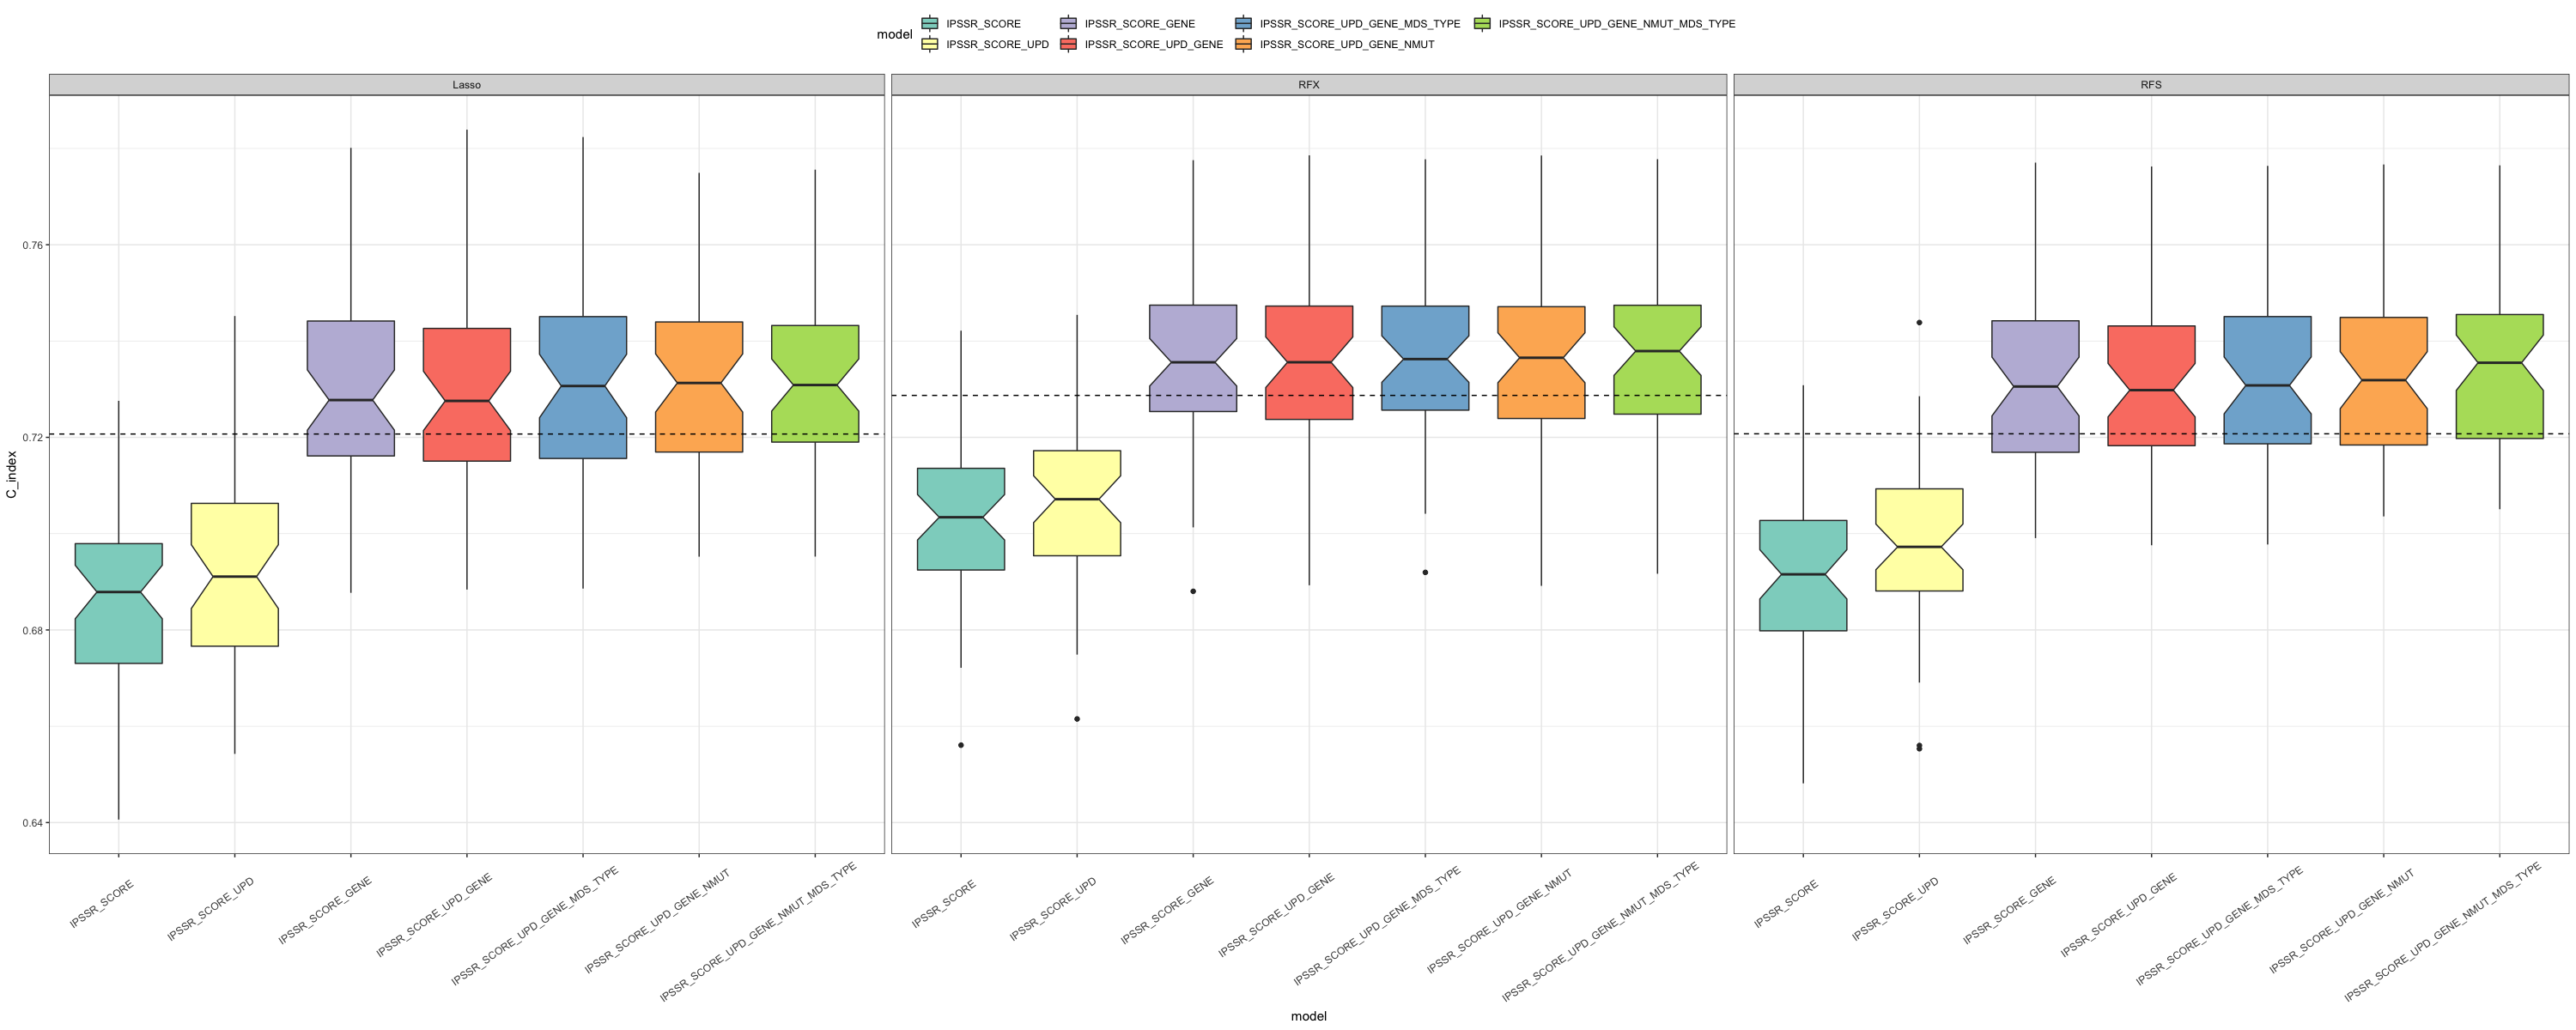

In [484]:

algorithm_medians<-c()
for( algorithm in levels(df_ipssr$algorithm)){

    algorithm_medians <- c(algorithm_medians,median(df_ipssr$C_index[df_ipssr$algorithm==as.character(algorithm)]))
}
algorithm_medians<-data.frame(algorithm=levels(df_ipssr$algorithm),Z=algorithm_medians)

set_notebook_plot_size(30,12)
ggplot(df_ipssr,aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            facet_wrap( ~ algorithm, ncol=3) +
            geom_hline(data = algorithm_medians, aes(yintercept = Z), linetype = 2)+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

The algorithm Random effects seems to perform the best, followed by both Random forests and Lasso, where it is difficult to identify which to the worst.

We can plot a heatmap of the median concordance index to better see:

In [485]:
table_res <- as.data.frame(matrix(0,nrow = 3, ncol=7))
colnames(table_res)<-levels(df_ipssr$model)
rownames(table_res)<-levels(df_ipssr$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_ipssr$C_index[df_ipssr$model==model & df_ipssr$algorithm==algo])
    }
}
table_res

IPSSR_SCORE IPSSR_SCORE_UPD IPSSR_SCORE_GENE IPSSR_SCORE_UPD_GENE
Lasso 0.6878802   0.6910769       0.7277458        0.7275665           
RFX   0.7034047   0.7071500       0.7355891        0.7355989           
RFS   0.6915523   0.6972521       0.7305575        0.7298042           
      IPSSR_SCORE_UPD_GENE_MDS_TYPE IPSSR_SCORE_UPD_GENE_NMUT
Lasso 0.7306631                     0.7312900                
RFX   0.7362525                     0.7365290                
RFS   0.7307893                     0.7318766                
      IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE
Lasso 0.7308665                         
RFX   0.7379144                         
RFS   0.7354908

In [486]:
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','C_index')
table_res$algo<-factor(table_res$algo,levels=c('Lasso','RFX','RFS'))
table_res$model<-factor(table_res$model)

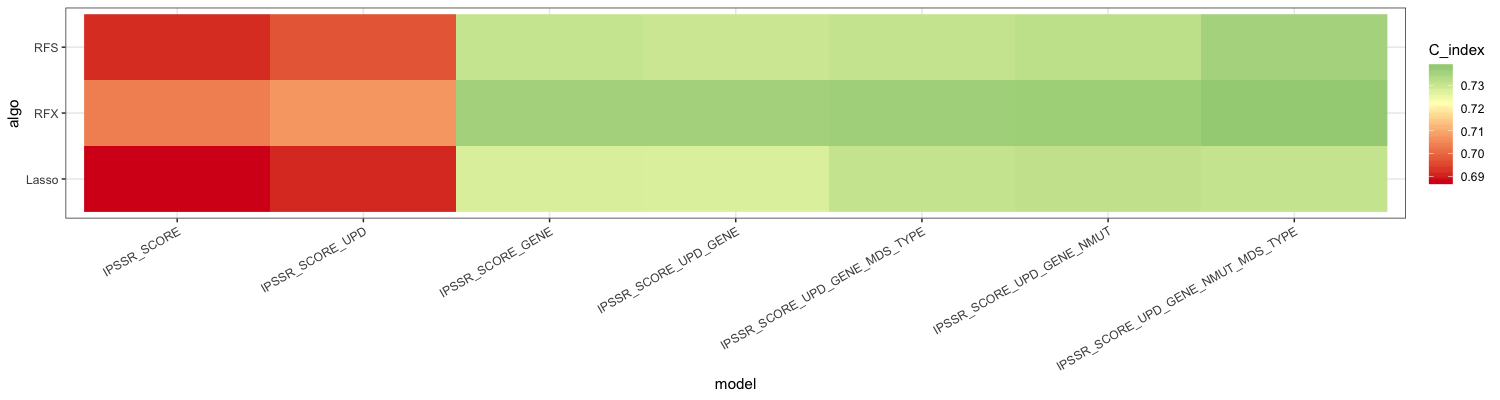

In [487]:
set_notebook_plot_size(15,4)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = C_index), show.legend = TRUE) +
    #scale_fill_gradient(low="#d73027", high="#a6d96a") +


    scale_fill_gradient2(low="#d7191c", high="#1a9641",mid = "#ffffbf",midpoint=mean(df_ipssr$C_index),na.value = 'white') +
    tilt_x_label(30) 
    

Clearly Random effects is outperforming the other two algorithms, and for the models after adding the gene it is complicated to see which one is the best.

We can summarize the predictive power of models and algorithms by calculating the median concordance index for each model across algorithms, and conversely across models for each algorithm, to see which one is performing the best overall:


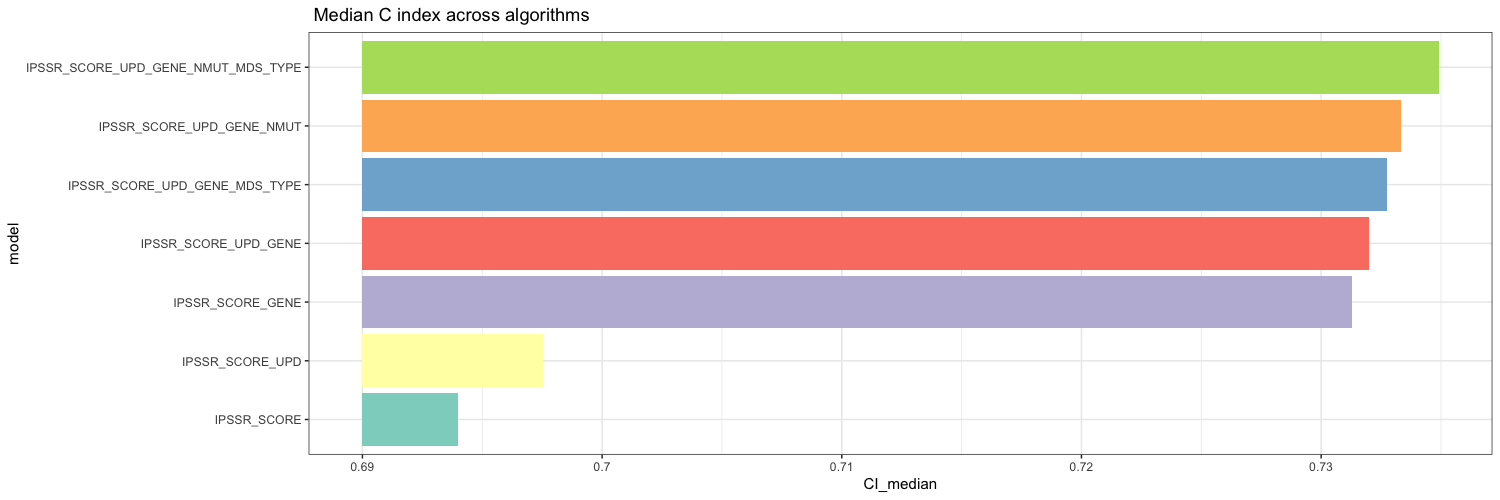

In [492]:
model_rank <- data.frame(model=unique(table_res$model))
model_rank$CI_median <- sapply(model_rank$model, function(x){return(median(df_ipssr$C_index[df_ipssr$model==x]))})
model_rank <- model_rank[order(model_rank$CI_median),]
model_rank$model <- factor(model_rank$model, levels = model_rank$model)
set_notebook_plot_size(15,5)
ggplot(model_rank) +
    geom_bar(aes(model,CI_median-0.69,fill=model),stat='identity') +
    coord_flip() +
    scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    scale_y_continuous(name='CI_median',breaks=waiver(), labels=c(0.69,0.70,0.71,0.72,0.73,0.74)) +
    theme(legend.position = 'none') +
    ggtitle(' Median C index across algorithms')

After adding the genes, all models are in a very narrow range, but the most complicated models (with more features) seem to do better than the simplest.

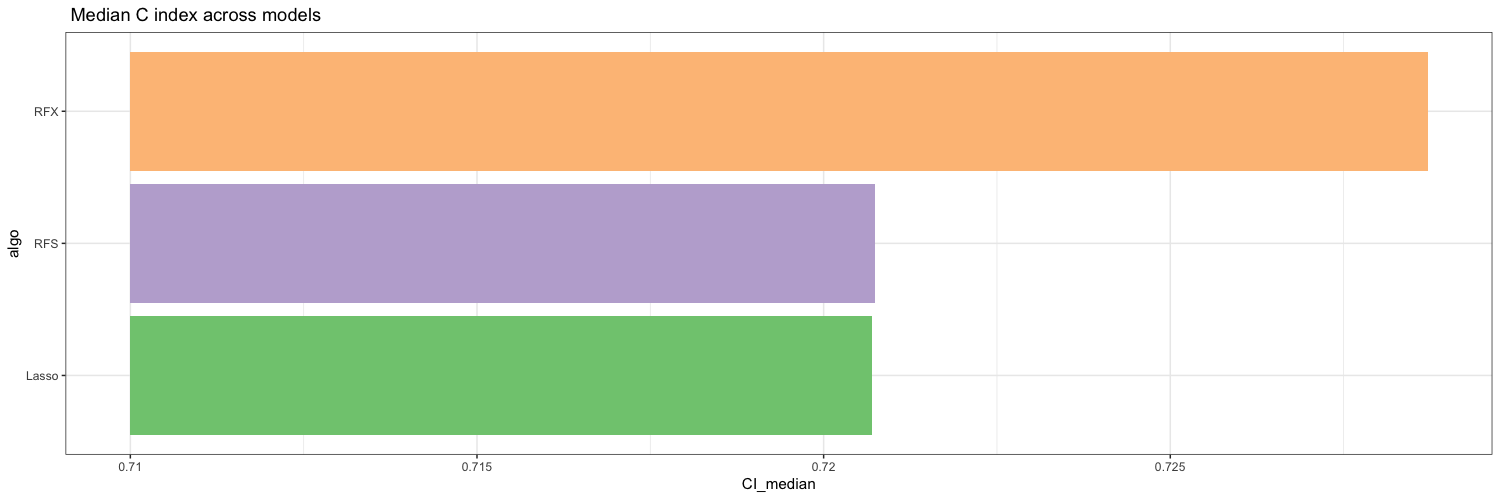

In [495]:
algo_rank <- data.frame(algo=unique(table_res$algo))
algo_rank$CI_median <- sapply(algo_rank$algo, function(x){return(median(df_ipssr$C_index[df_ipssr$algorithm==as.character(x)]))})
algo_rank <- algo_rank[order(algo_rank$CI_median),]
algo_rank$algo <- factor(algo_rank$algo, levels = algo_rank$algo)
set_notebook_plot_size(15,5)
ggplot(algo_rank) +
    geom_bar(aes(algo,CI_median-0.71,fill=algo),stat='identity') +
    coord_flip() +
    scale_fill_manual(values = c('#7fc97f','#beaed4','#fdc086'))+
    scale_y_continuous(name='CI_median',breaks=waiver(), labels=c(0.71,0.715,0.72,0.725,0.73)) +
    theme(legend.position = 'none') +
    ggtitle(' Median C index across models')


As we saw previously, Random effects is outperforming the other two algorithm, which are almost equivalent one another.

## 4.2 CLIN DEMO CYTO models
Then let's compare all models built on the base of the CLIN DEMO CYTO data, algorithm by algorithm:

In [509]:
df_clin <- df_models[grep('CLIN',df_models$model),]
df_clin$model<-factor(df_clin$model,levels = c('CLIN_DEMO_CYTO',
                                                'CLIN_DEMO_CYTO_UPD',
                                                'CLIN_DEMO_CYTO_GENE',
                                                'CLIN_DEMO_CYTO_UPD_GENE',
                                                'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE',
                                                'CLIN_DEMO_CYTO_UPD_GENE_NMUT',
                                                'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE'))

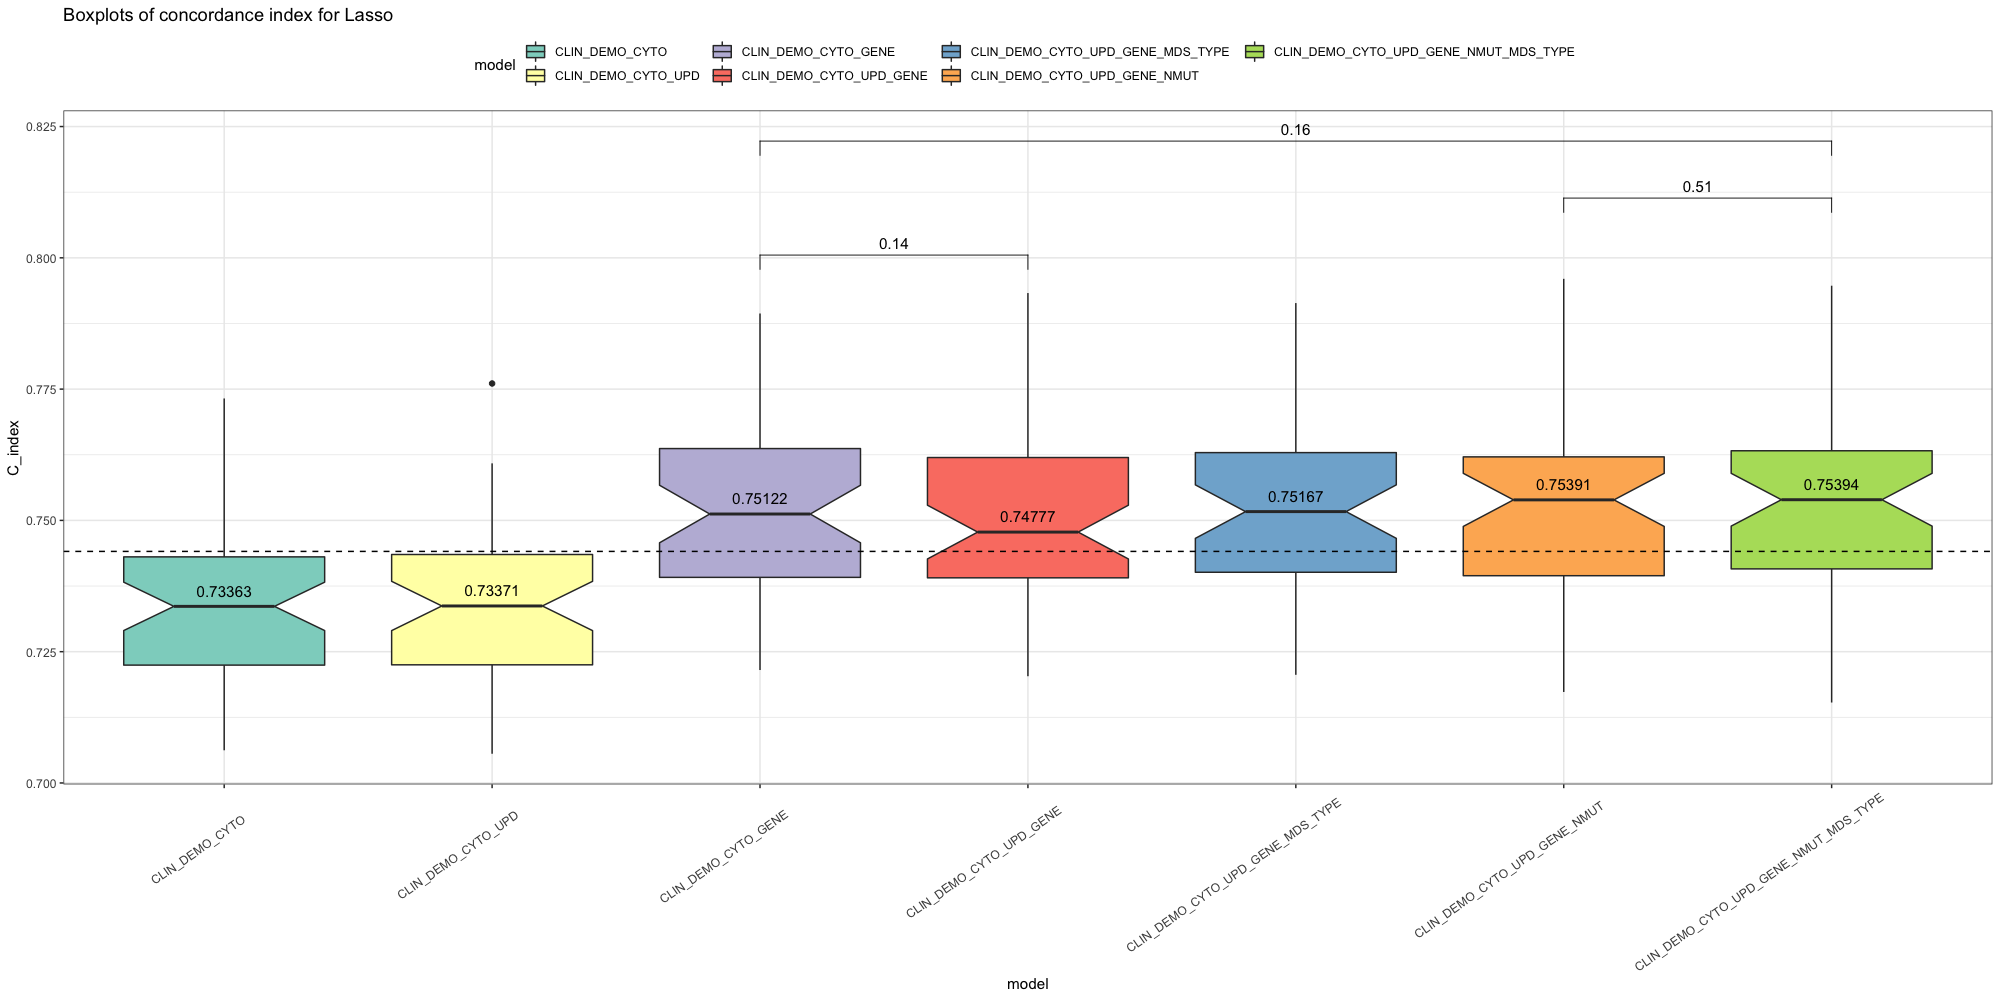

In [510]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_clin[df_clin$algorithm=='Lasso',]$model))
medians$med <- signif(sapply(levels(df_clin[df_clin$algorithm=='Lasso',]$model),function(x){return(median(df_clin[df_clin$algorithm=='Lasso',]$C_index[df_clin[df_clin$algorithm=='Lasso',]$model==as.character(x)]))}),5)
ggplot(df_clin[df_clin$algorithm=='Lasso',],aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(3,4),c(6,7),c(3,7))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for Lasso') +
            geom_hline(yintercept = median(df_clin[df_clin$algorithm=='Lasso',]$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.003, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Adding the genes for **Lasso** is improving significantly the concordance index, but the other features do not give a significant improvement.

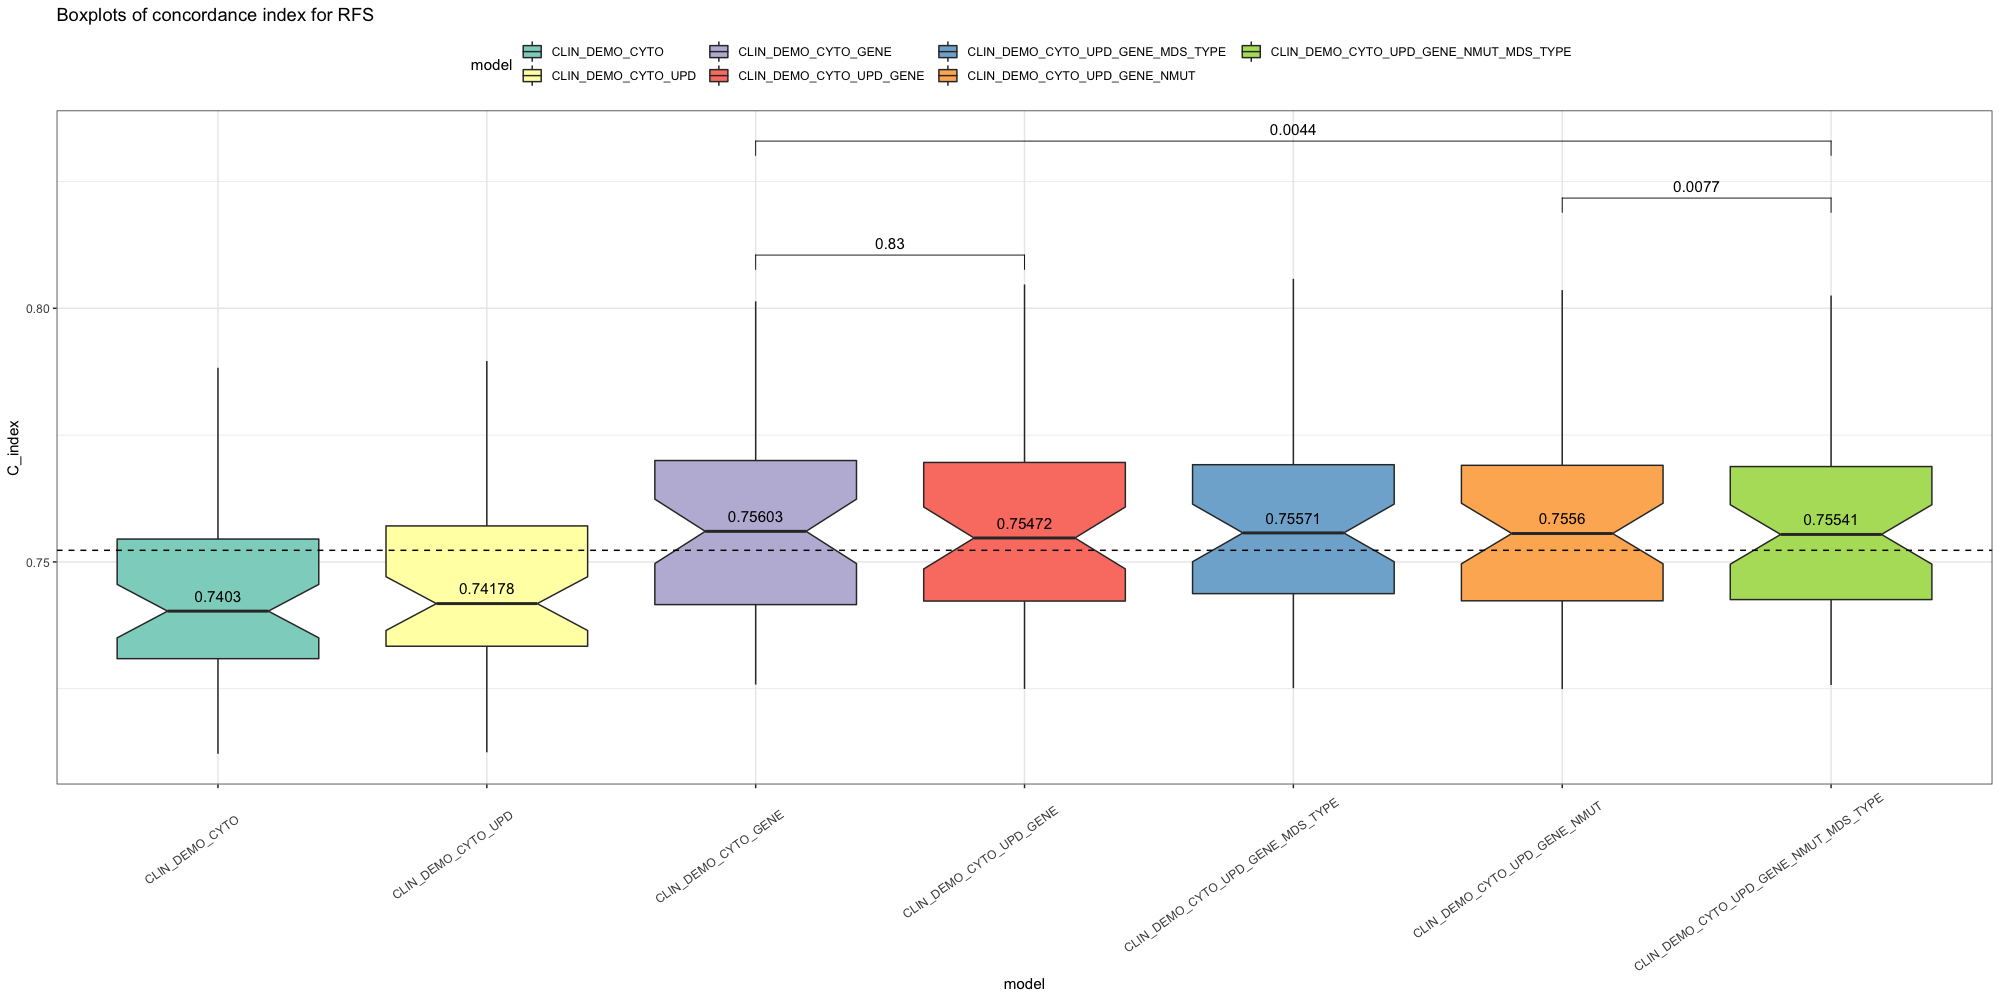

In [511]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_clin[df_clin$algorithm=='RFS',]$model))
medians$med <- signif(sapply(levels(df_clin[df_clin$algorithm=='RFS',]$model),function(x){return(median(df_clin[df_clin$algorithm=='RFS',]$C_index[df_clin[df_clin$algorithm=='RFS',]$model==as.character(x)]))}),5)
ggplot(df_clin[df_clin$algorithm=='RFS',],aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(3,4),c(6,7),c(3,7))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for RFS') +
            geom_hline(yintercept = median(df_clin[df_clin$algorithm=='RFS',]$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.003, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Again, the genes are a very important category, but it seems that the other features are not adding anything for **Random forests**, even reducing significantly the concordance index.

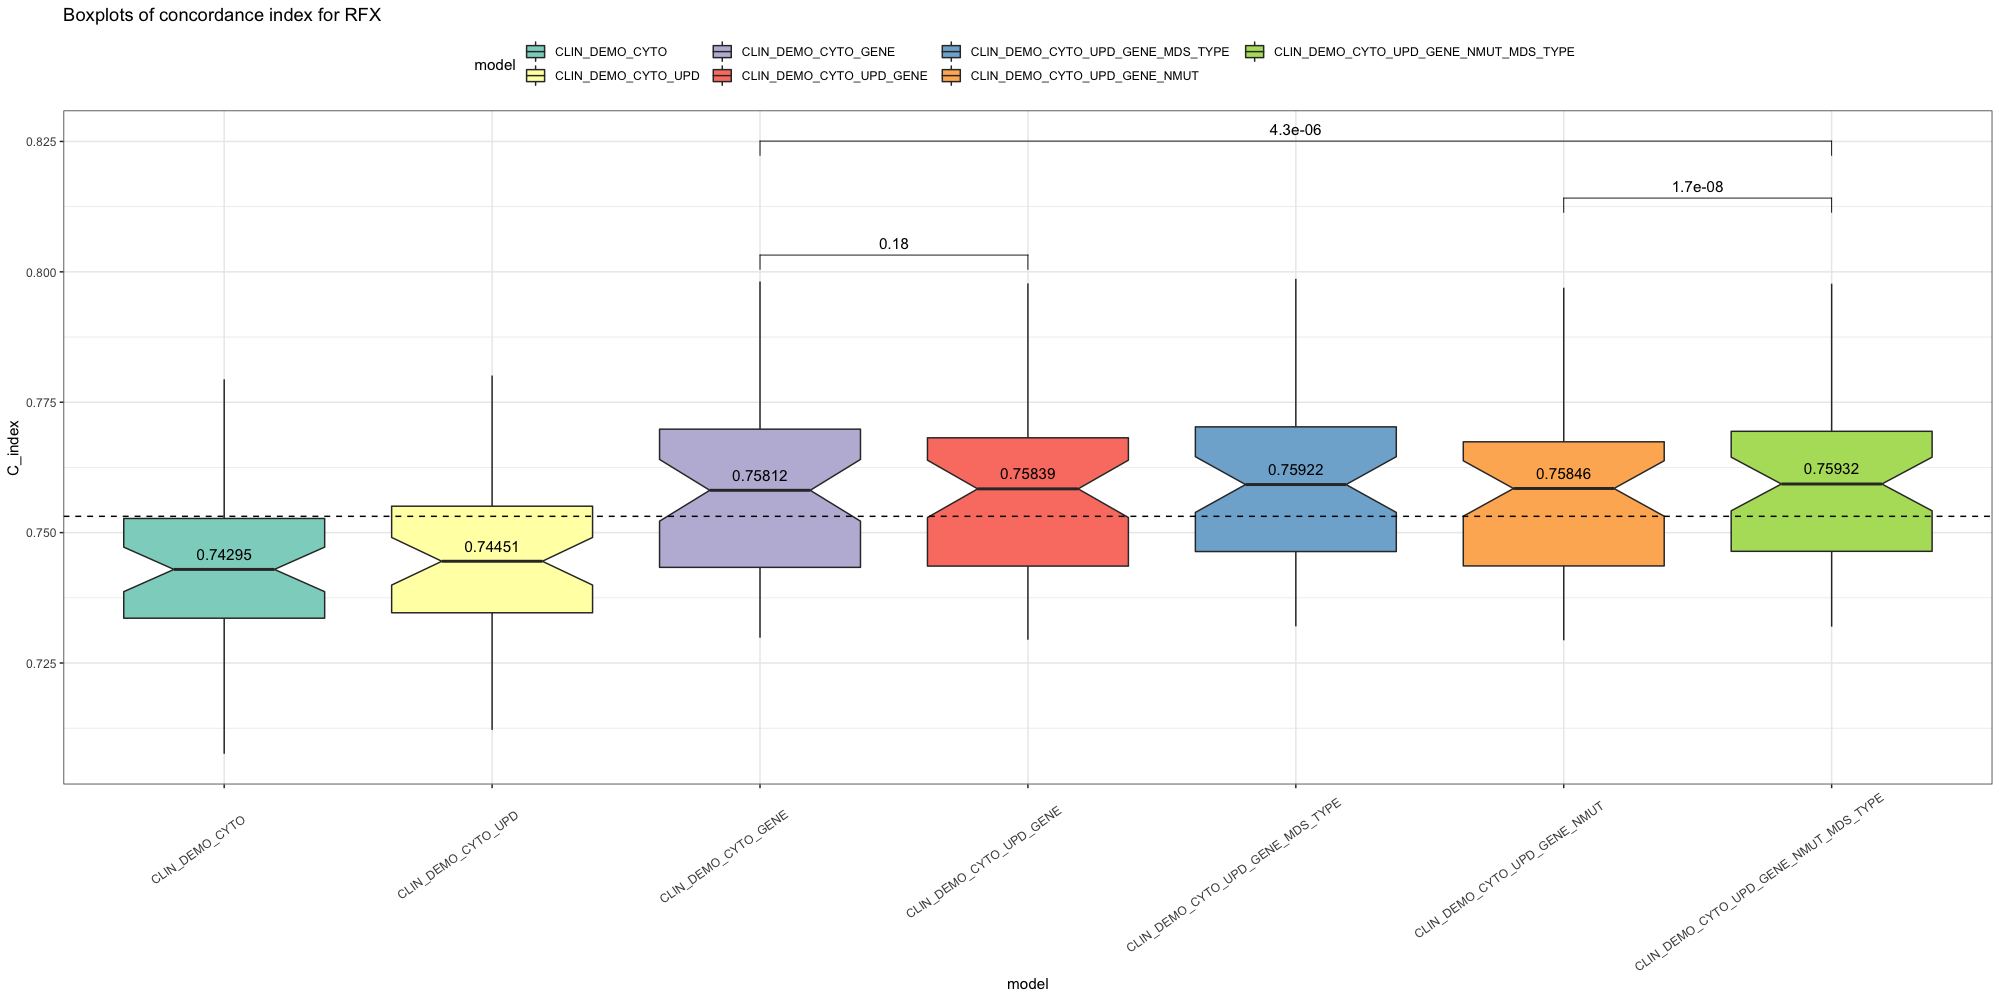

In [512]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_clin[df_clin$algorithm=='RFX',]$model))
medians$med <- signif(sapply(levels(df_clin[df_clin$algorithm=='RFX',]$model),function(x){return(median(df_clin[df_clin$algorithm=='RFX',]$C_index[df_clin[df_clin$algorithm=='RFX',]$model==as.character(x)]))}),5)
ggplot(df_clin[df_clin$algorithm=='RFX',],aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(3,4),c(6,7),c(3,7))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for RFX') +
            geom_hline(yintercept = median(df_clin[df_clin$algorithm=='RFX',]$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.003, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Similarly to Lasso, the genes are important features improving the concordance index for **Random effects**, as well as `MDS_TYPE`.

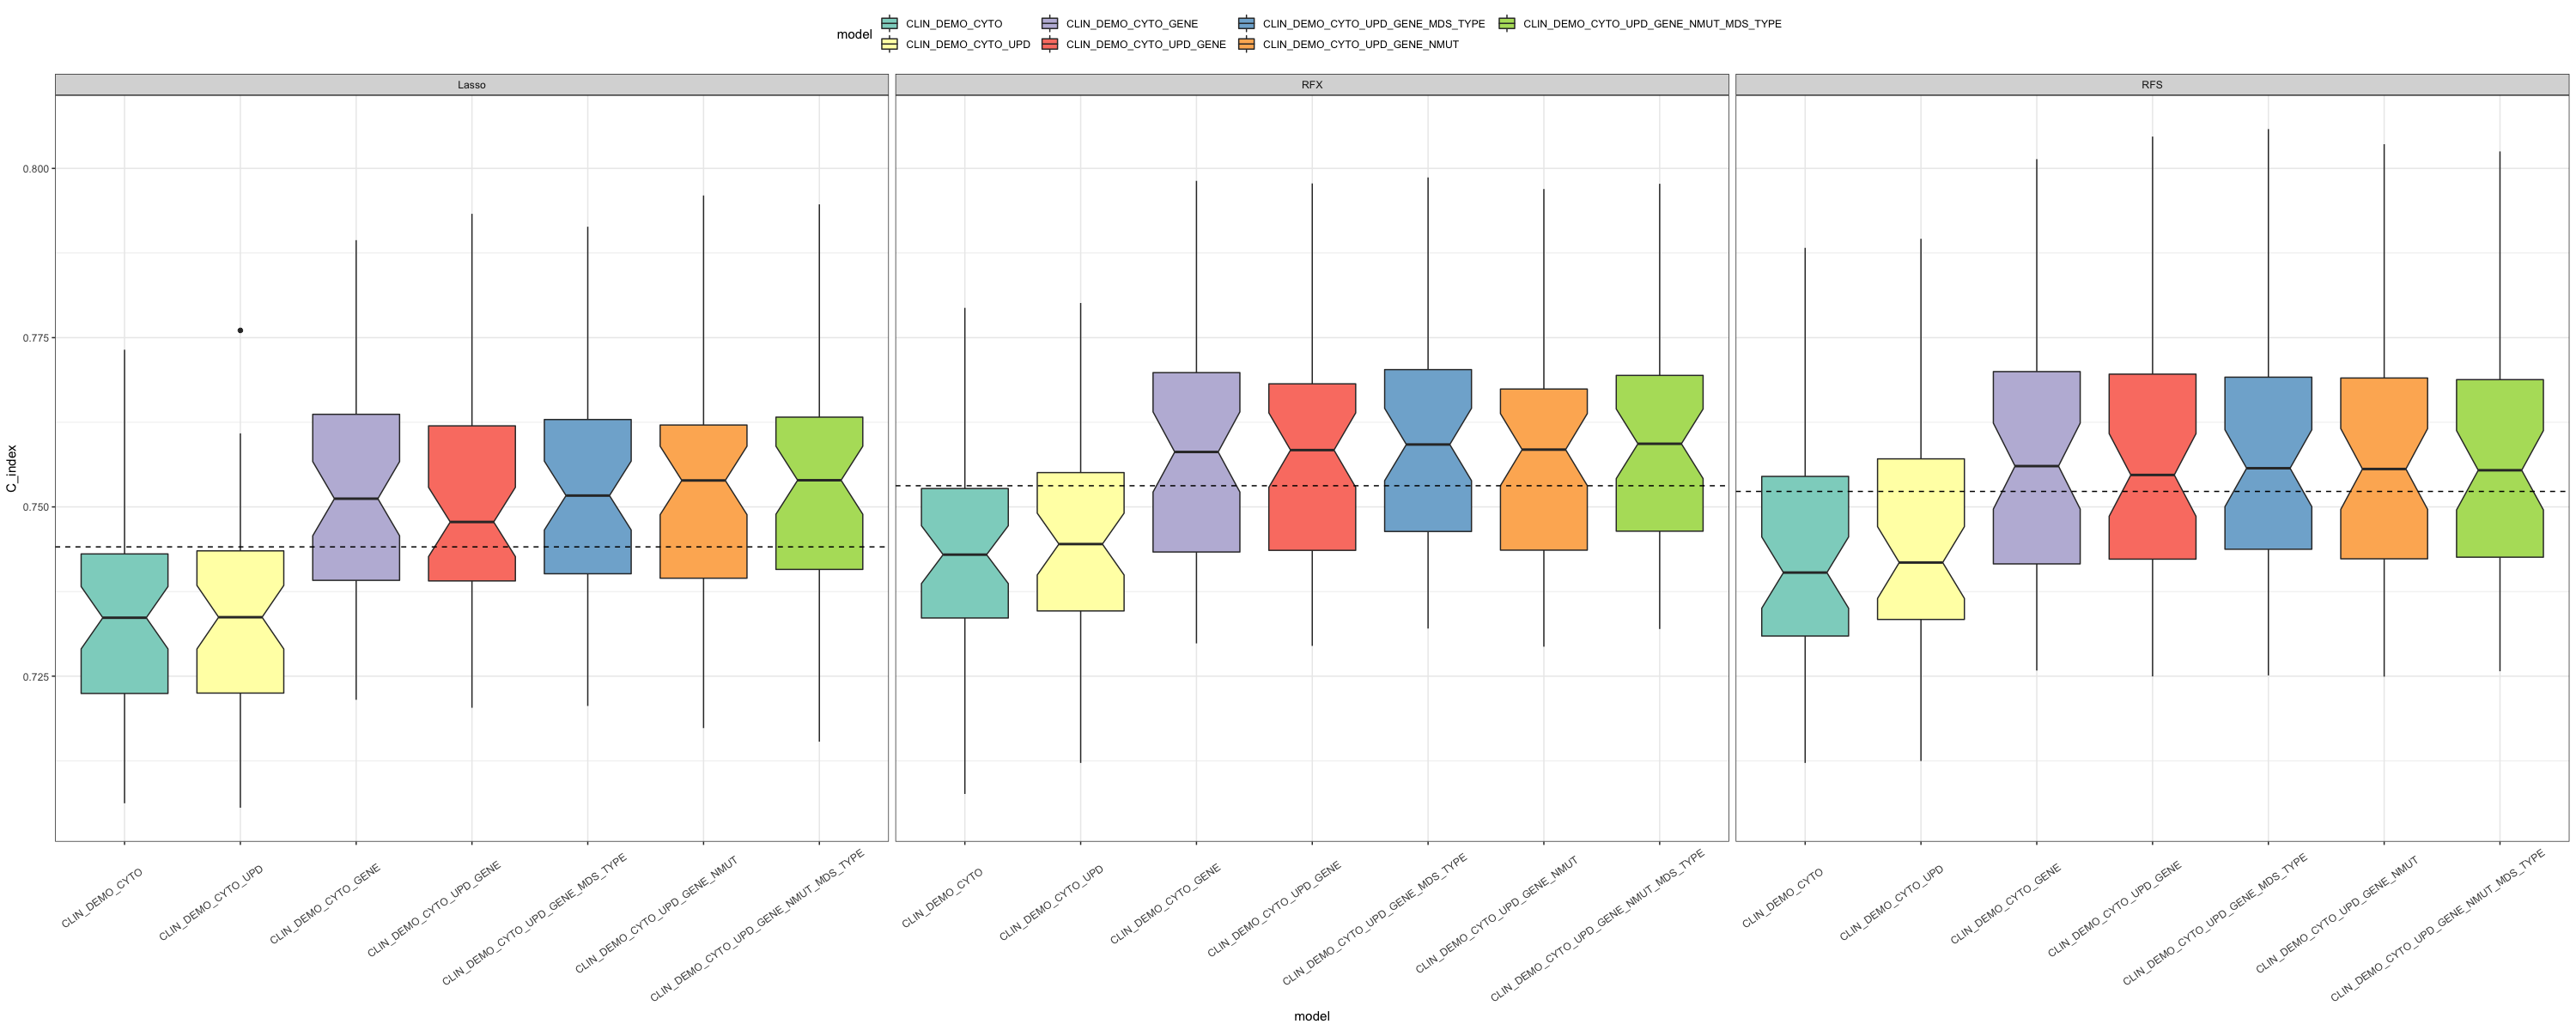

In [526]:

algorithm_medians<-c()
for( algorithm in levels(df_clin$algorithm)){

    algorithm_medians <- c(algorithm_medians,median(df_clin$C_index[df_clin$algorithm==as.character(algorithm)]))
}
algorithm_medians<-data.frame(algorithm=levels(df_clin$algorithm),Z=algorithm_medians)

set_notebook_plot_size(30,12)
ggplot(df_clin,aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            facet_wrap( ~ algorithm, ncol=3) +
            geom_hline(data = algorithm_medians, aes(yintercept = Z), linetype = 2)+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

It seems that this time Random forests is closer to random effects, but is still beaten.

Let's plot the heatmap of the median concordance index:

In [597]:
table_res <- as.data.frame(matrix(0,nrow = 3, ncol=7))
colnames(table_res)<-levels(df_clin$model)
rownames(table_res)<-levels(df_clin$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_clin$C_index[df_clin$model==model & df_clin$algorithm==algo])
    }
}
table_res

CLIN_DEMO_CYTO CLIN_DEMO_CYTO_UPD CLIN_DEMO_CYTO_GENE
Lasso 0.7336301      0.7337060          0.7512156          
RFX   0.7429478      0.7445105          0.7581162          
RFS   0.7402980      0.7417832          0.7560274          
      CLIN_DEMO_CYTO_UPD_GENE CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE
Lasso 0.7477748               0.7516736                       
RFX   0.7583931               0.7592181                       
RFS   0.7547185               0.7557139                       
      CLIN_DEMO_CYTO_UPD_GENE_NMUT CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE
Lasso 0.7539081                    0.7539384                            
RFX   0.7584631                    0.7593249                            
RFS   0.7555989                    0.7554135

In [598]:
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','C_index')
table_res$algo<-factor(table_res$algo,levels=c('Lasso','RFX','RFS'))
table_res$model<-factor(table_res$model)

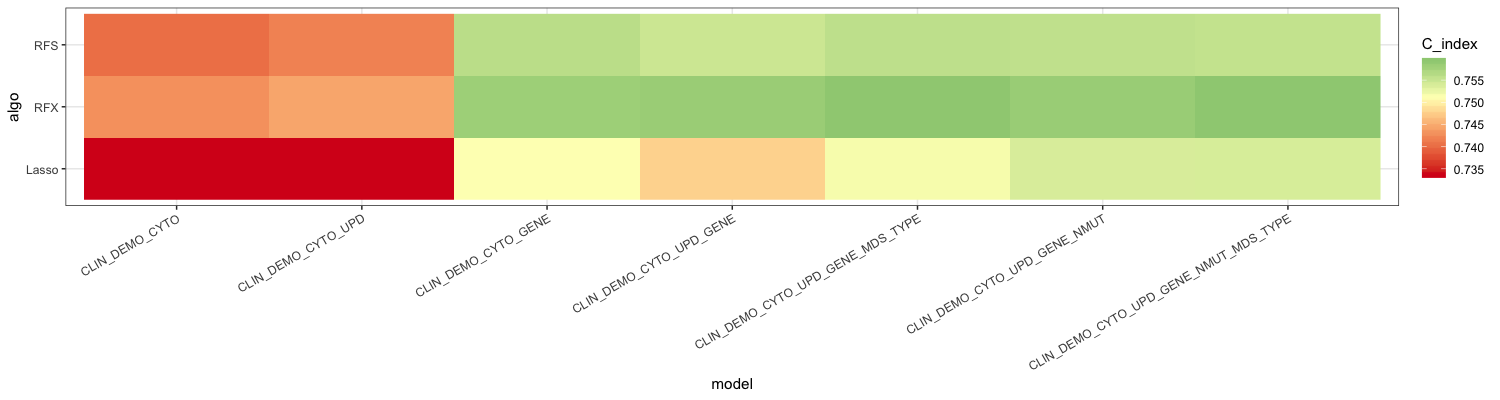

In [599]:
set_notebook_plot_size(15,4)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = C_index), show.legend = TRUE) +
    #scale_fill_gradient(low="#d73027", high="#a6d96a") +
    scale_fill_gradient2(low="#d7191c", high="#1a9641",mid = "#ffffbf",midpoint=mean(df_clin$C_index),na.value = 'white') +
    tilt_x_label(30) 
    

We see that the most complicated models tend to do better in prognosis than the other, especially *CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE*.

We can summarize the predictive power of models and algorithms by calculating the median concordance index for each model across algorithms, and conversely across models for each algorithm, to see which one is performing the best overall:

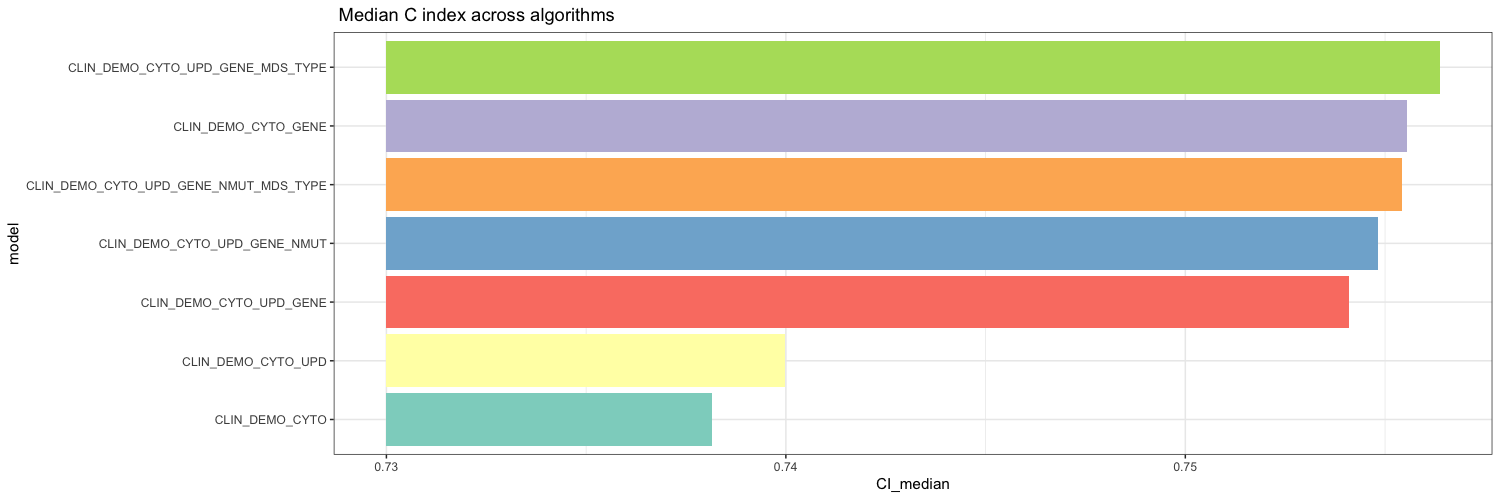

In [604]:
model_rank <- data.frame(model=unique(table_res$model))
model_rank$CI_median <- sapply(model_rank$model, function(x){return(median(df_clin$C_index[df_clin$model==x]))})
model_rank <- model_rank[order(model_rank$CI_median),]
model_rank$model <- factor(model_rank$model, levels = model_rank$model)
set_notebook_plot_size(15,5)
ggplot(model_rank) +
    geom_bar(aes(model,CI_median-0.73,fill=model),stat='identity') +
    coord_flip() +
    scale_fill_manual(values = c('#8dd3c7','#ffffb3','#fb8072','#80b1d3','#fdb462','#bebada','#b3de69'))+
    scale_y_continuous(name='CI_median',breaks=waiver(), labels=c(0.73,0.74,0.75,0.76)) +
    theme(legend.position = 'none') +
    ggtitle(' Median C index across algorithms')

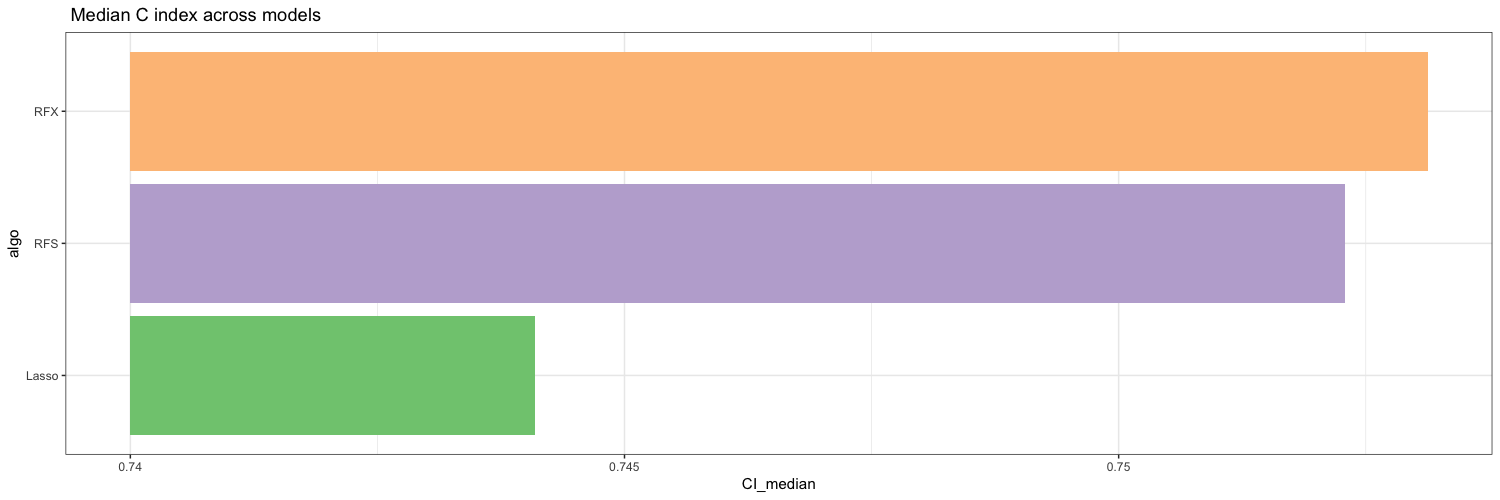

In [614]:
algo_rank <- data.frame(algo=unique(table_res$algo))
algo_rank$CI_median <- sapply(algo_rank$algo, function(x){return(median(df_clin$C_index[df_clin$algorithm==as.character(x)]))})
algo_rank <- algo_rank[order(algo_rank$CI_median),]
algo_rank$algo <- factor(algo_rank$algo, levels = algo_rank$algo)
set_notebook_plot_size(15,5)
ggplot(algo_rank) +
    geom_bar(aes(algo,CI_median-0.74,fill=algo),stat='identity') +
    coord_flip() +
    scale_fill_manual(values = c('#7fc97f','#beaed4','#fdc086'))+
    scale_y_continuous(name='CI_median',breaks=waiver(), labels=c(0.74,0.745,0.75,0.755)) +
    theme(legend.position = 'none') +
    ggtitle(' Median C index across models')


We get the similar results than before, but with a higher concordance index than for the models built on the base of the IPSSR score. This time however, Random forests is doing far better than Lasso. The most complicated models have a greater predictive power, except for the model *CLIN_DEMO_CYTO_GENE* which ranks second. All models are in a very narrow range.

Let's compare all the models together to see better the difference between models based on the IPSSR score and models based on CLIN DEMO CYTO:

In [524]:
model_medians<-c()
df_models$model<-factor(df_models$model,levels=c('IPSSR_SCORE',
                                                 'CLIN_DEMO_CYTO',
                                                 'IPSSR_SCORE_UPD',
                                                 'CLIN_DEMO_CYTO_UPD',
                                                 'IPSSR_SCORE_GENE',
                                                 'CLIN_DEMO_CYTO_GENE',
                                                 'IPSSR_SCORE_UPD_GENE',
                                                 'CLIN_DEMO_CYTO_UPD_GENE',
                                                 'IPSSR_SCORE_UPD_GENE_MDS_TYPE',
                                                 'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE',
                                                 'IPSSR_SCORE_UPD_GENE_NMUT',
                                                 'CLIN_DEMO_CYTO_UPD_GENE_NMUT',
                                                 'IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE',
                                                 'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE'))
for( model in levels(df_models$model)){ 
    model_medians <- c(model_medians,median(df_models$C_index[df_models$model==as.character(model)]))
}
model_medians<-data.frame(model=levels(df_models$model),Z=model_medians)
#model_medians


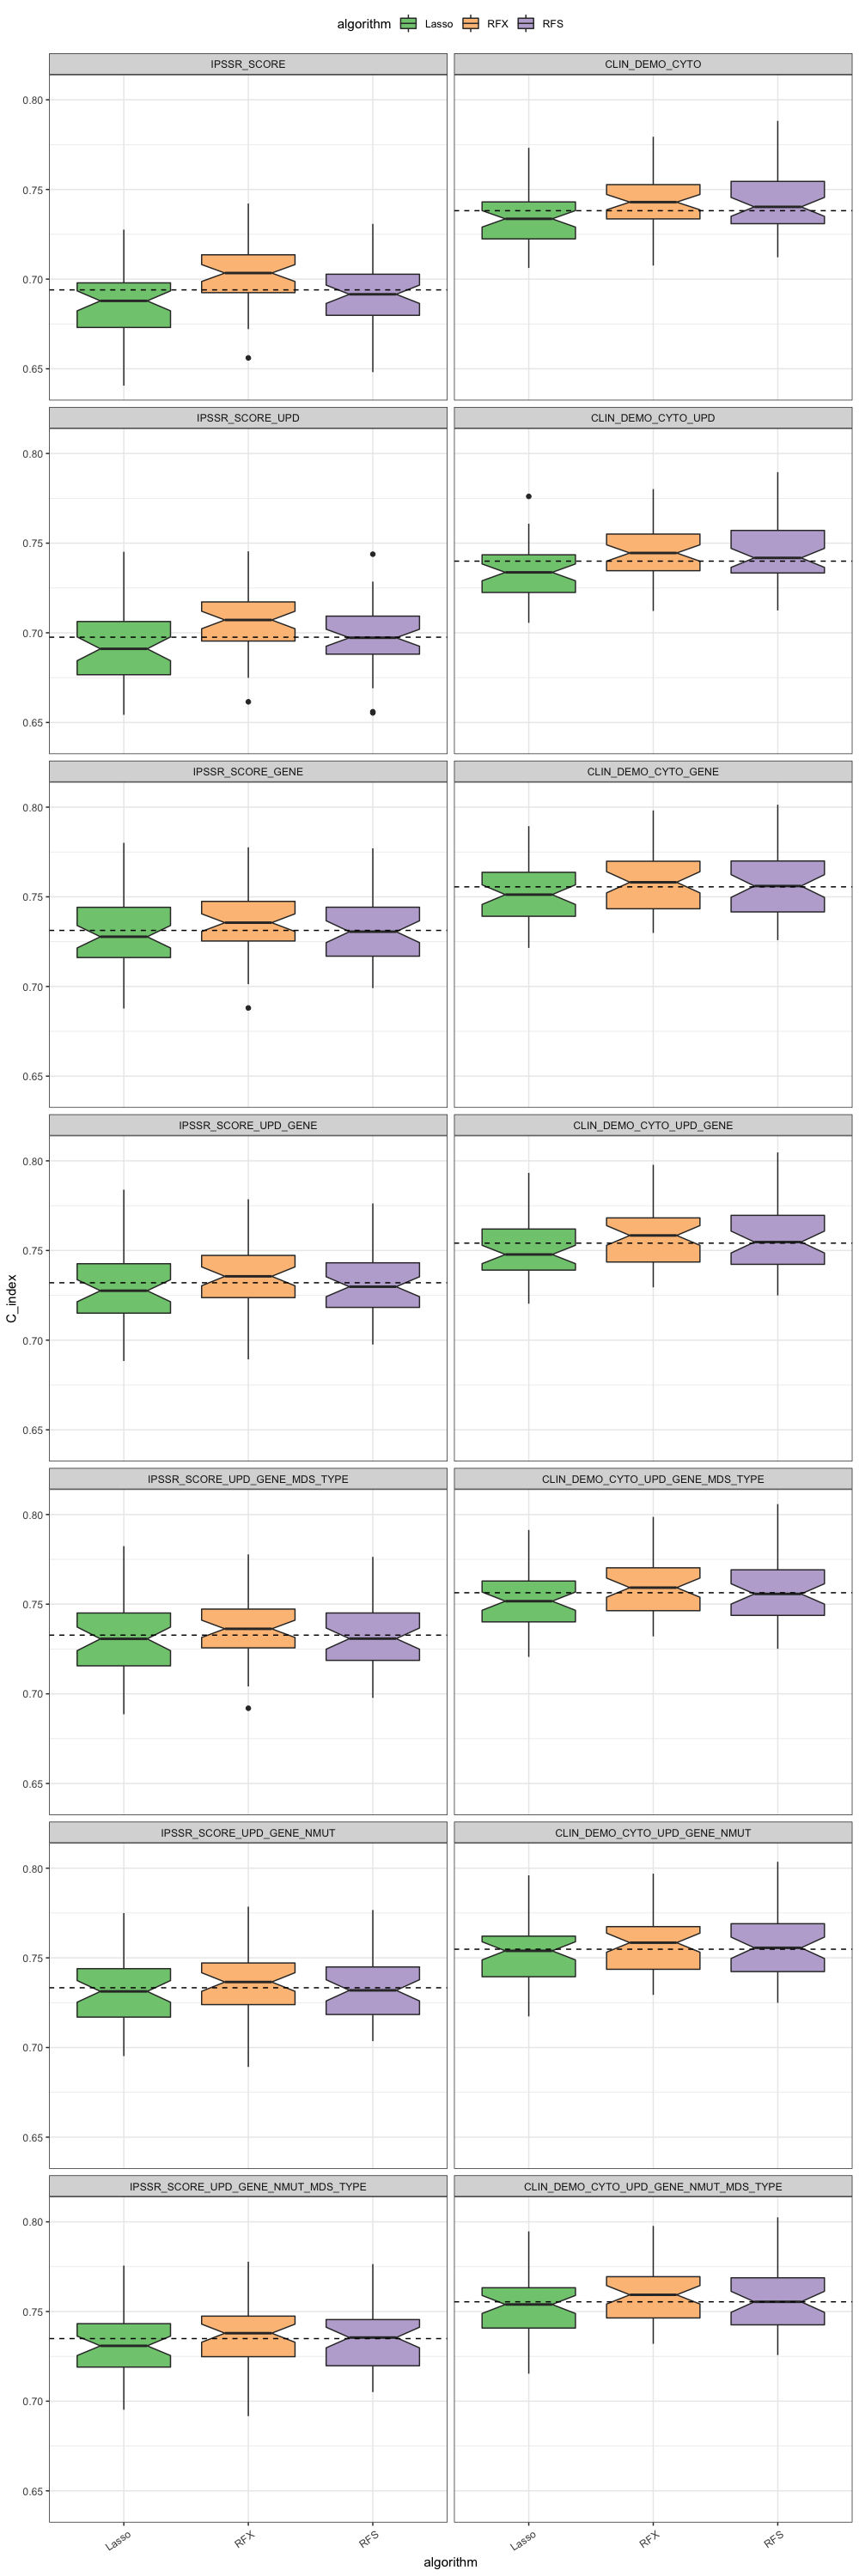

In [730]:
set_notebook_plot_size(10,30)
ggplot(df_models,aes(x=algorithm,y=C_index)) +
    geom_boxplot(aes(fill = algorithm), notch=T)+
    scale_fill_manual(values = c('#7fc97f','#fdc086','#beaed4'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 
    

    

Let's look at the top 5 couples (model, algorithm):

In [527]:
a <- algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE
a <- melt(a,'model')
a <- a[a$variable %in% c('RFX'),]
a$model <- paste0(a$model,'_',a$variable)

b <- algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE
b <- melt(b,'model')
b <- b[b$variable %in% c('RFX'),]
b$model <- paste0(b$model,'_',b$variable)

c <- algo_CLIN_DEMO_CYTO_GENE
c <- melt(c,'model')
c <- c[c$variable %in% c('RFX'),]
c$model <- paste0(c$model,'_',c$variable)

d <- algo_CLIN_DEMO_CYTO_UPD_GENE
d <- melt(d,'model')
d <- d[d$variable %in% c('RFX'),]
d$model <- paste0(d$model,'_',d$variable)

e <- algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT
e <- melt(e,'model')
e <- e[e$variable %in% c('RFX'),]
e$model <- paste0(e$model,'_',e$variable)

df_top <- rbind(a,b,c,d,e)
colnames(df_top) <- c('model','algorithm','C_index')
df_top$model<-factor(df_top$model,levels=c('CLIN_DEMO_CYTO_GENE_RFX',
                                           'CLIN_DEMO_CYTO_UPD_GENE_RFX',
                                           'CLIN_DEMO_CYTO_UPD_GENE_NMUT_RFX',
                                           'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_RFX',
                                           'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_RFX'))

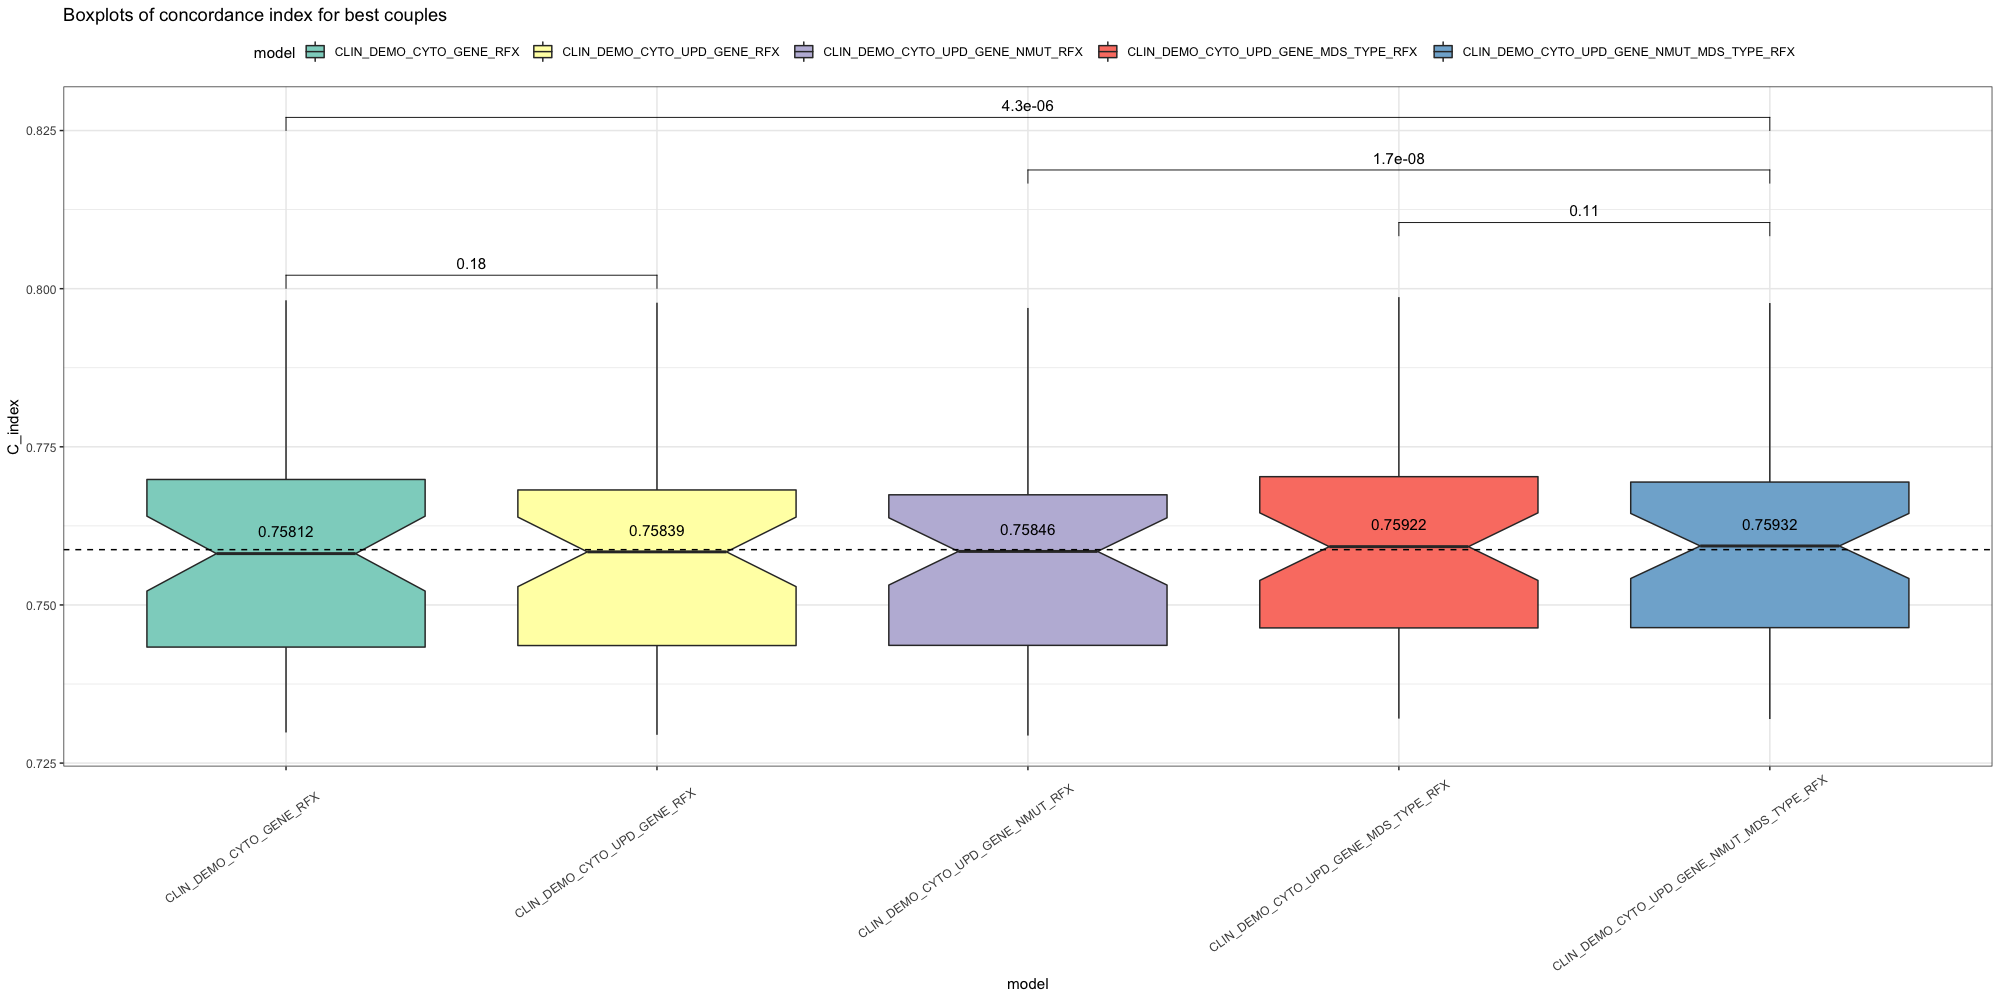

In [529]:
set_notebook_plot_size(20,10)
medians <- data.frame(model=levels(df_top$model))
medians$med <- signif(sapply(levels(df_top$model),function(x){return(median(df_top$C_index[df_top$model==as.character(x)]))}),5)
ggplot(df_top,aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(1,2),c(4,5),c(3,5),c(1,5))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for best couples') +
            geom_hline(yintercept = median(df_top$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.0035, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

Adding the `MDS_TYPE` significantly improves the predictive power, even though all couples (model, algorithm) are in a very narrow range. All the top couples are obtained with Random effects, and the two best are not significantly different.

## 4.3 Removing nuisance in the testing set
All this analysis was performed using `CENTER` and `YEAR_OF_SAMPLE_CORRECT` as nuisance features to adjust the models. However, in the future those features won't be available for prognosis, that is why we need to study the change in the concordance index when *removing* them. We have to let them stay in the training model, so only the testing sets will be changed.

- For the `CENTER` feature, we will consider that the patients are not in any of the centers that were used to build our cohort: we will have `0` for every center.
- For the `YEAR_OF_SAMPLE_CORRECT` feature, we will consider that all patients have the same year of sample, which will be the mean of the whole cohort.

We perform the exact same analysis than before, just changing the nuisance features in the testing sets of the cross validations. We expect the concordance index to drop after changing those features. Let's compare the results obtained with the models with **CLIN DEMO CYTO** base:


In [645]:
algo_CLIN_DEMO_CYTO_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_wt_nuisance.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_GENE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_GENE_wt_nuisance.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_wt_nuisance.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_wt_nuisance.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance.tsv',sep='\t')
algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_GENE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_GENE_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_MDS_TYPE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_MDS_TYPE_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_NMUT_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_NMUT_wt_nuisance.tsv',sep='\t')
algo_IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance <- read.table('../../data/final_dataset/prediction/predictive_algo_IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance.tsv',sep='\t')

df_models_wt_nuisance <- rbind(
    algo_CLIN_DEMO_CYTO_wt_nuisance,
    algo_CLIN_DEMO_CYTO_GENE_wt_nuisance,
    algo_CLIN_DEMO_CYTO_UPD_wt_nuisance,
    algo_CLIN_DEMO_CYTO_UPD_GENE_wt_nuisance,
    algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance,
    algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance,
    algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance,
    algo_IPSSR_SCORE_wt_nuisance,
    algo_IPSSR_SCORE_GENE_wt_nuisance,
    algo_IPSSR_SCORE_UPD_wt_nuisance,
    algo_IPSSR_SCORE_UPD_GENE_wt_nuisance,
    algo_IPSSR_SCORE_UPD_GENE_MDS_TYPE_wt_nuisance,
    algo_IPSSR_SCORE_UPD_GENE_NMUT_wt_nuisance,
    algo_IPSSR_SCORE_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance
)

df_models_wt_nuisance <- melt(df_models_wt_nuisance,'model')
colnames(df_models_wt_nuisance) <- c('model','algorithm','C_index')
df_models_wt_nuisance$model <- paste0(df_models_wt_nuisance$model,"_wt_nuisance")
df_tot <- rbind(df_models,df_models_wt_nuisance)

In [664]:
df_tot_clin <- df_tot[grep('CLIN',df_tot$model),]
df_tot_clin$model<-factor(df_tot_clin$model, levels = c('CLIN_DEMO_CYTO',
                                                        'CLIN_DEMO_CYTO_wt_nuisance',
                                                        'CLIN_DEMO_CYTO_UPD',
                                                        'CLIN_DEMO_CYTO_UPD_wt_nuisance',
                                                        'CLIN_DEMO_CYTO_GENE',
                                                        'CLIN_DEMO_CYTO_GENE_wt_nuisance',
                                                        'CLIN_DEMO_CYTO_UPD_GENE',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_wt_nuisance',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_NMUT',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE',
                                                        'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance'))

In [665]:
medians <- data.frame(model=unique(df_tot_clin$model))
for(algo in unique(df_tot_clin$algorithm)){
    medians[,algo]<-sapply(medians$model,function(x){return(median(df_tot_clin$C_index[df_tot_clin$model==x&df_tot_clin$algorithm==algo]))})
}
medians <- melt(medians,'model')
colnames(medians)<-c('model','algorithm','median')
medians$median <- signif(medians$median,5)

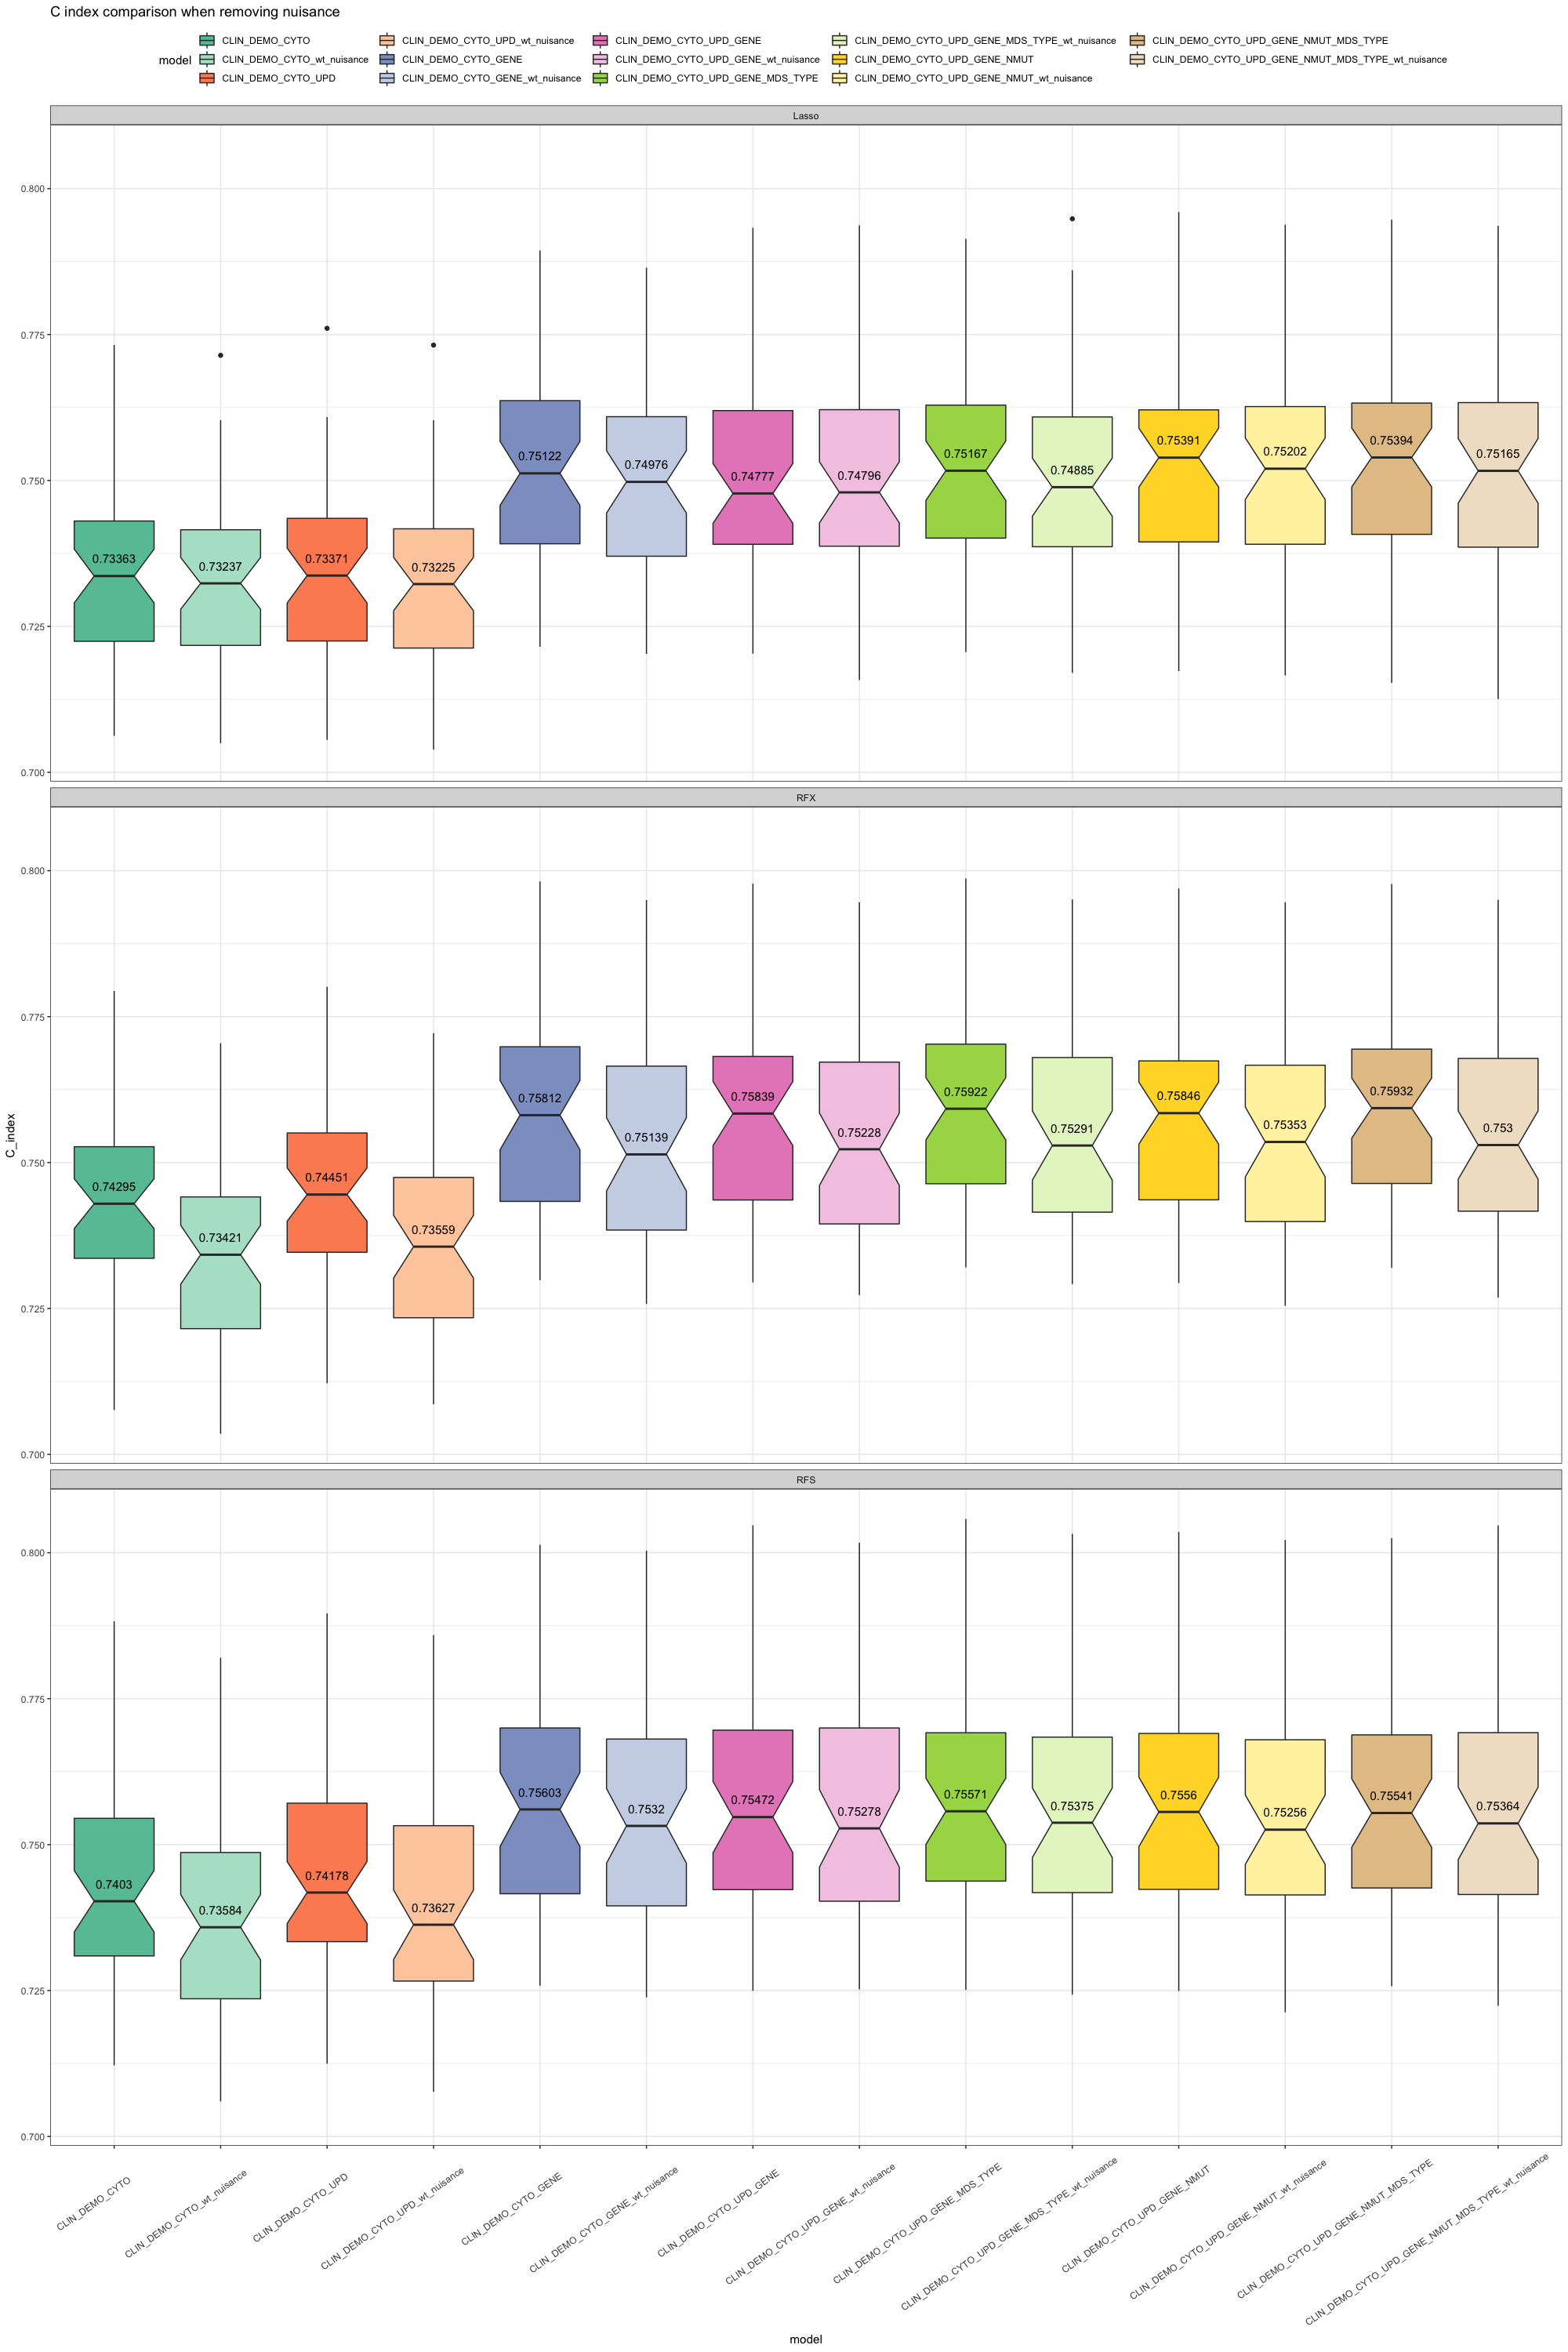

In [669]:
set_notebook_plot_size(20,30)

ggplot(df_tot_clin,aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            scale_fill_manual(values = c('#66c2a5','#b3e2cd','#fc8d62','#fdcdac','#8da0cb','#cbd5e8','#e78ac3','#f4cae4','#a6d854','#e6f5c9','#ffd92f','#fff2ae','#e5c494','#f1e2cc'))+
            ggtitle('C index comparison when removing nuisance') +
            geom_text(aes(model, median+0.003, label=median,fill=NULL),data=medians )+
            facet_wrap(~algorithm,ncol=1)+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 






We see that Lasso and Random forests are almost unchanged, with a very light drop in the C index, while Random effects has a significant drop in the C index, making Random effects and Random forests almost equivalent. We can dig deeper to better see how the models without nuisance are performing.

In [687]:
df_clin_wt_nuisance <- df_tot_clin[grep('nuisance',df_tot_clin$model),]
df_clin_wt_nuisance$model<-factor(df_clin_wt_nuisance$model, levels=c('CLIN_DEMO_CYTO_wt_nuisance',
                                                'CLIN_DEMO_CYTO_UPD_wt_nuisance',
                                                'CLIN_DEMO_CYTO_GENE_wt_nuisance',
                                                'CLIN_DEMO_CYTO_UPD_GENE_wt_nuisance',
                                                'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance',
                                                'CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance',
                                                'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance'))

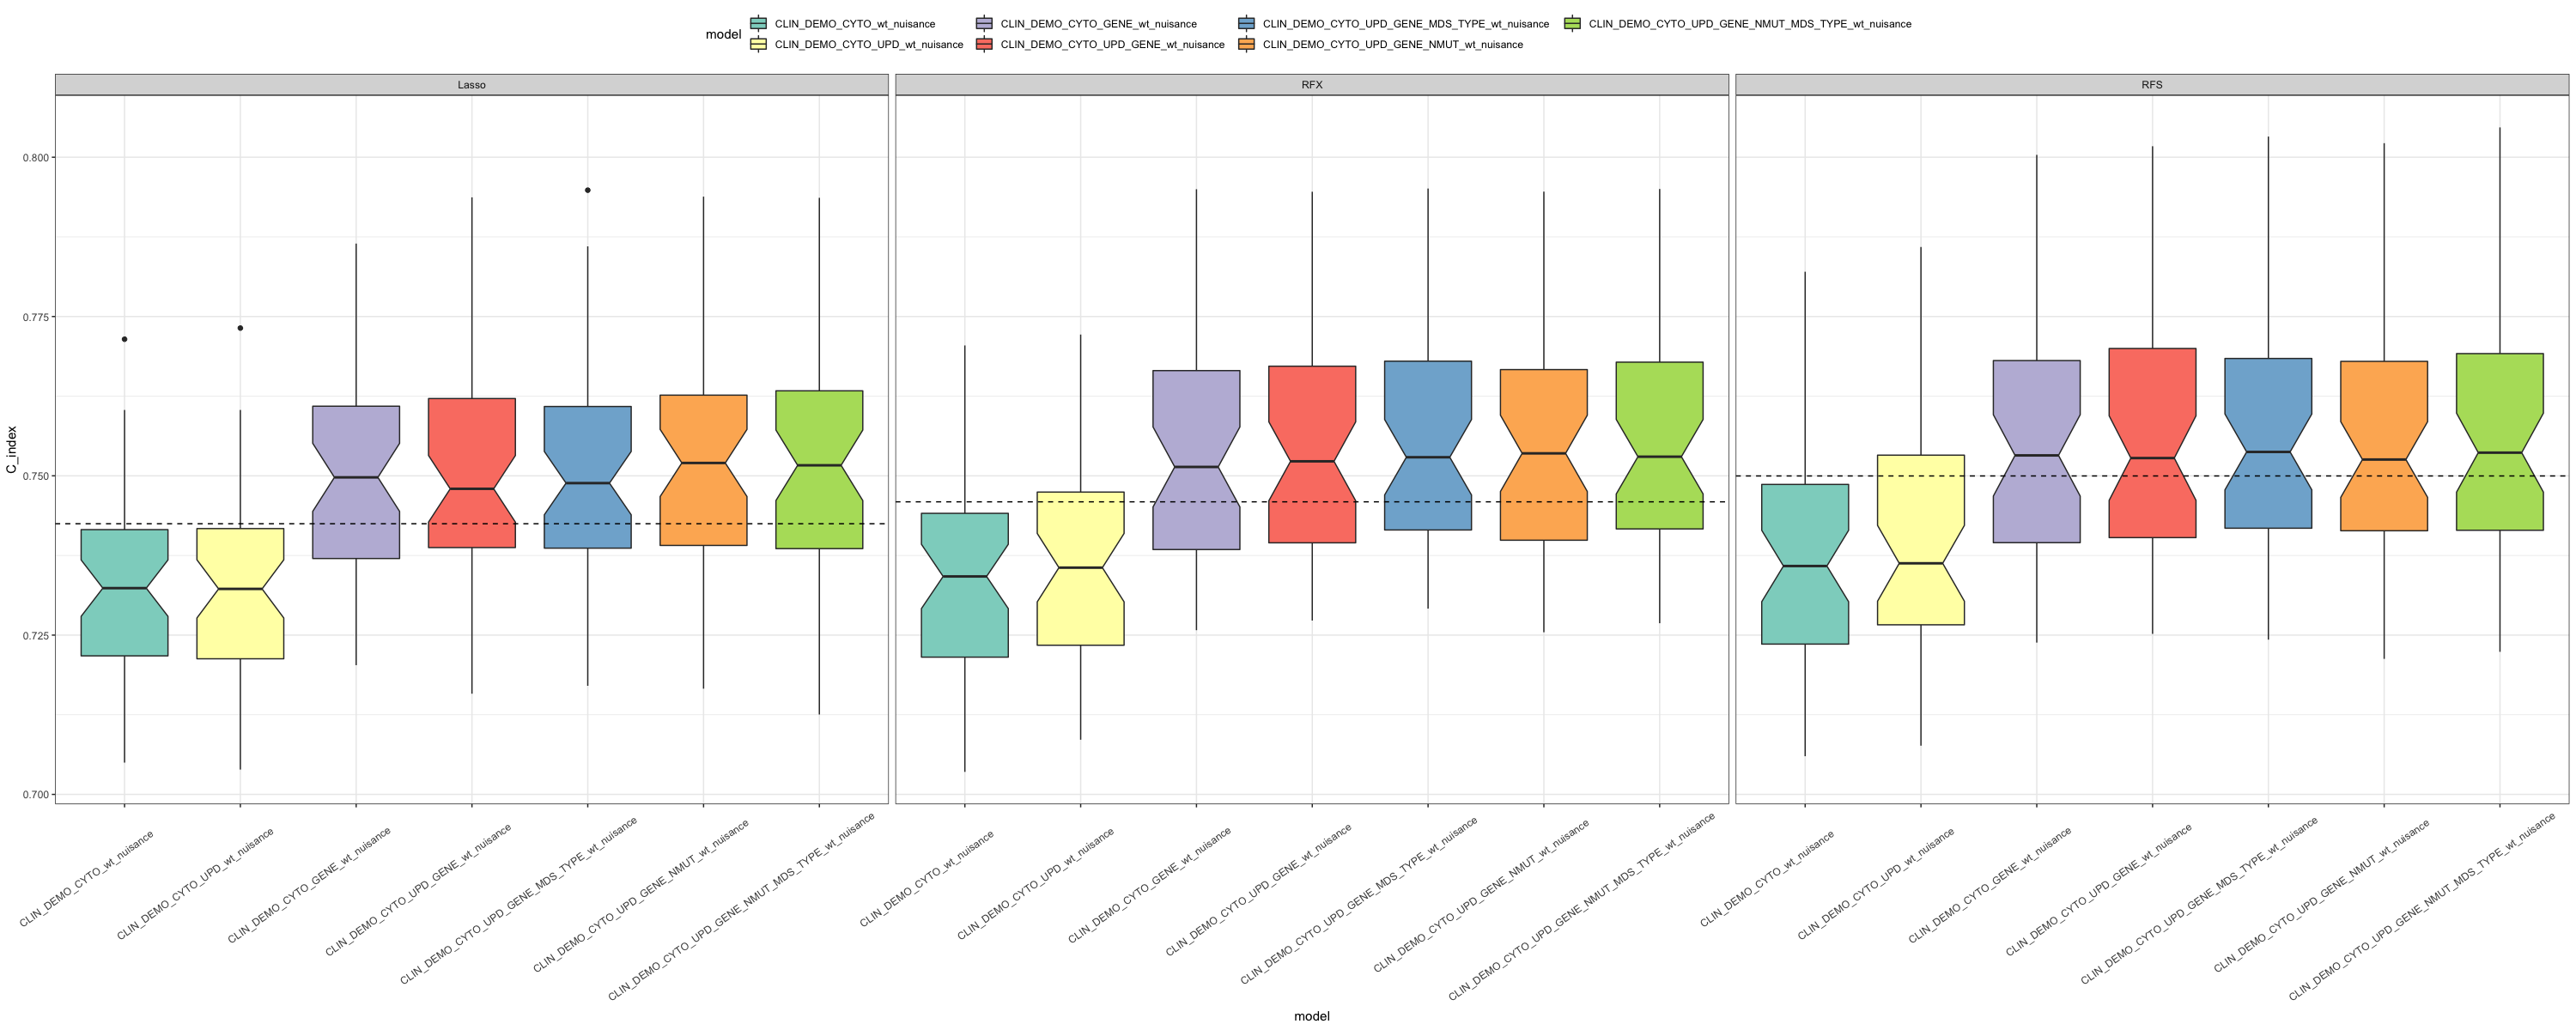

In [734]:

algorithm_medians<-c()
for( algorithm in levels(df_clin_wt_nuisance$algorithm)){

    algorithm_medians <- c(algorithm_medians,median(df_clin_wt_nuisance$C_index[df_clin_wt_nuisance$algorithm==as.character(algorithm)]))
}
algorithm_medians<-data.frame(algorithm=levels(df_clin_wt_nuisance$algorithm),Z=algorithm_medians)

set_notebook_plot_size(30,12)
ggplot(df_clin_wt_nuisance,aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            facet_wrap( ~ algorithm, ncol=3) +
            geom_hline(data = algorithm_medians, aes(yintercept = Z), linetype = 2)+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

This time Random forests is beating Random effects, and all algorithms are almost equivalent.

In [689]:
table_res <- as.data.frame(matrix(0,nrow = 3, ncol=7))
colnames(table_res)<-levels(df_clin_wt_nuisance$model)
rownames(table_res)<-unique(df_clin_wt_nuisance$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_clin_wt_nuisance$C_index[df_clin_wt_nuisance$model==model & df_clin_wt_nuisance$algorithm==algo])
    }
}
table_res

CLIN_DEMO_CYTO_wt_nuisance CLIN_DEMO_CYTO_UPD_wt_nuisance
Lasso 0.7323724                  0.7322532                     
RFX   0.7342079                  0.7355885                     
RFS   0.7358432                  0.7362704                     
      CLIN_DEMO_CYTO_GENE_wt_nuisance CLIN_DEMO_CYTO_UPD_GENE_wt_nuisance
Lasso 0.7497587                       0.7479616                          
RFX   0.7513924                       0.7522767                          
RFS   0.7532049                       0.7527849                          
      CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance
Lasso 0.7488544                                   
RFX   0.7529147                                   
RFS   0.7537479                                   
      CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance
Lasso 0.7520166                               
RFX   0.7535251                               
RFS   0.7525564                               
      CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance
Lasso 0.7516508                                        
RFX   0.7529998                                        
RFS   0.7536351

In [690]:
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','C_index')
table_res$algo<-factor(table_res$algo,levels=c('Lasso','RFX','RFS'))
table_res$model<-factor(table_res$model)

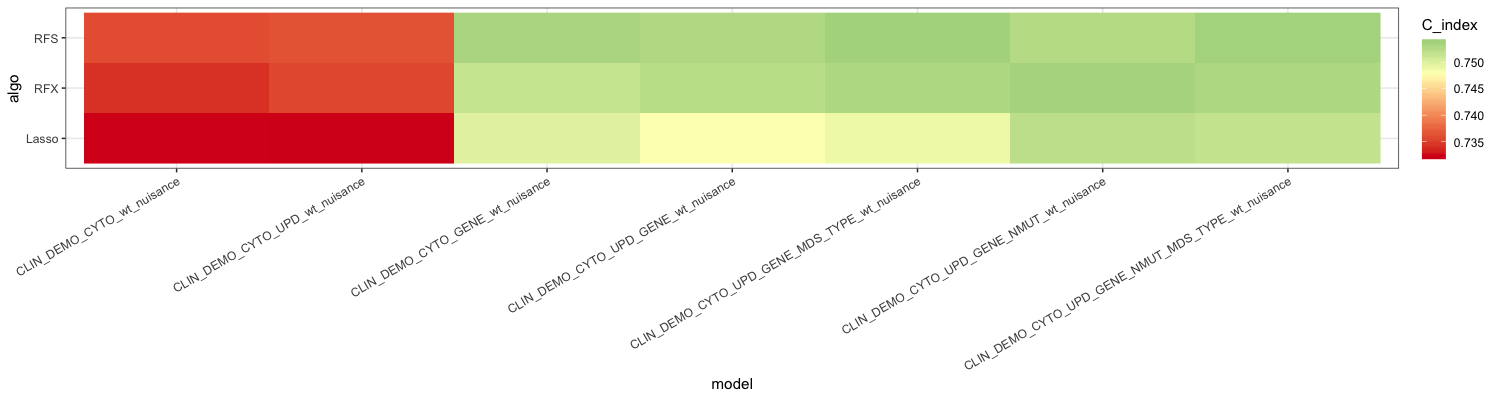

In [691]:
set_notebook_plot_size(15,4)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = C_index), show.legend = TRUE) +
    scale_fill_gradient2(low="#d7191c", high="#1a9641",mid = "#ffffbf",midpoint=mean(df_clin_wt_nuisance$C_index),na.value = 'white') +
    tilt_x_label(30) 
    

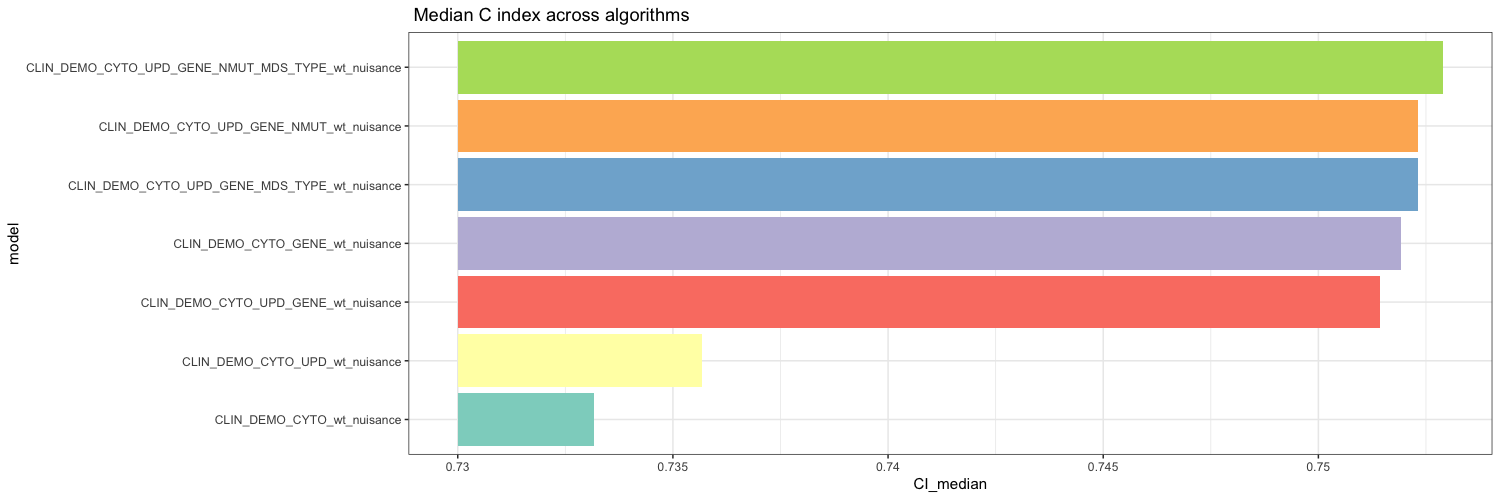

In [736]:
model_rank <- data.frame(model=unique(table_res$model))
model_rank$CI_median <- sapply(model_rank$model, function(x){return(median(df_clin_wt_nuisance$C_index[df_clin_wt_nuisance$model==x]))})
model_rank <- model_rank[order(model_rank$CI_median),]
model_rank$model <- factor(model_rank$model, levels = model_rank$model)
set_notebook_plot_size(15,5)
ggplot(model_rank) +
    geom_bar(aes(model,CI_median-0.73,fill=model),stat='identity') +
    coord_flip() +
    scale_fill_manual(values = c('#8dd3c7','#ffffb3','#fb8072','#bebada','#80b1d3','#fdb462','#b3de69'))+
    scale_y_continuous(name='CI_median',breaks=waiver(), labels=c(0.73,0.735,0.74,0.745,0.75,0.755)) +
    theme(legend.position = 'none') +
    ggtitle(' Median C index across algorithms')

After adding the genes, all models are in a very narrow range, but the most complicated models (with more features) seem to do better than the simplest.

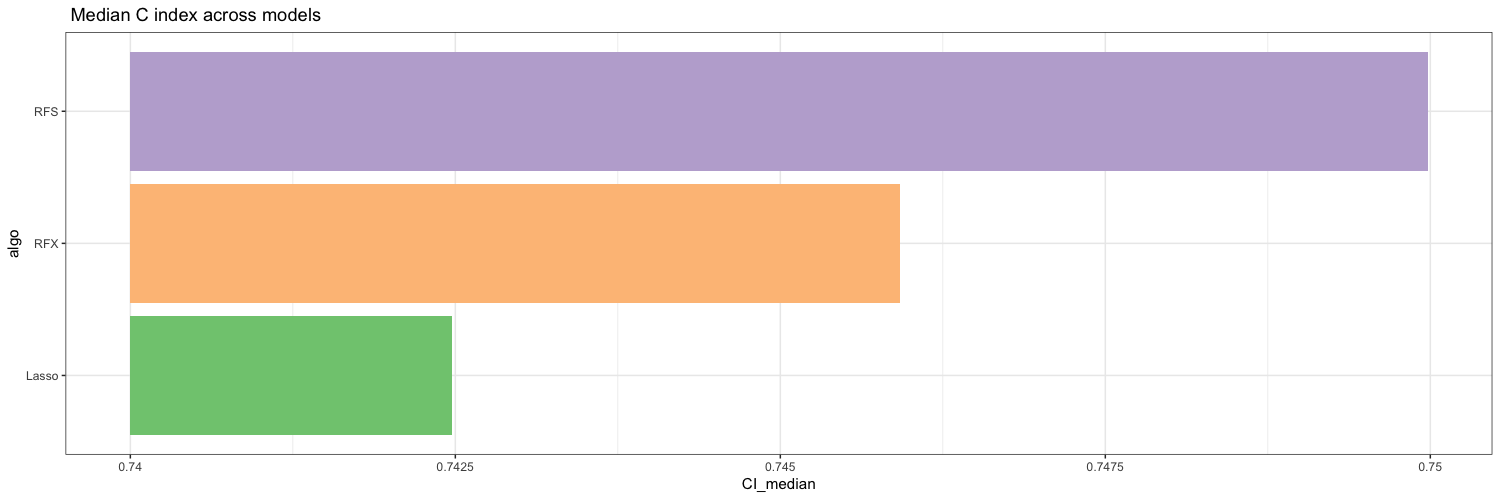

In [733]:
algo_rank <- data.frame(algo=unique(table_res$algo))
algo_rank$CI_median <- sapply(algo_rank$algo, function(x){return(median(df_clin_wt_nuisance$C_index[df_clin_wt_nuisance$algorithm==as.character(x)]))})
algo_rank <- algo_rank[order(algo_rank$CI_median),]
algo_rank$algo <- factor(algo_rank$algo, levels = algo_rank$algo)
set_notebook_plot_size(15,5)
ggplot(algo_rank) +
    geom_bar(aes(algo,CI_median-0.74,fill=algo),stat='identity') +
    coord_flip() +
    scale_fill_manual(values = c('#7fc97f','#fdc086','#beaed4'))+
    scale_y_continuous(name='CI_median',breaks=waiver(), labels=c(0.74,0.7425,0.745,0.7475,0.75)) +
    theme(legend.position = 'none') +
    ggtitle(' Median C index across models')


Even though Random forests is beating Random effects and Lasso, all algorithms have almost identical medians.

We can look at the top 5 couples (model, algorithm):

In [721]:
a <- algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance
a <- melt(a,'model')
a <- a[a$variable %in% c('RFS','RFX'),]
a$model <- paste0(a$model,'_wt_nuisance_',a$variable)

b <- algo_CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance
b <- melt(b,'model')
b <- b[b$variable %in% c('RFS'),]
b$model <- paste0(b$model,'_wt_nuisance_',b$variable)

c <- algo_CLIN_DEMO_CYTO_GENE_wt_nuisance
c <- melt(c,'model')
c <- c[c$variable %in% c('RFS'),]
c$model <- paste0(c$model,'_wt_nuisance_',c$variable)

d <- algo_CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance
d <- melt(d,'model')
d <- d[d$variable %in% c('RFX'),]
d$model <- paste0(d$model,'_wt_nuisance_',d$variable)

df_top <- rbind(a,b,c,d)
colnames(df_top) <- c('model','algorithm','C_index')


In [723]:
df_top$model<-factor(df_top$model,levels=c('CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance_RFX',
                                           'CLIN_DEMO_CYTO_GENE_wt_nuisance_RFS',
                                           'CLIN_DEMO_CYTO_UPD_GENE_NMUT_wt_nuisance_RFX',
                                           'CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_wt_nuisance_RFS',
                                           'CLIN_DEMO_CYTO_UPD_GENE_MDS_TYPE_wt_nuisance_RFS'))

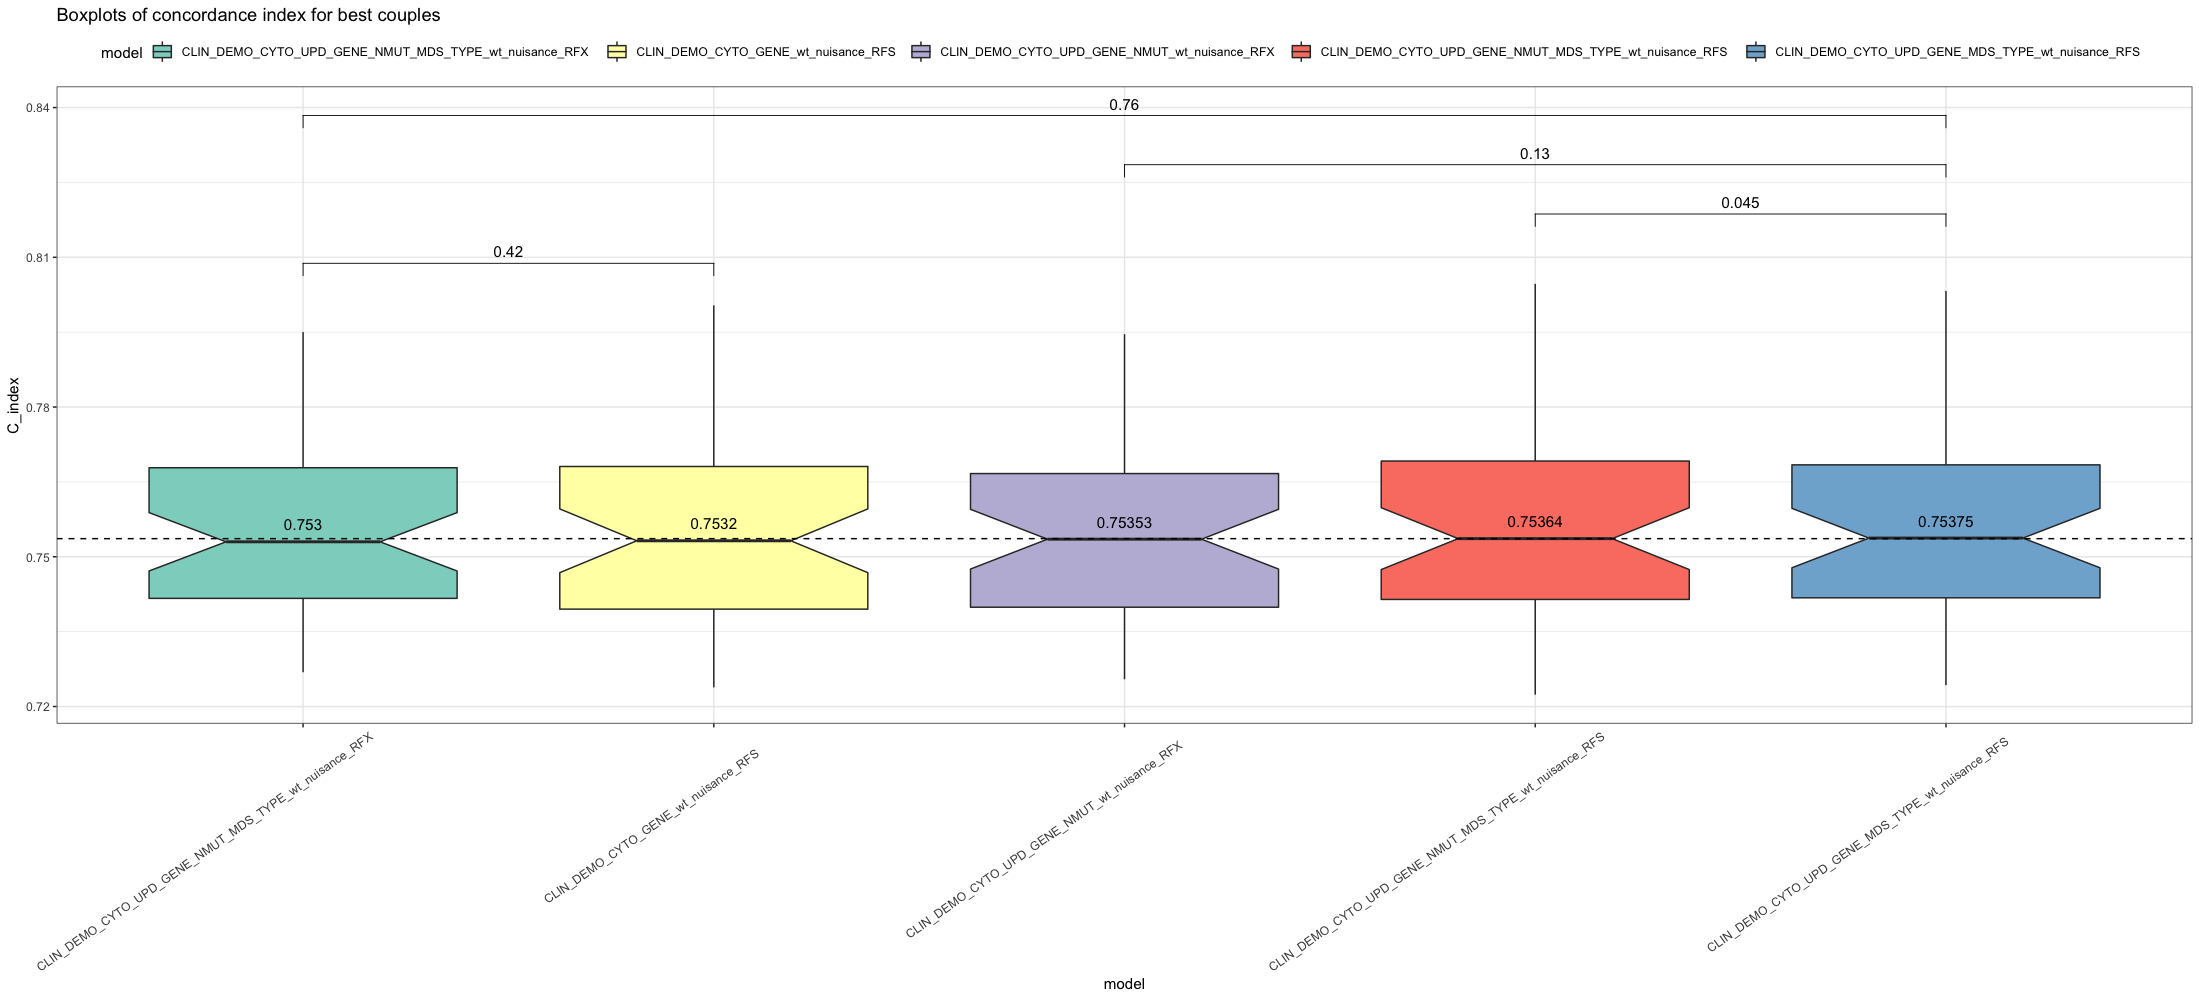

In [740]:
set_notebook_plot_size(22,10)
medians <- data.frame(model=levels(df_top$model))
medians$med <- signif(sapply(levels(df_top$model),function(x){return(median(df_top$C_index[df_top$model==as.character(x)]))}),5)
ggplot(df_top,aes(model,C_index)) +
            geom_boxplot(aes(fill = model), notch=T)+
            stat_compare_means(paired = T, comparisons = list(c(1,2),c(4,5),c(3,5),c(1,5))) +
            scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
            ggtitle('Boxplots of concordance index for best couples') +
            geom_hline(yintercept = median(df_top$C_index), linetype = 2) + 
            geom_text(aes(model, med+0.0035, label=med,fill=NULL),data=medians )+
            theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

All couples (model, algorithm) are in a very narrow range, and not really significantly different from one another overall. The two best are obtained with Random forests, closely followed by one obtained with Random effects.

# 5. Feature importance


The metrics used by each algorithm to get the feature importance are different, so using them to compare the feature selected between each algorithm is to be nuanced. Here we propose a function that will use the same metric: compare the concordance index before and after shuffling the feature we want to test the importance. Here is an overview of how it works:

**Feature Importance Algorithm**

*Input: model, predictive algorithm, number of repetitions, features to test the importance, number of permutation*



    for each repetition {
    
            create 5 (training, testing) sets for cross validation  
            
            for each (training, testing) set {
            
                    train model and evaluate reference concordance index

                    for each feature {

                            for each permutation {

                                    shuffle feature in testing set
                                    predict
                                    evaluate shuffled concordance index
                                    compare to the reference concordance index

                            }
                    }
            }   
    }


*Output: differences between reference CI and CI obtained from shuffling data for each feature tested*





This way we minimize the number of model trainings (= `n_repeat*5`) without introducing too much bias thanks to the several cross validations, even though we will have many predictions to compute.

We describe how this algorithm works with the model *CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE* (transforming the clinical features), and the 3 algorithms Lasso, Random forests and Random effects are used to compare the 3 endpoints OS, AML transformation and event free survival. We perform 5 repetitions of 5-fold CV with 20 permutations each time, which means that for every feature we have 25 training sets and we test on 25 testing sets, and for each testing set we shuffle 20 times. So 500 ratios of CI for each variable. If the ratio is one, it means that shuffling the feature did not change the concordance index. When the ratio is greater than one, it means that shuffling the feature decreased the concordance index.

In [5]:
get_category <- function(x){
    x<-as.character(x)
    if(str_detect(x,'CENTER')|str_detect(x,'YEAR')){return('NUISANCE')}
    else if (x %in% cytoaberrations){return('CYTO')}
    else if (x %in% mutations){return('GENE')}
    else if (x %in% age|str_detect(x,'SEX')){return('DEMO')}
    else if (x %in% clin){return('CLIN')}
    else if (str_detect(x,'MDS_TYPE')){return('MDS_TYPE')}
    else if (x=='num_mutations'){return('NMUT')}
    else if (x %in% upd){return('UPD')}
    else{return('none')}
}

In [6]:
CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_AML <- read.table('../../data/final_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_AML.tsv',sep='\t')
CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_EVENT <- read.table('../../data/final_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_EVENT.tsv',sep='\t')
CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_OS <- read.table('../../data/final_dataset/feature_importance/feature_importance_CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_OS.tsv',sep='\t')

CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE<-rbind(CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_OS,
                                             CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_EVENT,
                                             CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE_AML)


In [7]:
CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$ratio <- CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$ref_CI/CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$permuted_CI
CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$category<-as.character(sapply(CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$feature,get_category))

In [8]:
feat_median <- get_max_median(CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE)

Let's look at the distribution of ratios for the features of the best half:

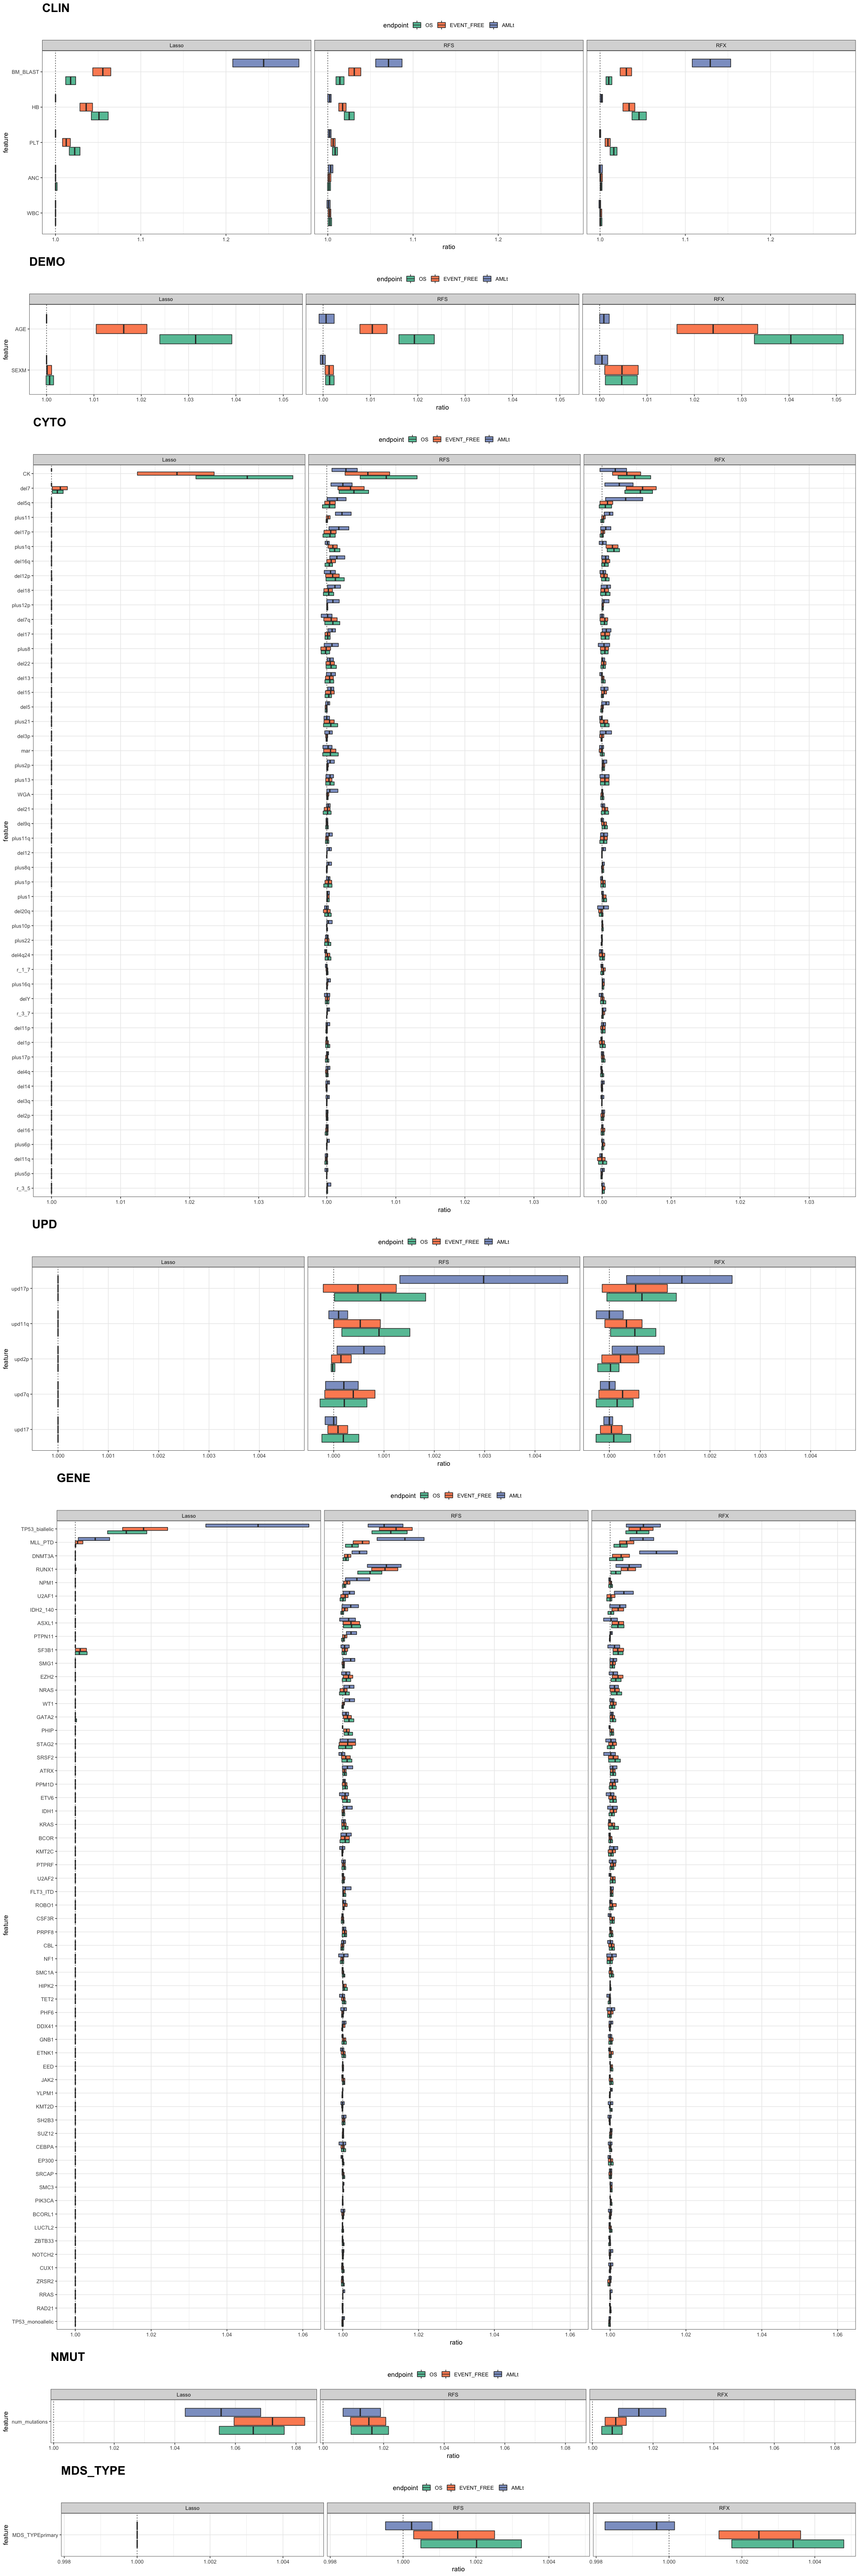

In [620]:
set_notebook_plot_size(20,60)
# display only the best features
data <- CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE[CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$feature %in% feat_median$feature[feat_median$max_median>median(feat_median$max_median)],]
caterogies_boxplot(data,nuisance=FALSE)


We can also compute the p-values of the features for each endpoint and each algorithm to see which one are significant:

In [9]:
features_pval <- get_table_pval(CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE)

In [10]:
sig_features <- CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE[CLIN_DEMO_CYTO_UPD_GENE_NMUT_MDS_TYPE$feature %in% unique(features_pval$feature[features_pval$Lasso < 0.05 | 
                                                                                                                                      features_pval$RFX   < 0.05 | 
                                                                                                                                      features_pval$RFS   < 0.05]),]


The p-values of the significant features for each endpoint and algorithm are disployed bellow, removing the nuisance features.

In [11]:
features_pval[features_pval$feature %in% sig_features$feature[sig_features$category!="NUISANCE"],]

feature         Lasso         RFX           RFS           endpoint  
25  HB              2.188831e-145 2.903460e-157  3.970515e-67 OS        
26  PLT              8.704349e-76  2.554143e-63  7.620621e-13 OS        
27  ANC              2.325497e-01  9.217885e-02  1.508483e-01 OS        
28  BM_BLAST         8.837467e-53  5.636307e-33  1.452273e-32 OS        
29  WBC              5.854134e-01  3.386039e-01  9.457472e-03 OS        
30  AGE             1.373107e-102 5.588331e-149  4.497435e-56 OS        
31  SEXM             4.115355e-01  9.566845e-08  9.870564e-02 OS        
32  del5q            1.000000e+00  2.832716e-01  5.268599e-01 OS        
34  del7             1.089087e-01  1.171611e-12  1.109673e-04 OS        
40  del17p           1.000000e+00  9.285388e-01  6.176284e-01 OS        
51  plus1q           1.000000e+00  6.705400e-03  1.527249e-01 OS        
68  plus11           1.000000e+00  8.335634e-01  9.616585e-01 OS        
151 CK               2.097171e-92  1.460106e-09  7.320373e-15 OS        
154 upd17p           9.703743e-01  2.716464e-01  2.396233e-01 OS        
170 ASXL1            9.948421e-01  7.303856e-03  2.315082e-02 OS        
172 ATRX             9.965903e-01  1.717931e-01  3.287469e-01 OS        
196 DNMT3A           1.000000e+00  4.923820e-02  2.440254e-01 OS        
203 EZH2             1.000000e+00  1.739522e-02  2.803339e-01 OS        
214 IDH2_140         1.000000e+00  6.440912e-01  7.961649e-01 OS        
229 MLL_PTD          7.293029e-01  3.727435e-04  1.238828e-02 OS        
237 NPM1             1.000000e+00  8.114136e-01  4.228776e-01 OS        
238 NRAS             9.895981e-01  1.301459e-02  4.986559e-01 OS        
246 PTPN11           1.000000e+00  6.854388e-01  7.726016e-01 OS        
256 RUNX1            1.000000e+00  3.203964e-02  3.612687e-10 OS        
261 SF3B1            3.726129e-02  4.976594e-04  5.383655e-01 OS        
278 WT1              1.000000e+00  3.463980e-01  9.756276e-01 OS        
285 TP53_biallelic   1.339560e-34  7.325507e-17  2.856886e-26 OS        
286 U2AF1            1.000000e+00  7.393056e-01  9.965926e-01 OS        
287 num_mutations   3.264416e-157  1.101153e-17  4.555411e-38 OS        
288 MDS_TYPEprimary  8.799211e-01  1.970294e-05  5.906823e-02 OS        
313 HB              2.398621e-100 1.945910e-105  3.917686e-32 EVENT_FREE
314 PLT              1.014497e-26  1.033866e-14  1.373068e-06 EVENT_FREE
315 ANC              5.252336e-01  1.994078e-01  9.175701e-02 EVENT_FREE
316 BM_BLAST        2.104959e-141  6.891301e-94  4.220579e-82 EVENT_FREE
317 WBC              8.954750e-01  4.807624e-01  5.077421e-02 EVENT_FREE
318 AGE              3.424031e-36  6.219762e-73  5.433484e-18 EVENT_FREE
319 SEXM             4.999850e-01  9.782144e-05  1.123651e-01 EVENT_FREE
320 del5q            1.000000e+00  2.557432e-01  4.848611e-01 EVENT_FREE
322 del7             6.876717e-02  1.523577e-08  2.940124e-03 EVENT_FREE
328 del17p           1.000000e+00  6.551236e-01  5.098410e-01 EVENT_FREE
339 plus1q           1.000000e+00  5.155698e-02  2.972541e-01 EVENT_FREE
356 plus11           1.000000e+00  5.084332e-01  5.112456e-01 EVENT_FREE
439 CK               1.175067e-41  8.460440e-05  4.416642e-07 EVENT_FREE
442 upd17p           9.895970e-01  2.912058e-01  5.084356e-01 EVENT_FREE
458 ASXL1            9.878484e-01  2.479020e-02  5.288449e-02 EVENT_FREE
460 ATRX             1.000000e+00  2.127603e-01  5.632259e-01 EVENT_FREE
484 DNMT3A           1.000000e+00  7.303930e-03  1.269273e-01 EVENT_FREE
491 EZH2             8.868200e-01  2.315081e-02  1.571737e-01 EVENT_FREE
502 IDH2_140         9.058901e-01  3.221523e-02  5.961989e-01 EVENT_FREE
517 MLL_PTD          1.018268e-01  5.021680e-06  3.109470e-05 EVENT_FREE
525 NPM1             1.000000e+00  7.675782e-01  1.578168e-01 EVENT_FREE
526 NRAS             1.000000e+00  1.502268e-01  8.661729e-01 EVENT_FREE
534 PTPN11           1.000000e+00  9.198417e-01  4.421379e-01 EVENT_FREE
544 RUNX1            7.792358e-01  3.059066e-06  1.060080e-17 

Displaying only the significant features:

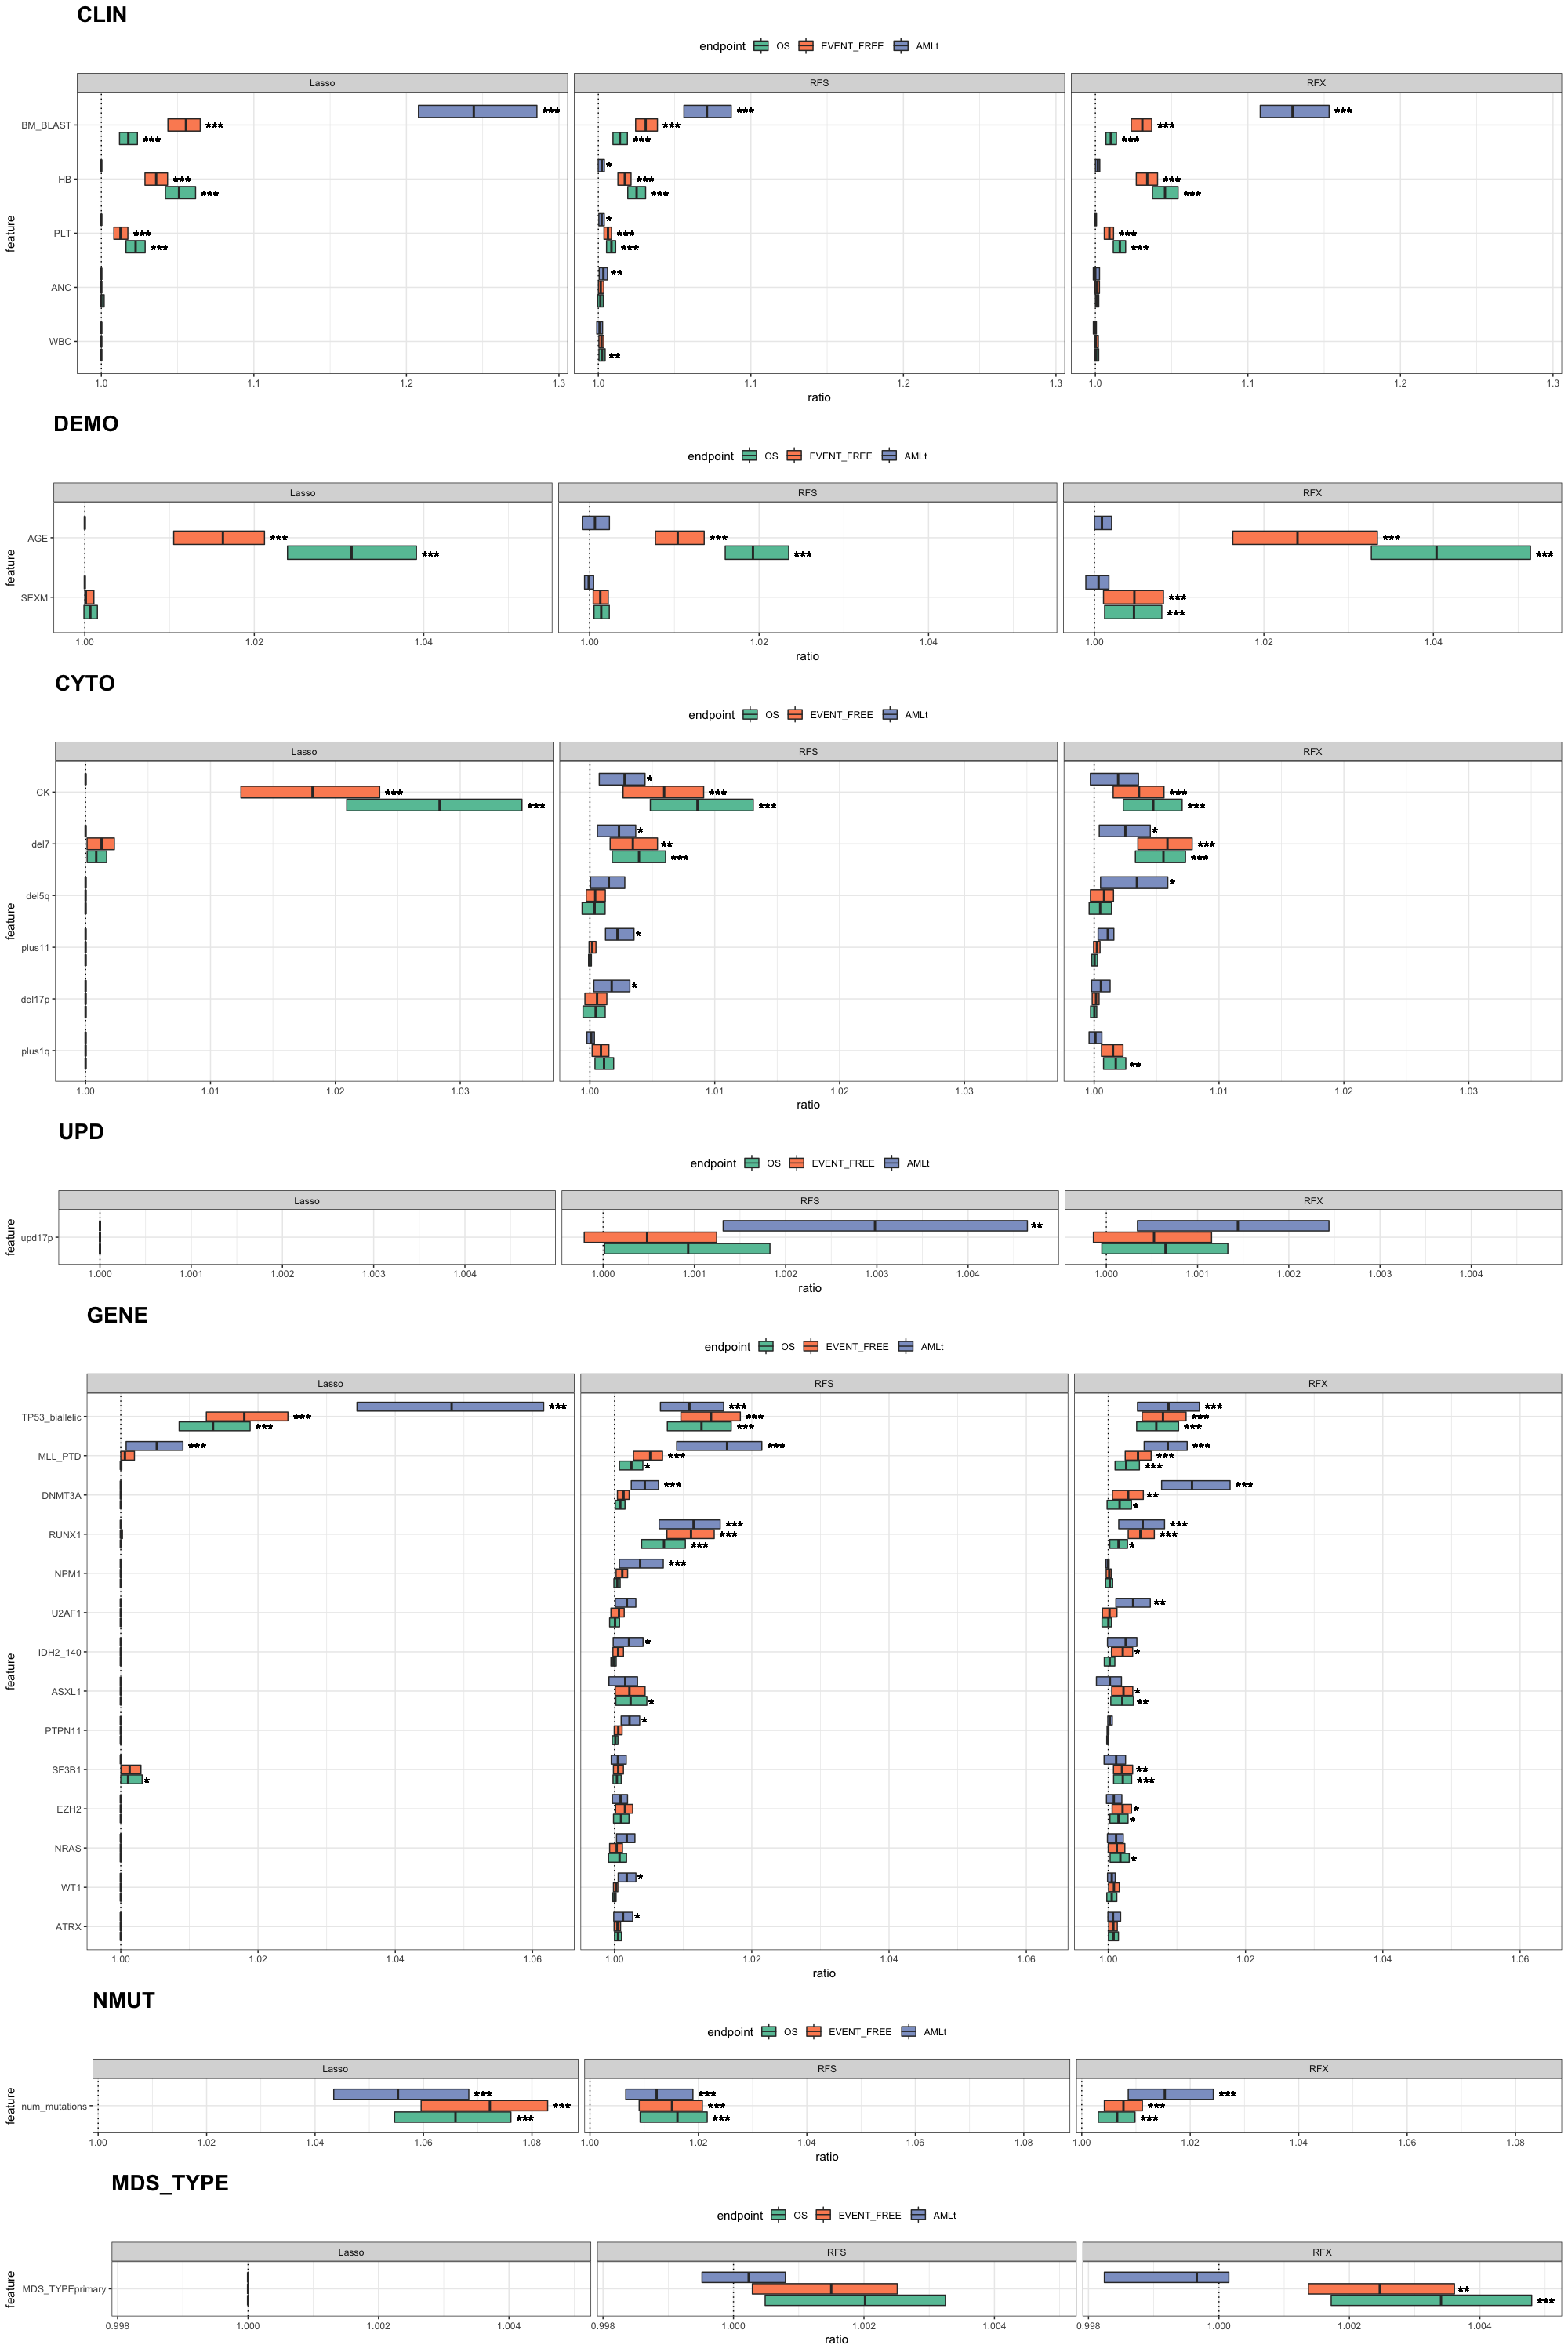

In [12]:
set_notebook_plot_size(20,30)
caterogies_boxplot(sig_features,nuisance=FALSE,pval=features_pval)

The best features, such as `TP53_biallelic` or `BM_BLAST` are important in all algorithms, but otherwise the importance of the features differs from one algorithm to another: `upd17p`, `num_mutations` or `MDS_TYPE` are telling examples of this trend.

Endpoints also take into account different features: `AGE` is not important for AML transformation, but it is for the other two endpoints. Many genes, such as `DNMT3A`, `NPM1` or `IDH2_140` are far more important for AML transformation, as is `BM_BLAST`.

Complex karyotype `CK` is a highly important feature for both OS and event free survival, just like `HB`, `SEXM` or `MDS_TYPE`.